In [354]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_theme()

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats

from sklearn import linear_model
from sklearn.cluster import KMeans

from math import floor
import csv

In [355]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Load Data

In [356]:
table_najafgarh = pd.read_csv("responses_najafgarh.csv",skipinitialspace=True)
table_okhla = pd.read_csv("responses_okhla.csv",skipinitialspace=True)
table_najafgarh.columns

Index(['Timestamp', 'Email Address', 'Group',
       'Place where interview conducted', 'Where do you work? ',
       'How long have you been working here?',
       'How long does it take to reach there, from your locality?',
       'What is the position you are holding currently? ',
       'What are the main tasks you perform there?',
       'Does your workplace give updates about air pollution?',
       'If yes, how frequently do they give updates? ',
       'Did your institution ever organize workshops related to environmental issues?',
       'Does your institution receive any fundings to manage air pollution?',
       ' If yes, from where? ',
       'Would you like to engage your institution with any environmental program/ organization funded by local government? ',
       'Do you know about the Air Quality Index (AQI)?  ',
       'Have you ever seen the screens displaying air quality as severe/poor/good in different colors in different parts of the city, do you understand the lan

# Function Definitions

In [357]:
groups = ['Teacher', 'Student', 'Academy', 'Mother of young kids ','Market Association']
def plot_col_social_group(table,col,perc=False,title='tile',xlabel='xlabel',loc='best',samples=50,group_col = 'Group'):
    sns.set_style("ticks")
    sns.set(font_scale = 2.5)
    copy_col = table.loc[:,col]
    copy_col[copy_col.isnull()] = 'not filled'
#     print(copy_col)
    table.loc[:,col] = copy_col
    group_vals = []
    group_perc = []
    uniq = table[col].unique()
#     print('uniq',uniq,col)
    
    for g in groups:
        values = table[table[group_col]==g][col].value_counts(ascending=False)
        
#         print('values',values)
        ordered_values = []
        for u in uniq:
            if(u in values):
                ordered_values.append(values[u])
            else:
#                 print('adding',u)
                ordered_values.append(0)
        
        sm = sum(ordered_values)
        
#         print(g,sm,ordered_values)
        
        perc = [(float(x)* 100)/sm for x in ordered_values]
        perc = [str(int(x))+'%' for x in perc]
        group_vals.append(ordered_values)
        group_perc.append(perc)
        
    
    fig, ax = plt.subplots(figsize=(40,20))
    
    sns.countplot(x=col, hue=group_col, data=table,ax=ax)
    for g in range(len(groups)):
#         print(groups[g],g,ax[0].containers[g])
        ax.bar_label(container=ax.containers[g], labels=group_vals[g])
    
    ax.set_title(title,pad=20)
    ax.set_xlabel(xlabel,labelpad=20)
    ax.set_ylabel('No. of responses',labelpad=20)
    ax.plot([], [], ' ', label="total samples : "+str(samples))
    
#     print([len(x) for x in uniq])
    if(max([len(x) for x in uniq])>30):
        ax.tick_params(axis='x', which='major', labelsize=20)
    
    legend = ax.legend(title="Social Groups",fancybox=True,loc=loc)
    x0, x1, y0, y1 = ax.axis()
    plot_margin = 0.25
    ax.axis((x0 - plot_margin,
          x1 + plot_margin+1,
          y0 - plot_margin,
          y1 + plot_margin))
    
    fig.show()
    
    fig, ax = plt.subplots(figsize=(15,7.5))
    
    table.groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax,xlabel=title,ylabel='',title='',fontsize=12)

# plot_col_social_group(table_najafgarh,'Does your workplace give updates about air pollution?',
#          title = 'Najafgarh responses :Does your workplace give updates about air pollution?',
#          xlabel = 'Does your workplace give updates about air pollution',loc='upper right')

# Questions selected from each section

In [358]:
cols1 = [
    'Place where interview conducted',
    'How frequently do you check air quality? ',
    'Does your workplace give updates about air pollution?',
    'If yes, how frequently do they give updates? ',
    'Did your institution ever organize workshops related to environmental issues?',
    'Does your institution receive any fundings to manage air pollution?',
    'Would you like to engage your institution with any environmental program/ organization funded by local government? '
]

cols2 = [
    'Do you know about the Air Quality Index (AQI)?  ',
    'Have you ever seen the screens displaying air quality as severe/poor/good in different colors in different parts of the city, do you understand the language?',
    'Do you know the meaning of severe/ poor/good air quality?',
    'If yes, what does the red color in AQI mean?',
    'Have you ever heard the terms PM 2.5 and PM10?',
    'If yes, which one is more harmful? ',
    'How accessible is the real-time air quality data of your area?',
    'How frequently do you check air quality? ',
    'How do you handle pollution-related issues? ',
    'What are your thoughts on the change in air quality in your city over the last 3-4 years?',
]

cols2 = [
    'Do you know about the Air Quality Index (AQI)?  ',
    'Have you ever seen the screens displaying air quality as severe/poor/good in different colors in different parts of the city, do you understand the language?',
    'Do you know the meaning of severe/ poor/good air quality?',
    'If yes, what does the red color in AQI mean?',
    'Have you ever heard the terms PM 2.5 and PM10?',
    'If yes, which one is more harmful? ',
    'How accessible is the real-time air quality data of your area?',
    'How frequently do you check air quality? ',
    'Do you talk about air pollution at home/workplace/with friends?',
    'Are you aware of any public health emergencies issued by the Government of Delhi on the account of extremely poor air quality in the last two years?  ',
    'Is there an established institution to tackle air pollution-related issues in your area? ',
    'In the last municipal elections, were the issues around pollution politicized? '
]

cols3 = [
    'What are your thoughts on the change in air quality in your city over the last 3-4 years?',
    'Do you think the quality of air varies across localities?',
    'Do you think different social activities impact local air quality?',
    'How will you rate your local air quality?',
    'Do you think the Delhi Government is taking adequate steps to improve air quality in your city?',
    'How polluted do you think is the area where you live in comparison to the rest of Delhi-NCR?', 
]

cols4 = [
    'Gender',
    'Up to what level have you studied?'
]

# Najafgarh

In [ ]:
groups = list(table_najafgarh['Group'].unique())
plot_selected_columns = []
plot_selected_columns += cols1
plot_selected_columns += cols2
plot_selected_columns += cols3
plot_selected_columns += cols4
for i in plot_selected_columns:
    col_name = i
    title = 'Najafgarh responses : '+col_name
    xlabel = col_name.replace("?", "")
    plot_col_social_group(table_najafgarh,col_name,
             title = title,
             xlabel = xlabel,loc='upper right',samples=50)

# okhla

In [ ]:
groups = list(table_okhla['Group'].unique())
plot_selected_columns = []
plot_selected_columns += cols1
plot_selected_columns += cols2
plot_selected_columns += cols3
plot_selected_columns += cols4
for i in plot_selected_columns:
    col_name = i
    title = 'Okhla responses : '+col_name
    xlabel = col_name.replace("?", "")
    plot_col_social_group(table_okhla,col_name,
             title = title,
             xlabel = xlabel,loc='upper right',samples=50)

# Social Groups Combined

/tmp/ipykernel_376/2972247775.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(40,20))


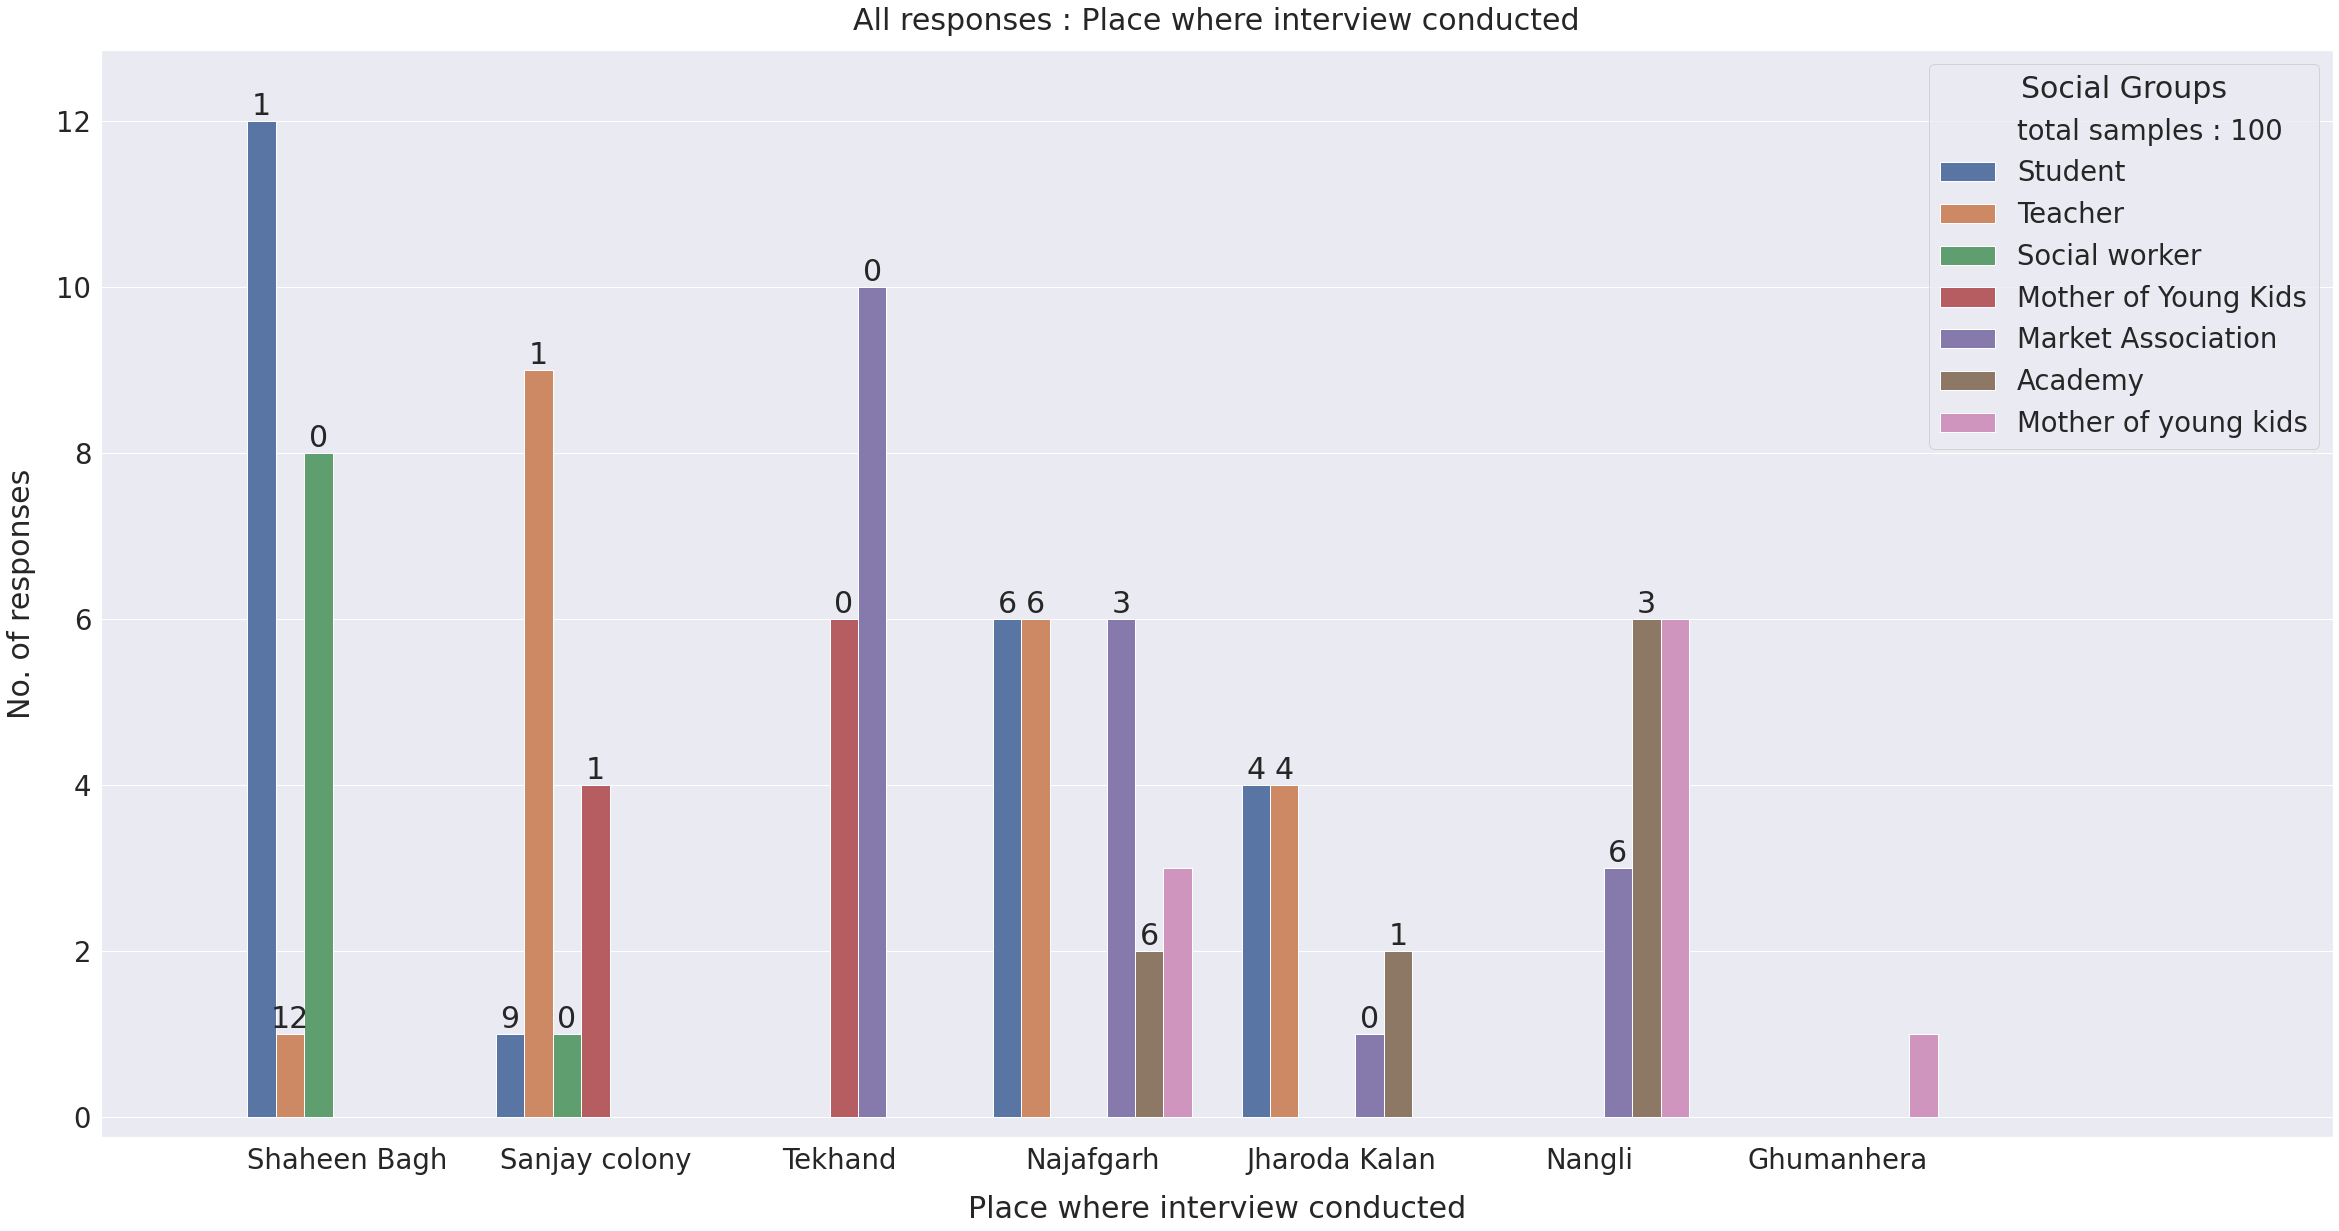

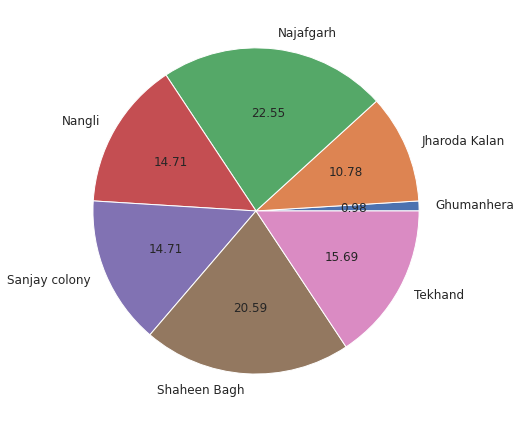

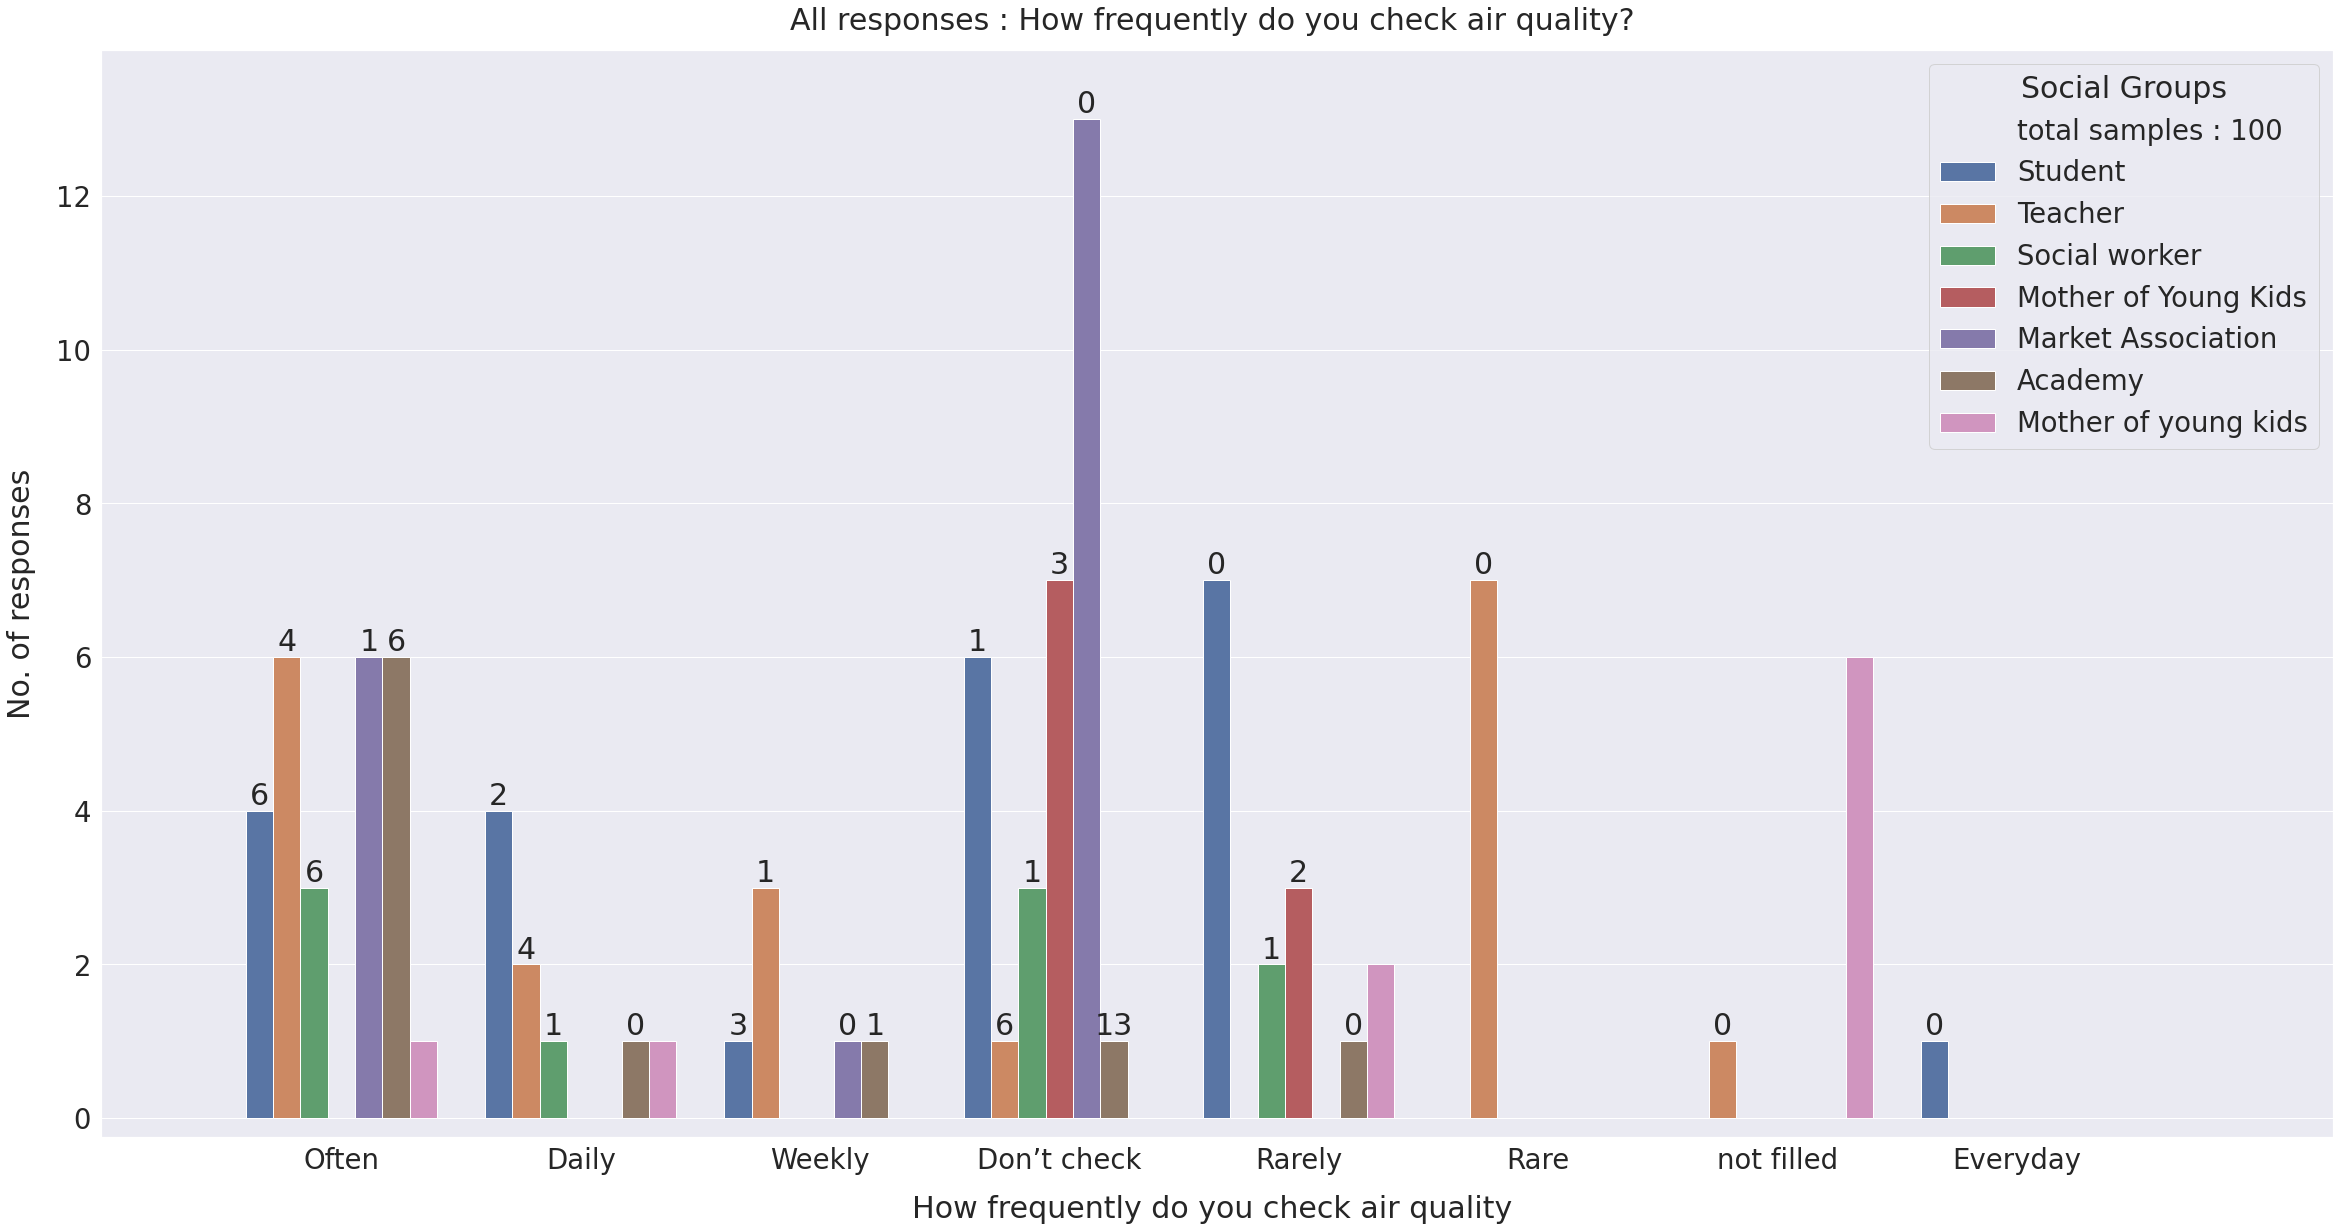

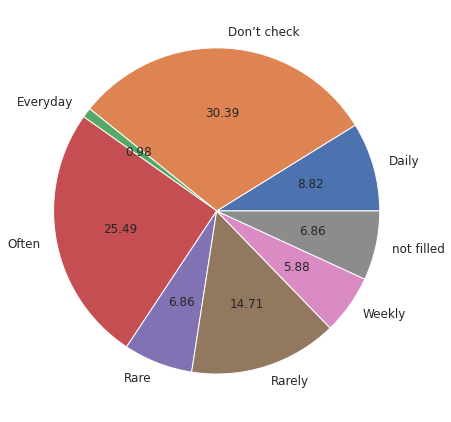

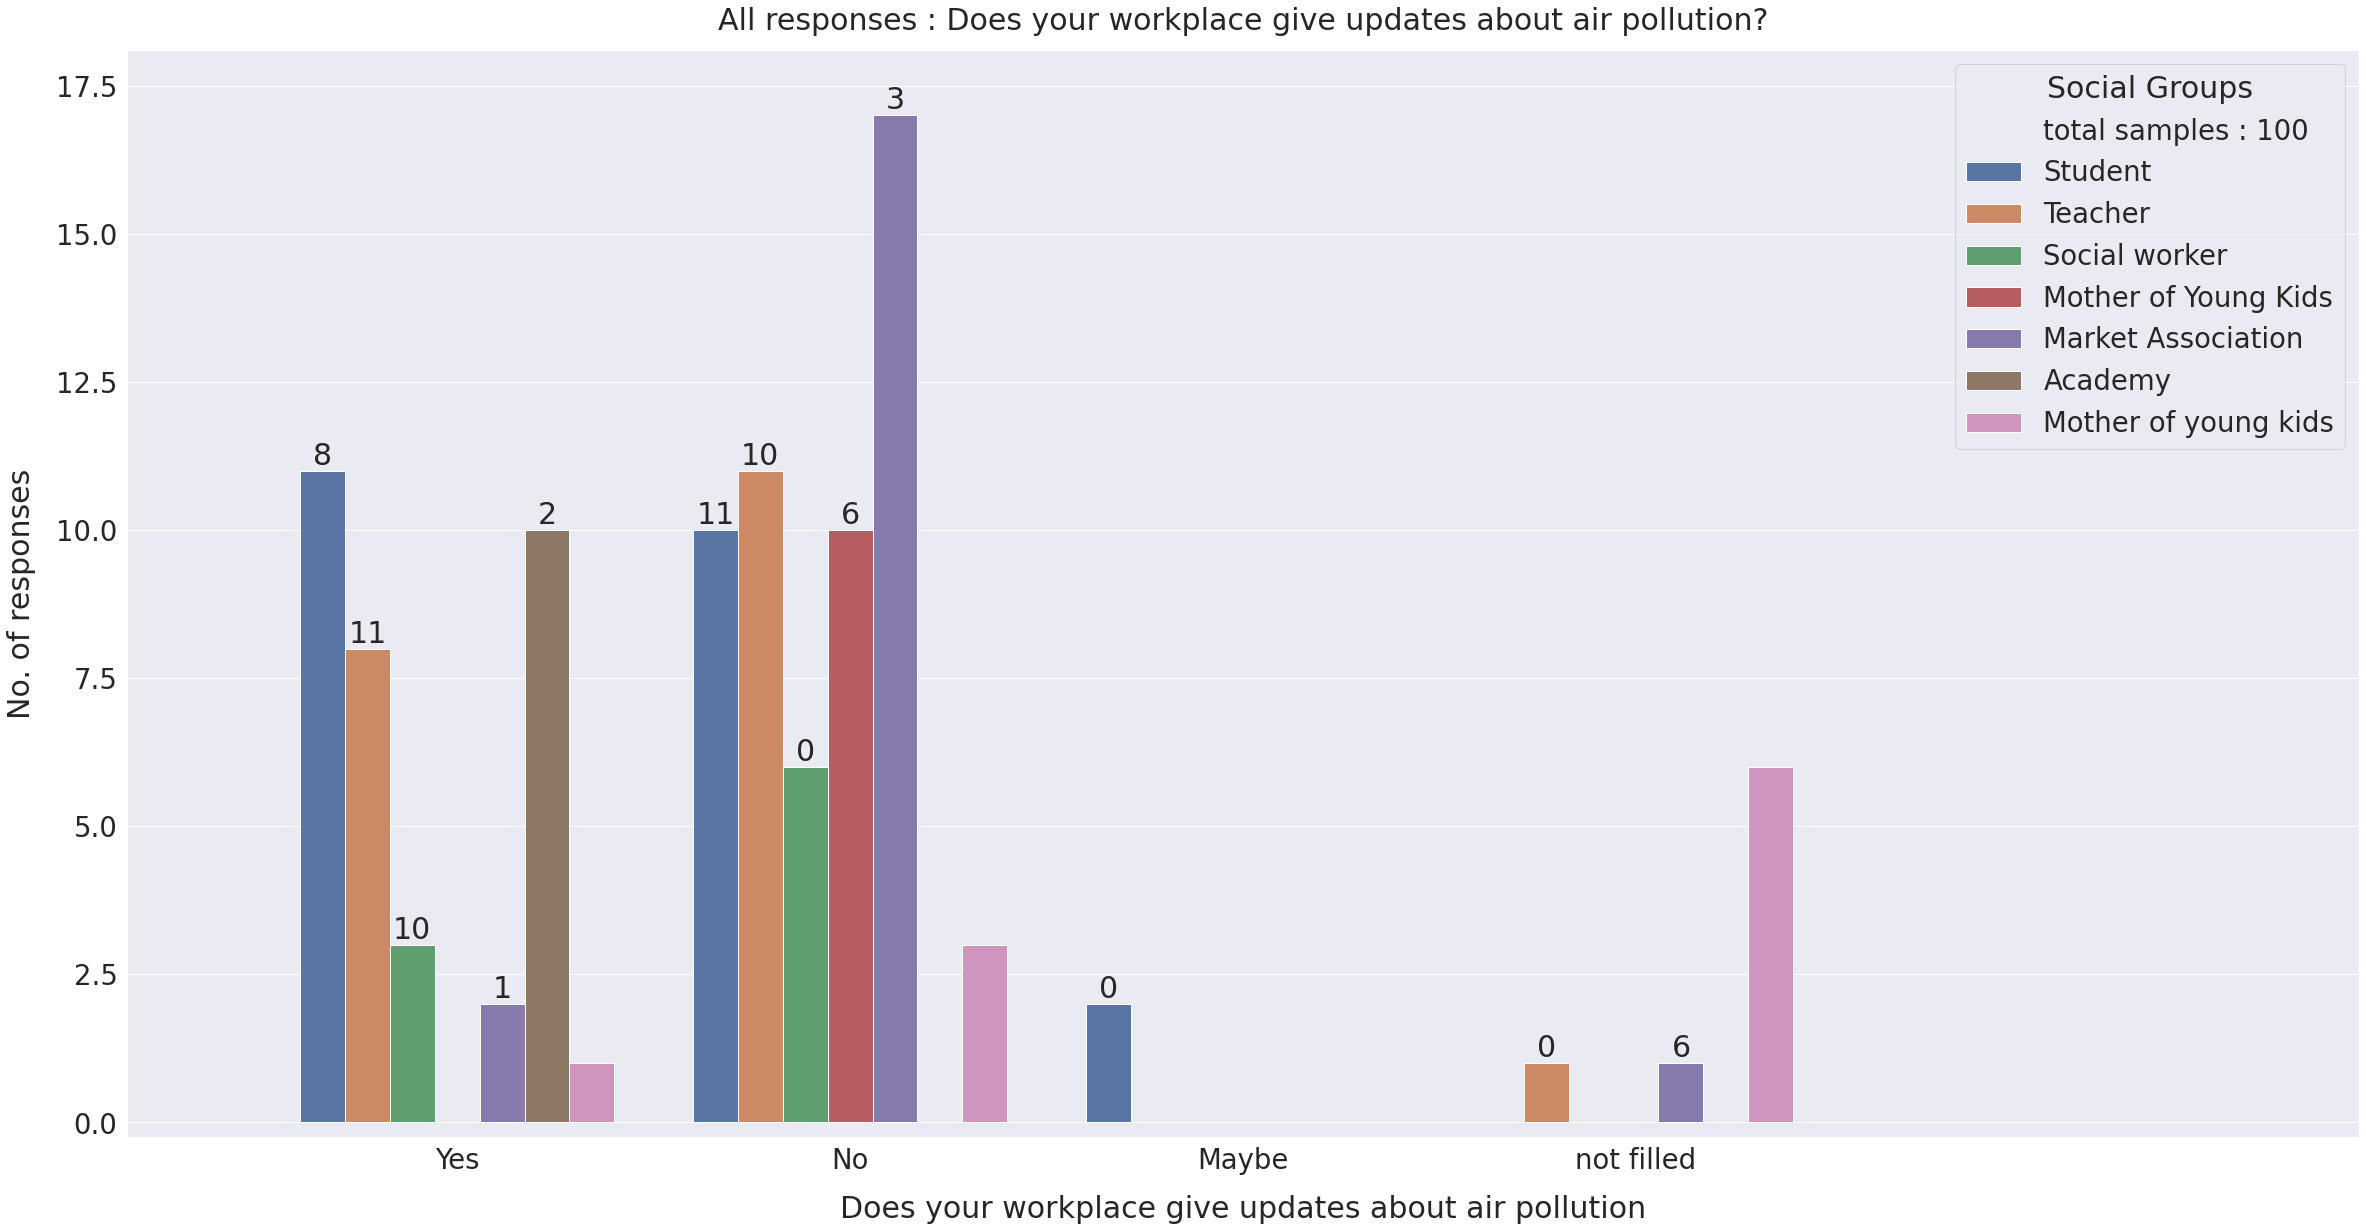

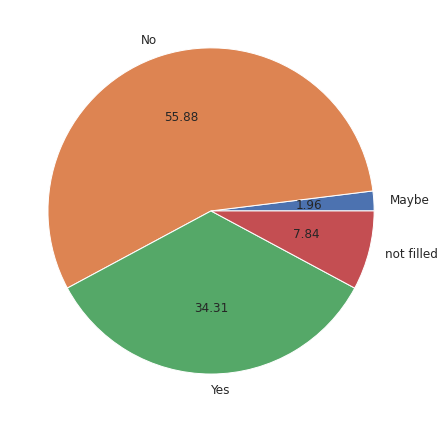

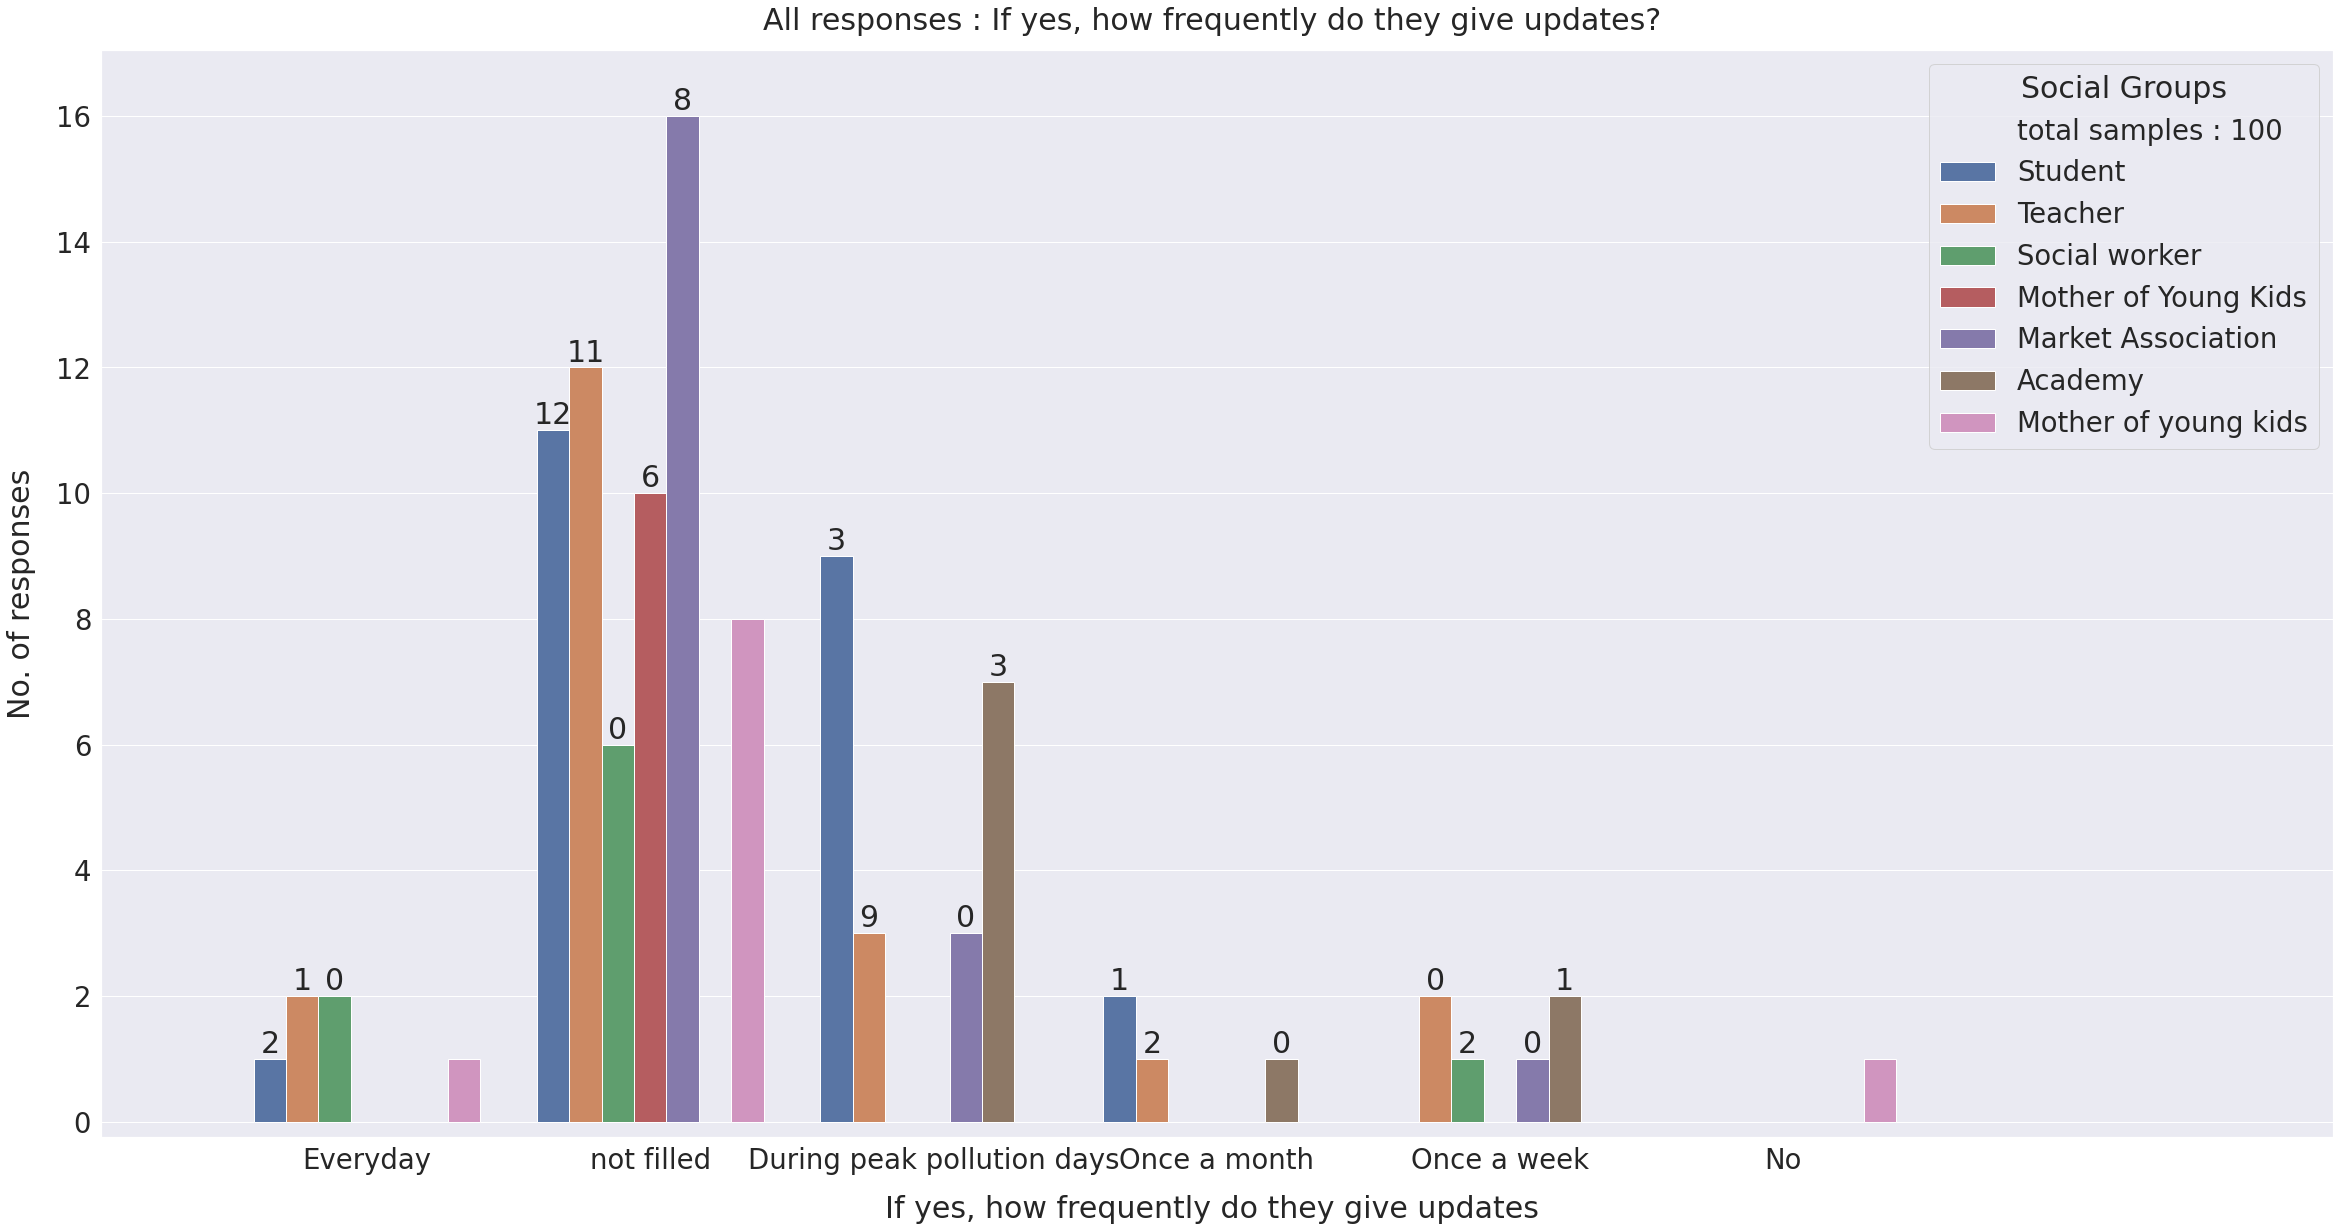

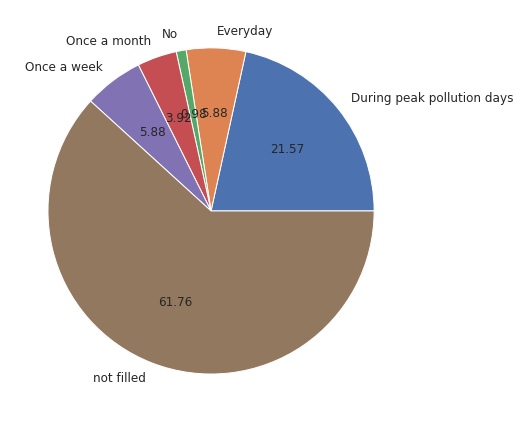

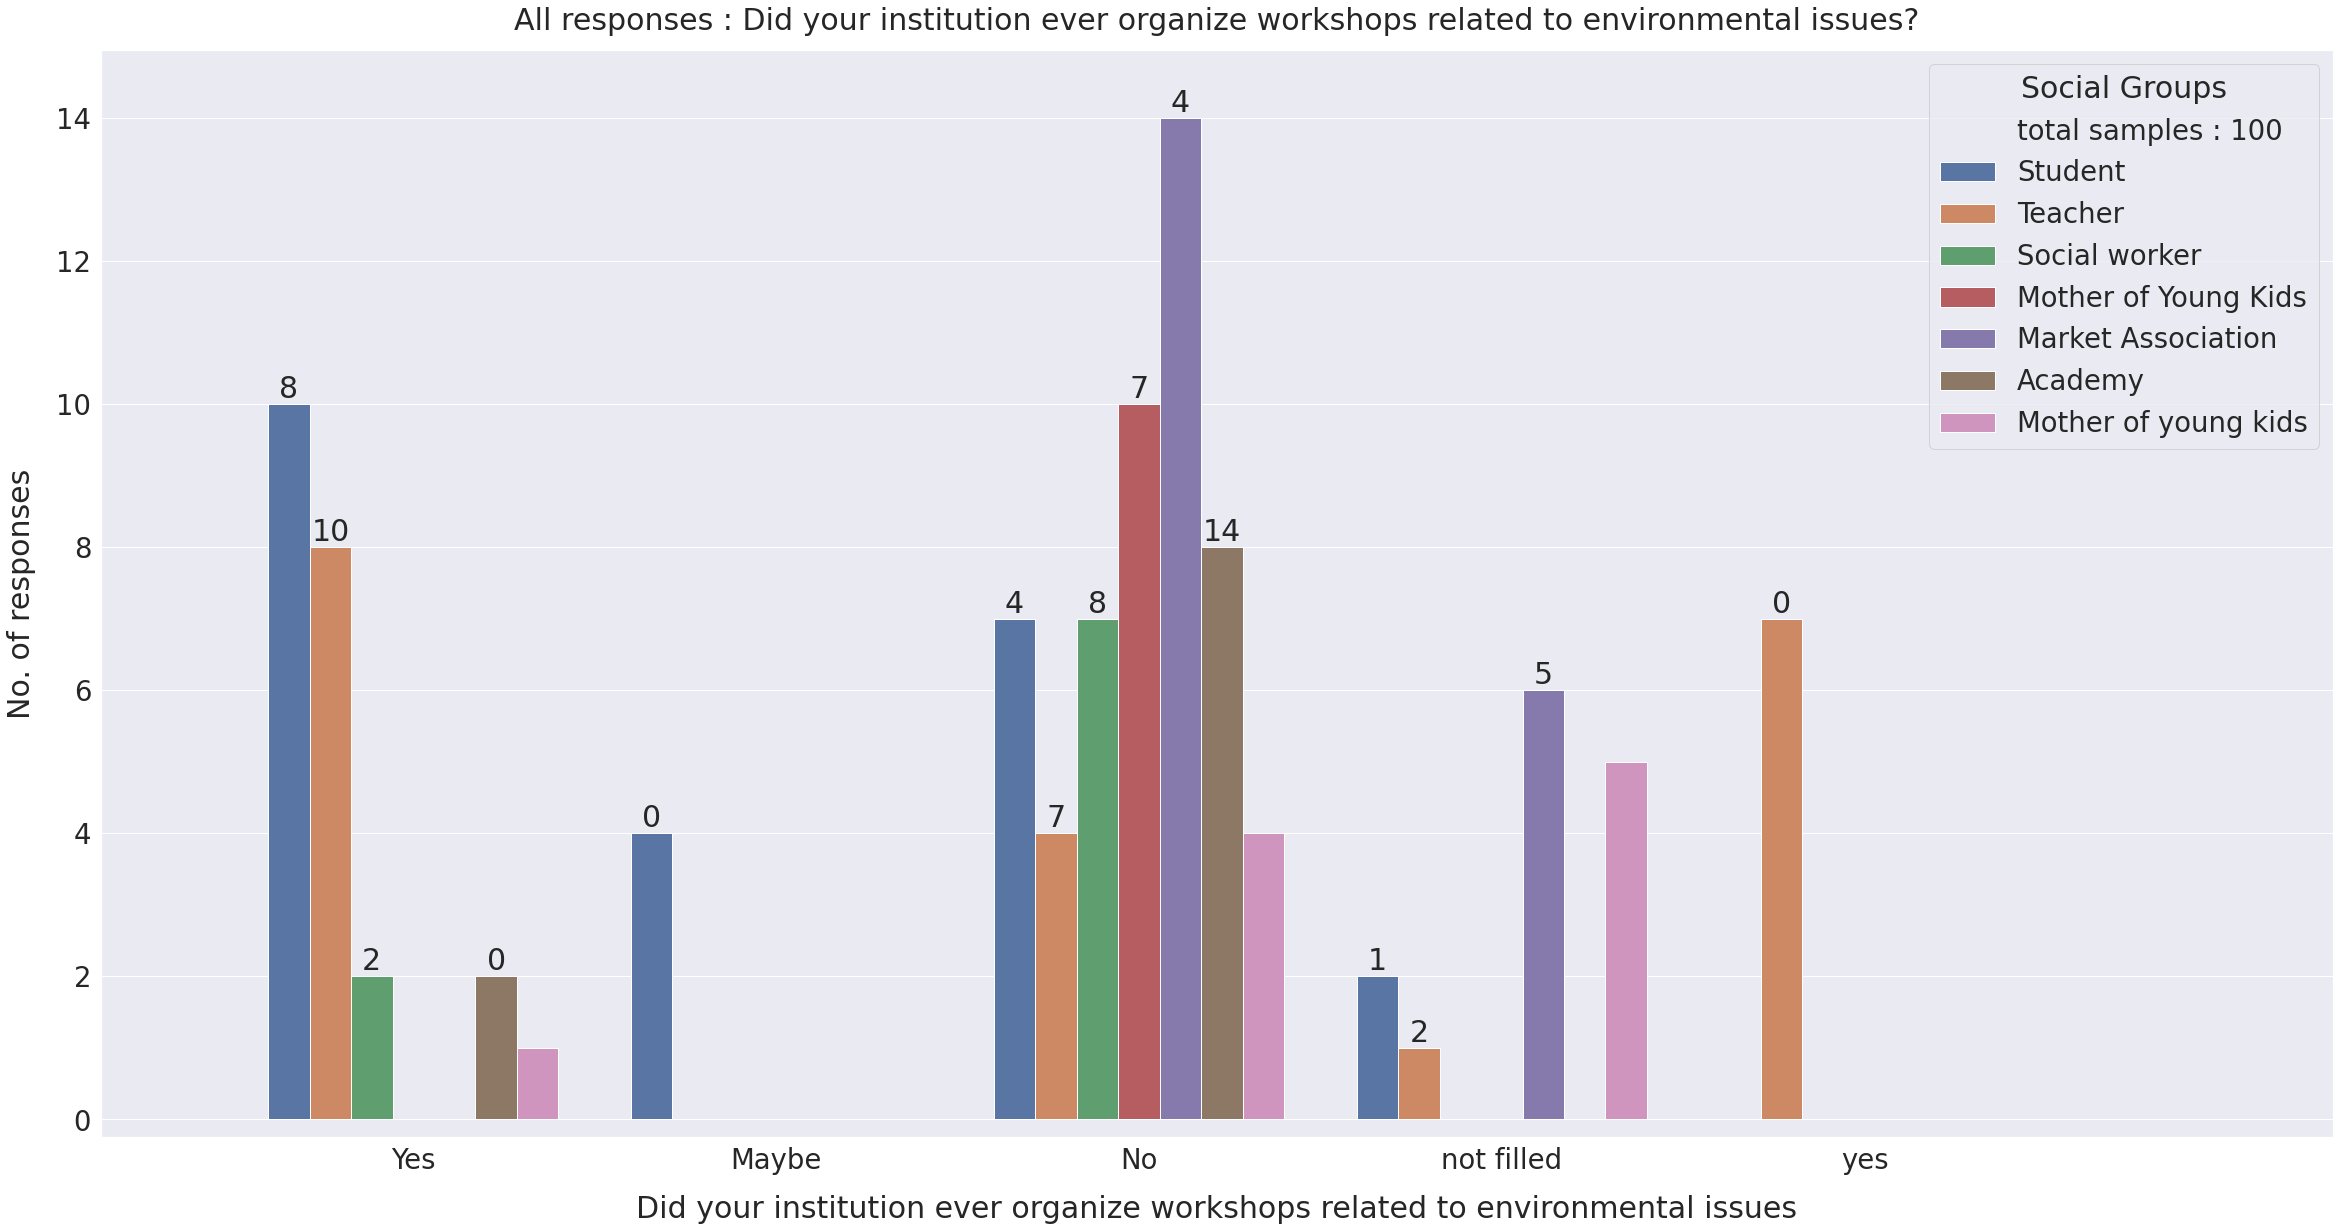

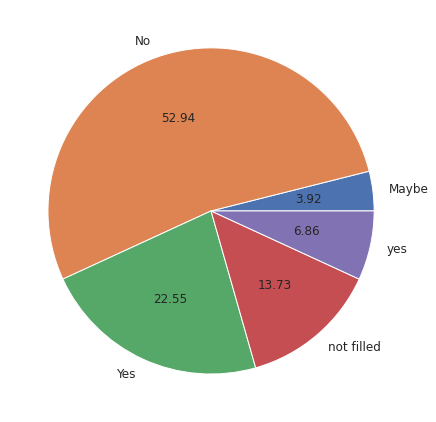

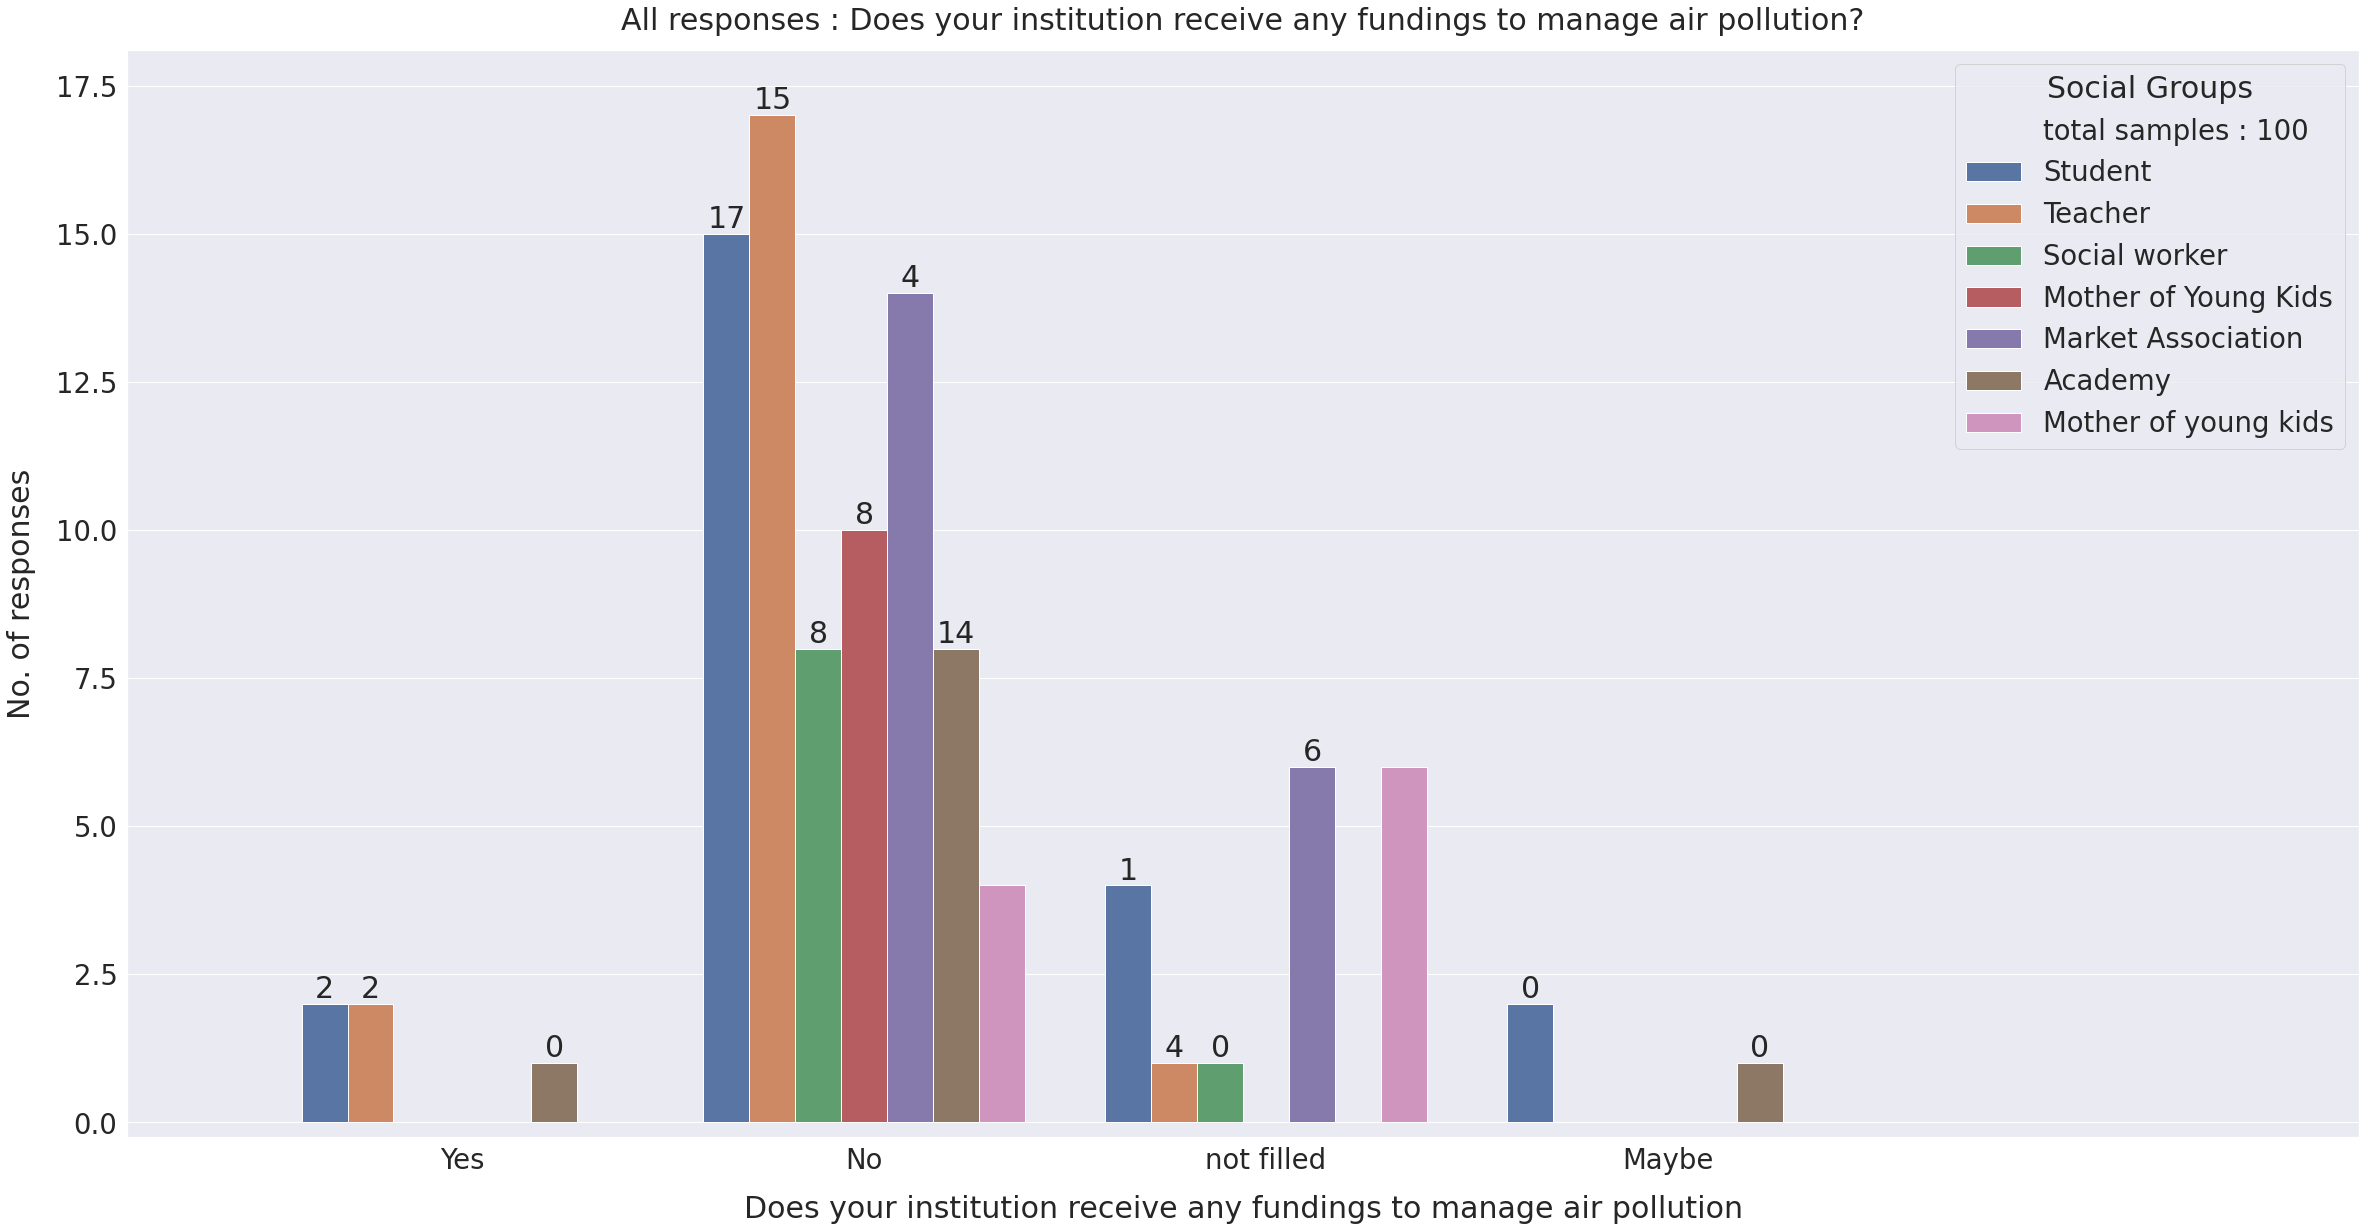

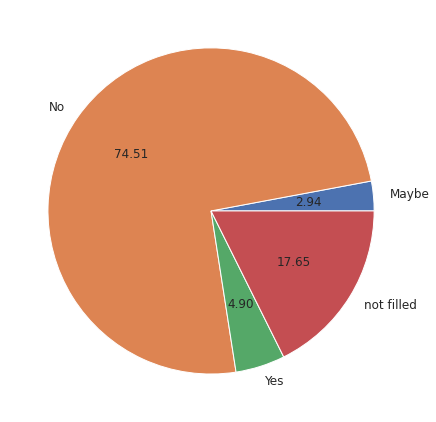

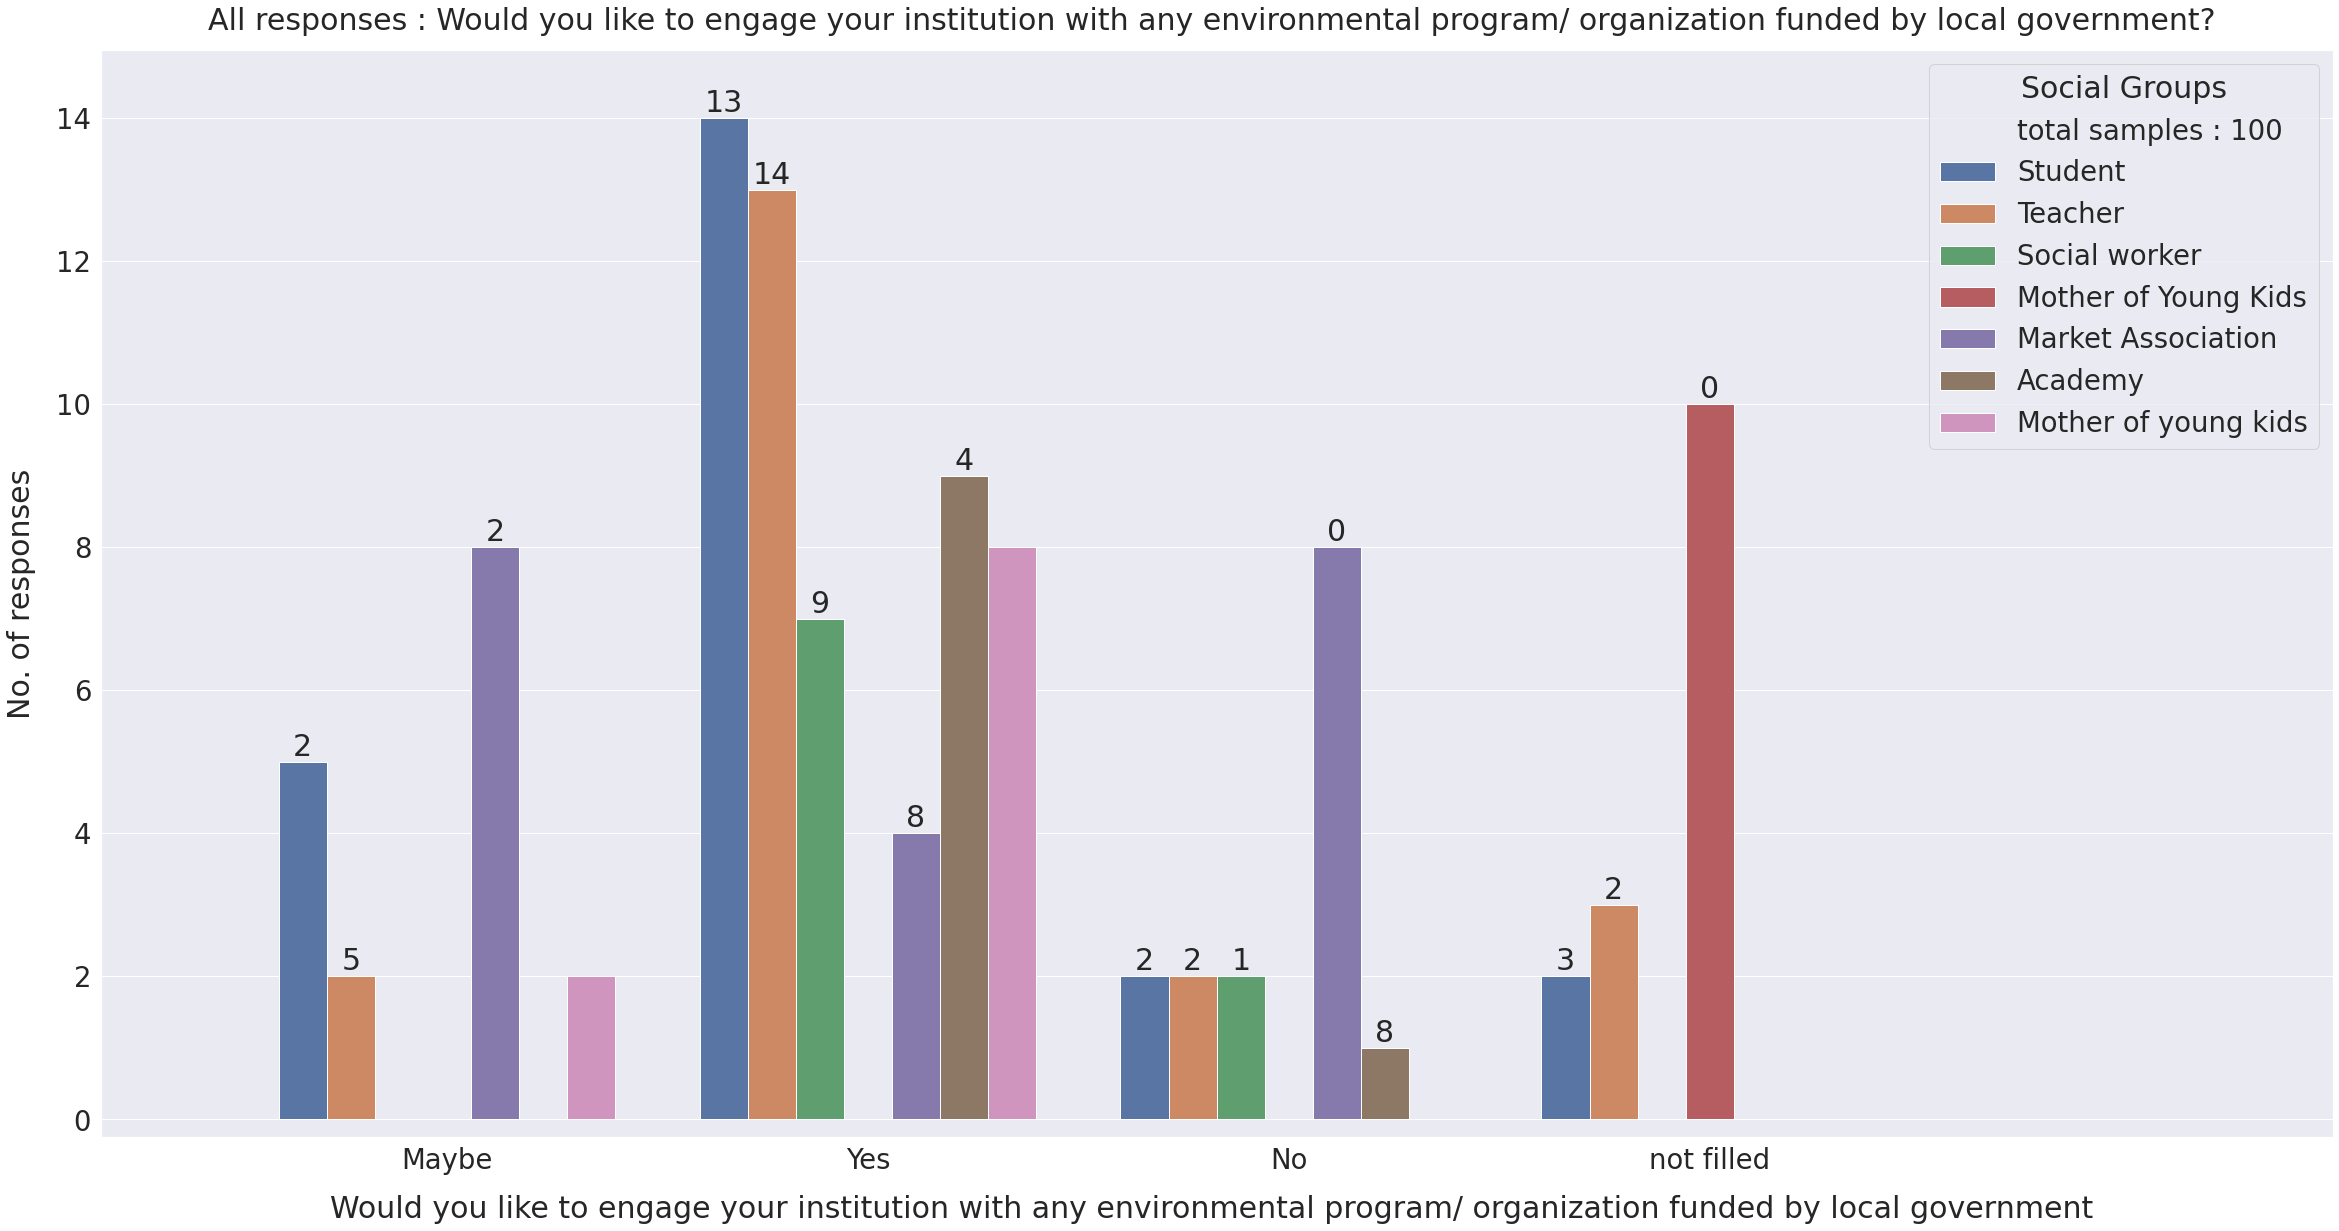

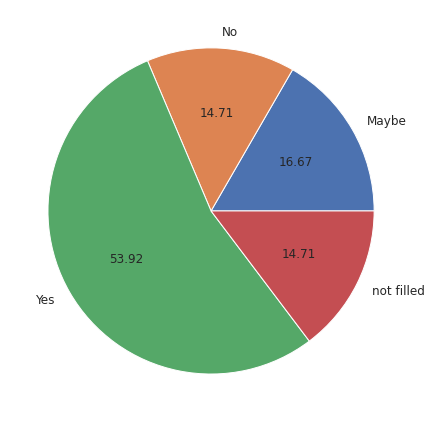

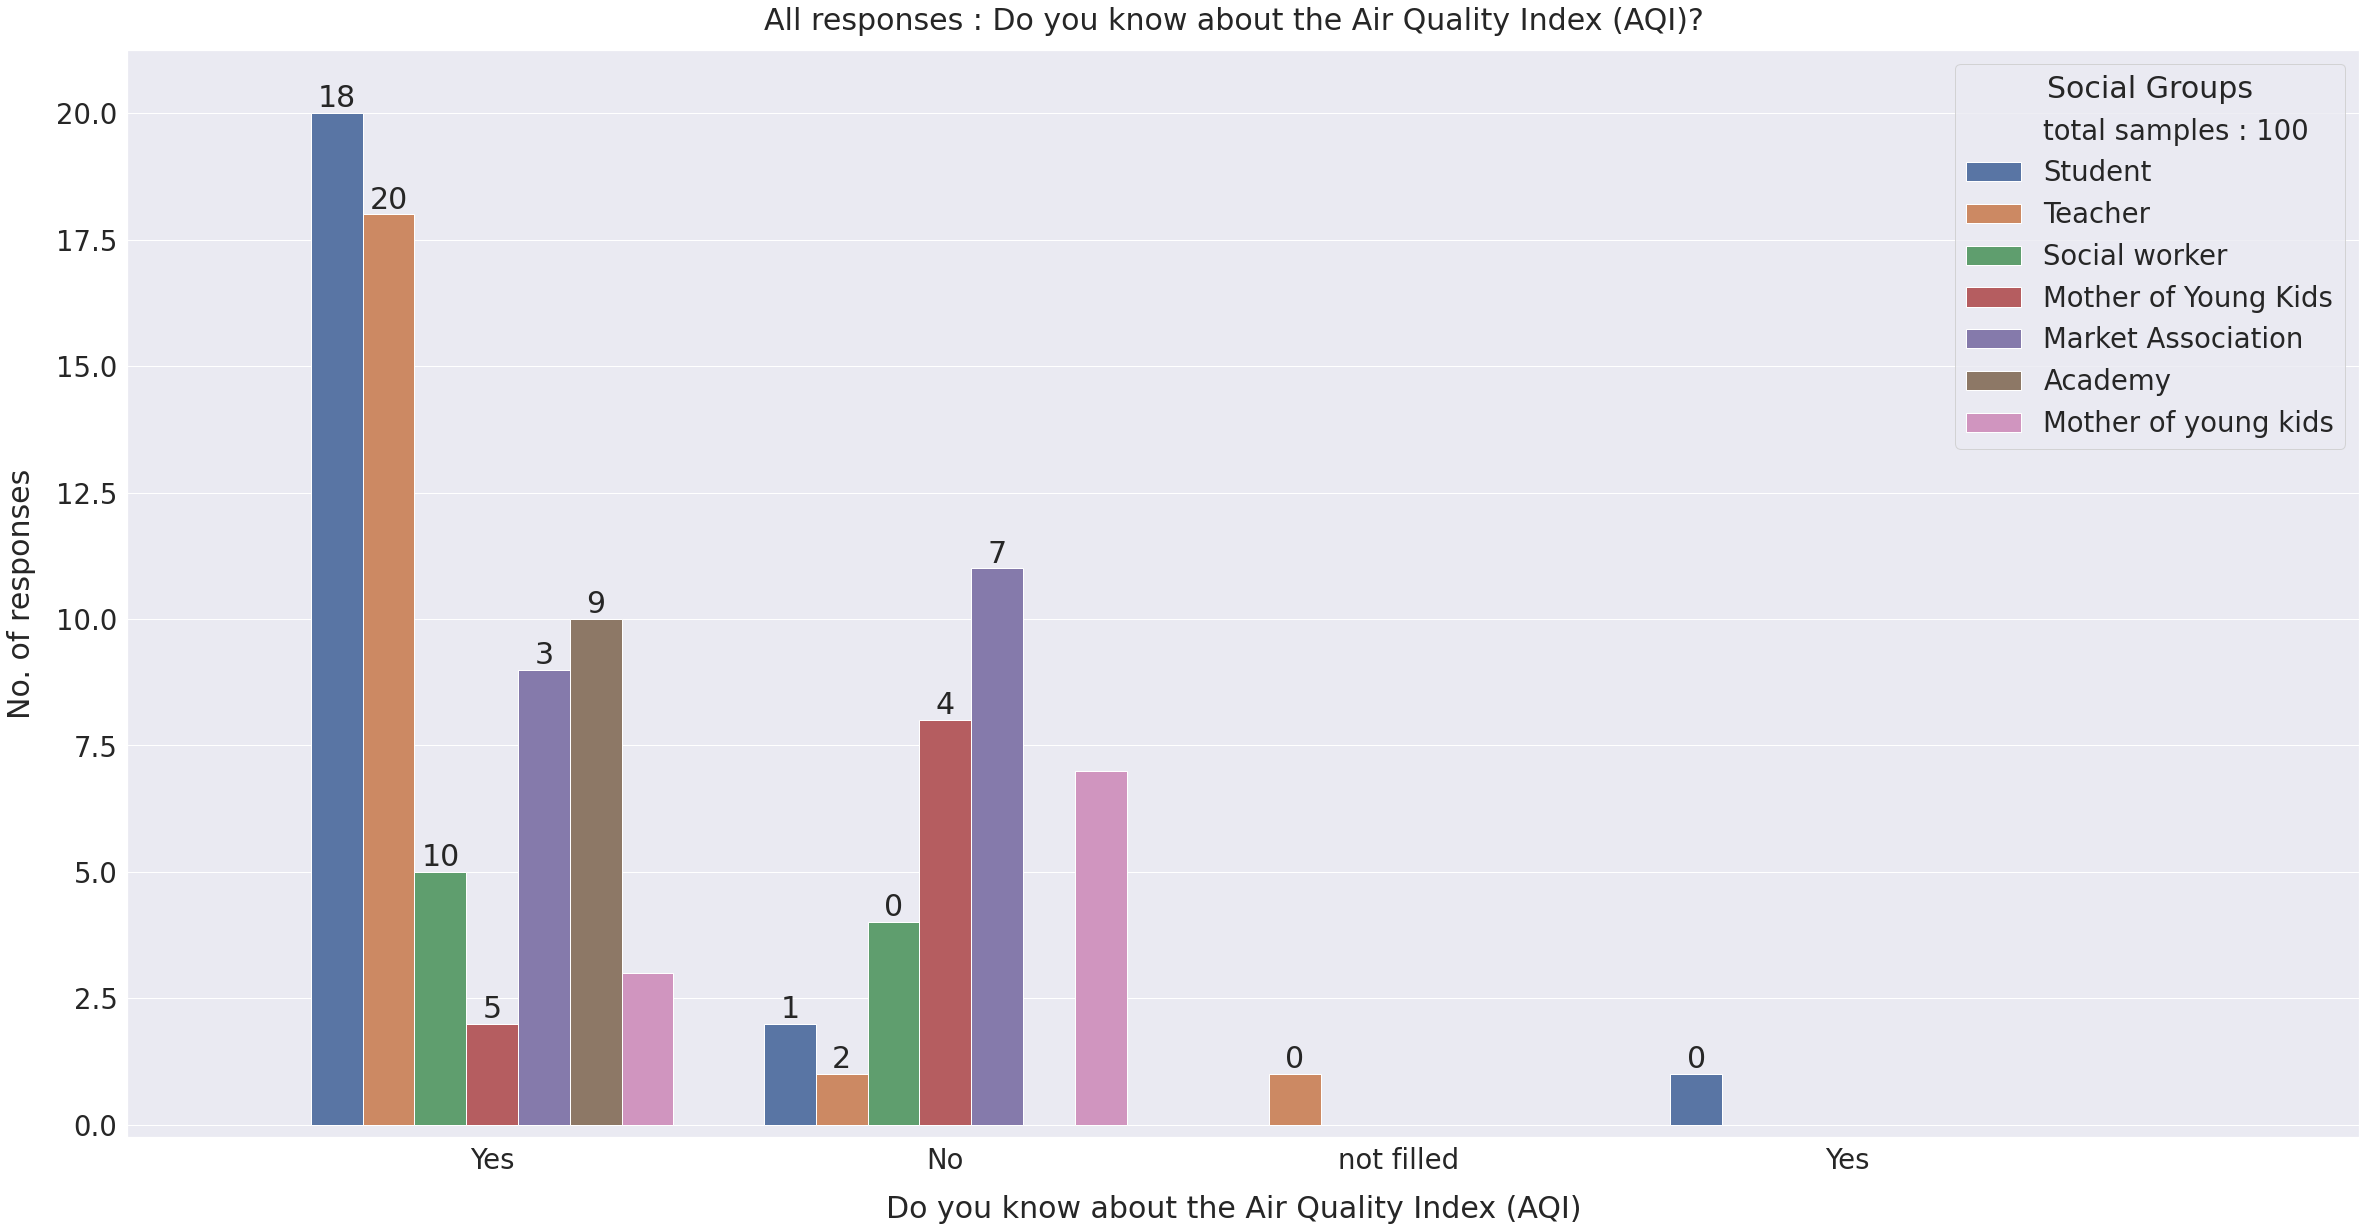

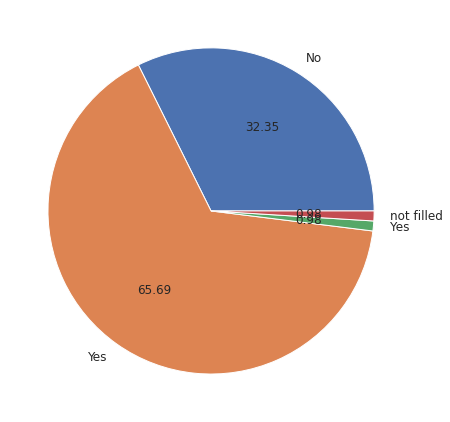

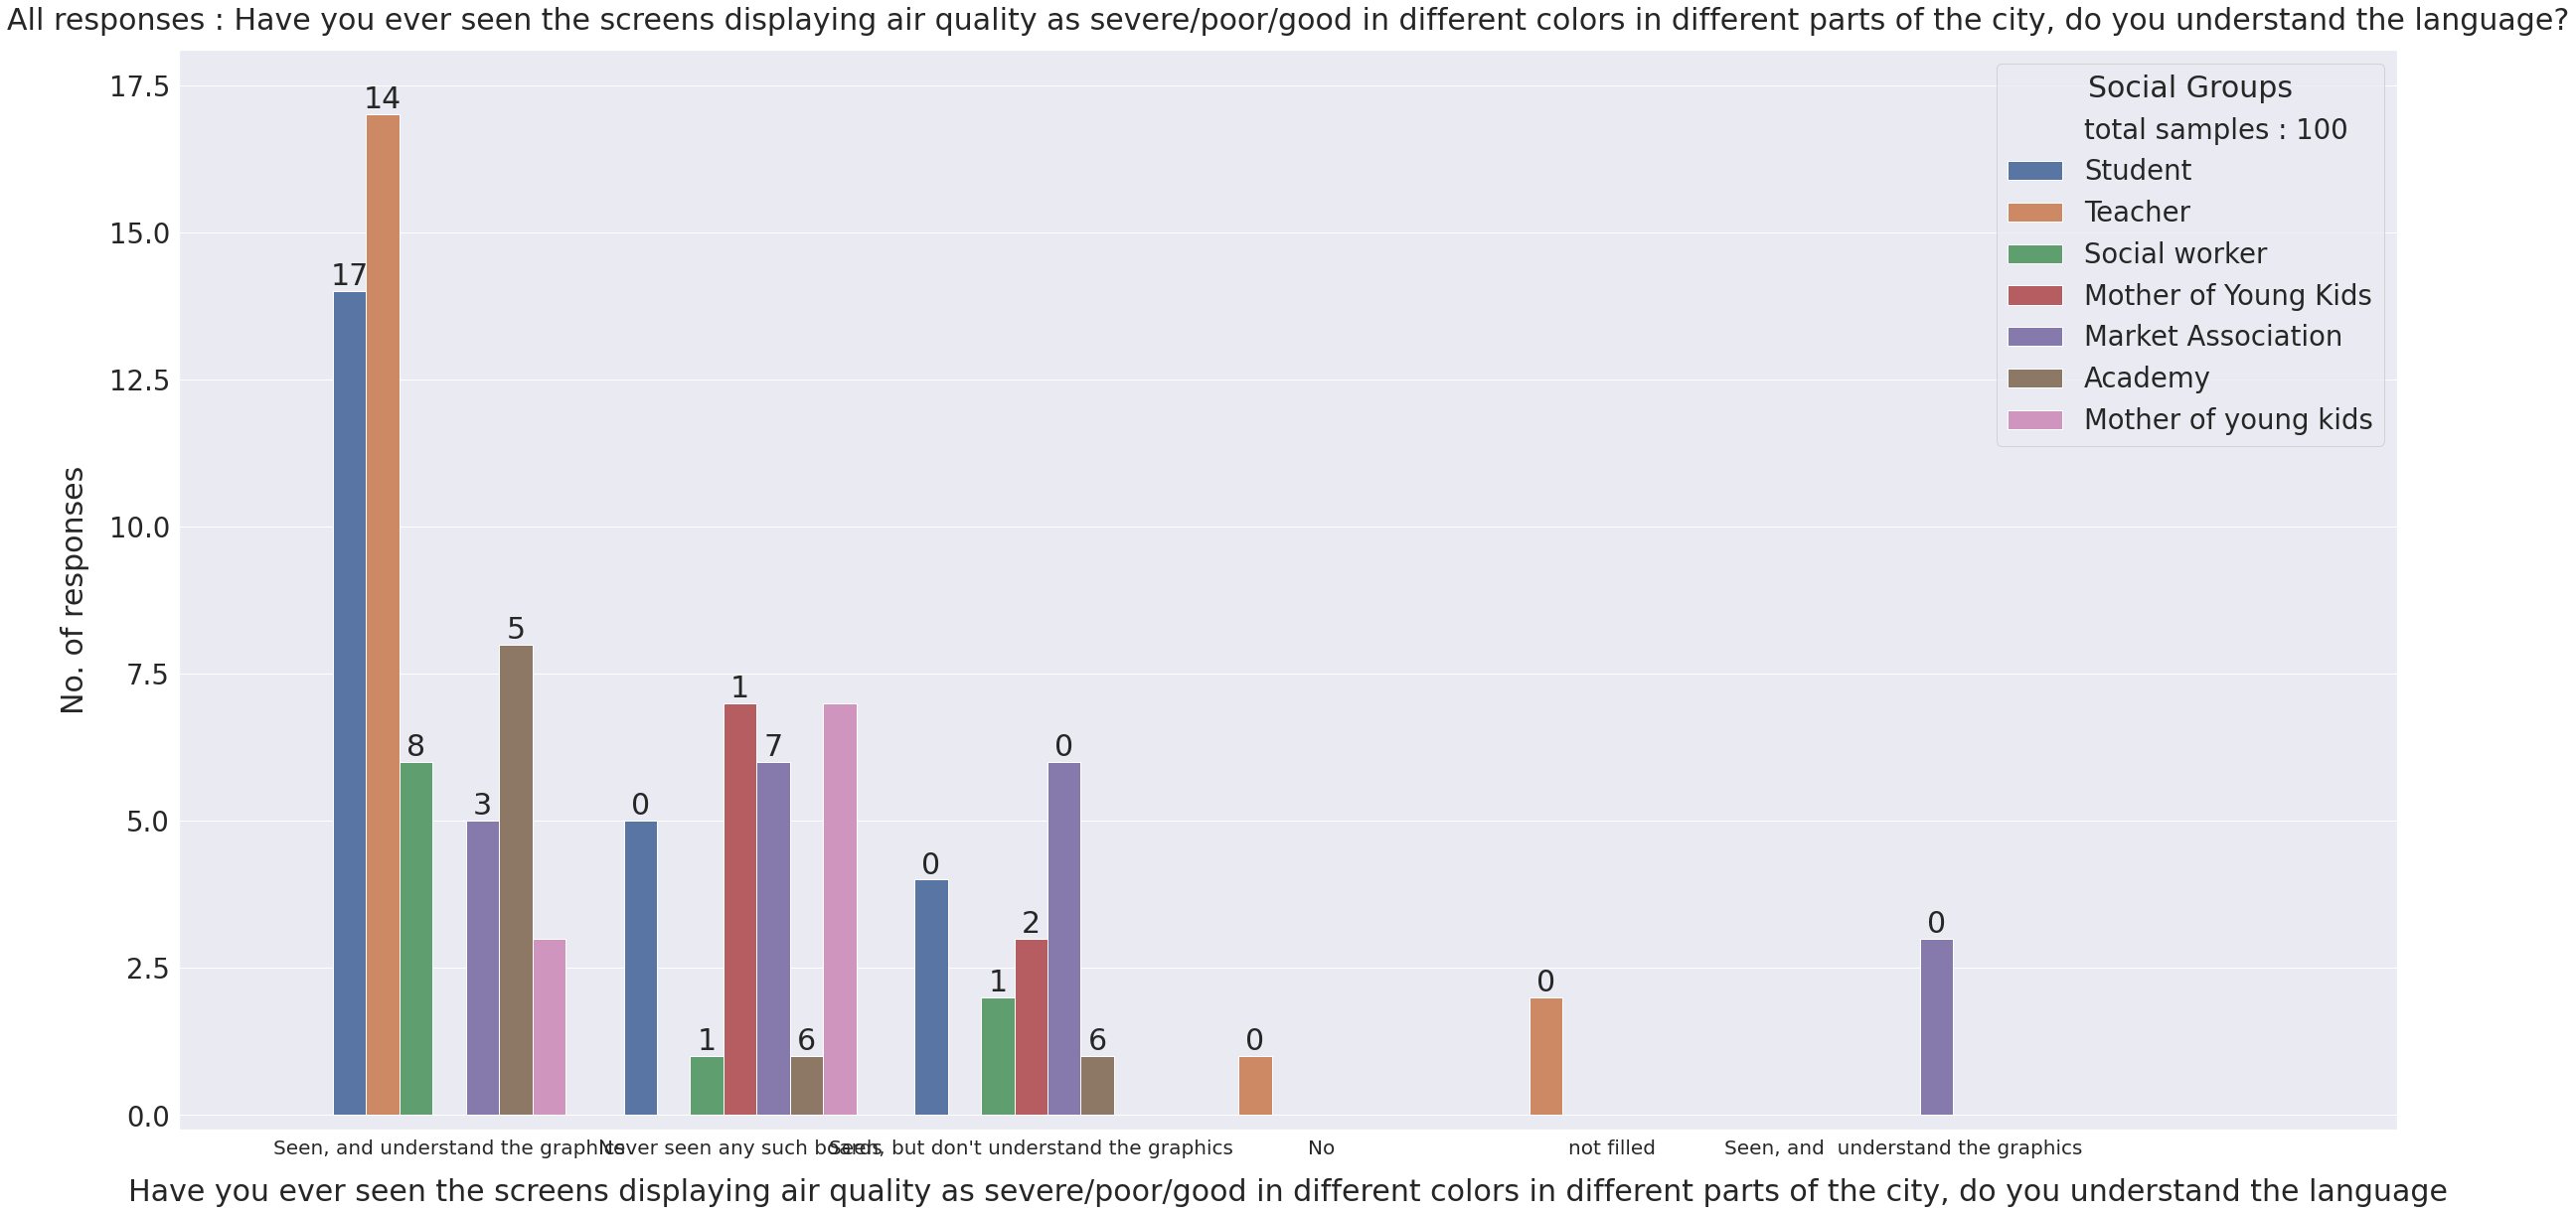

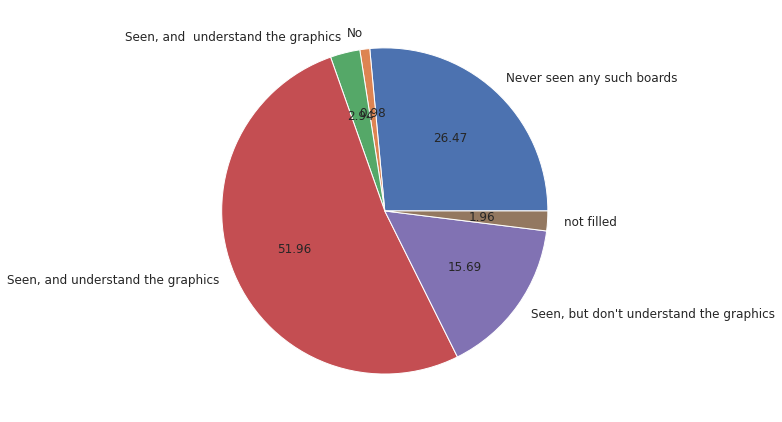

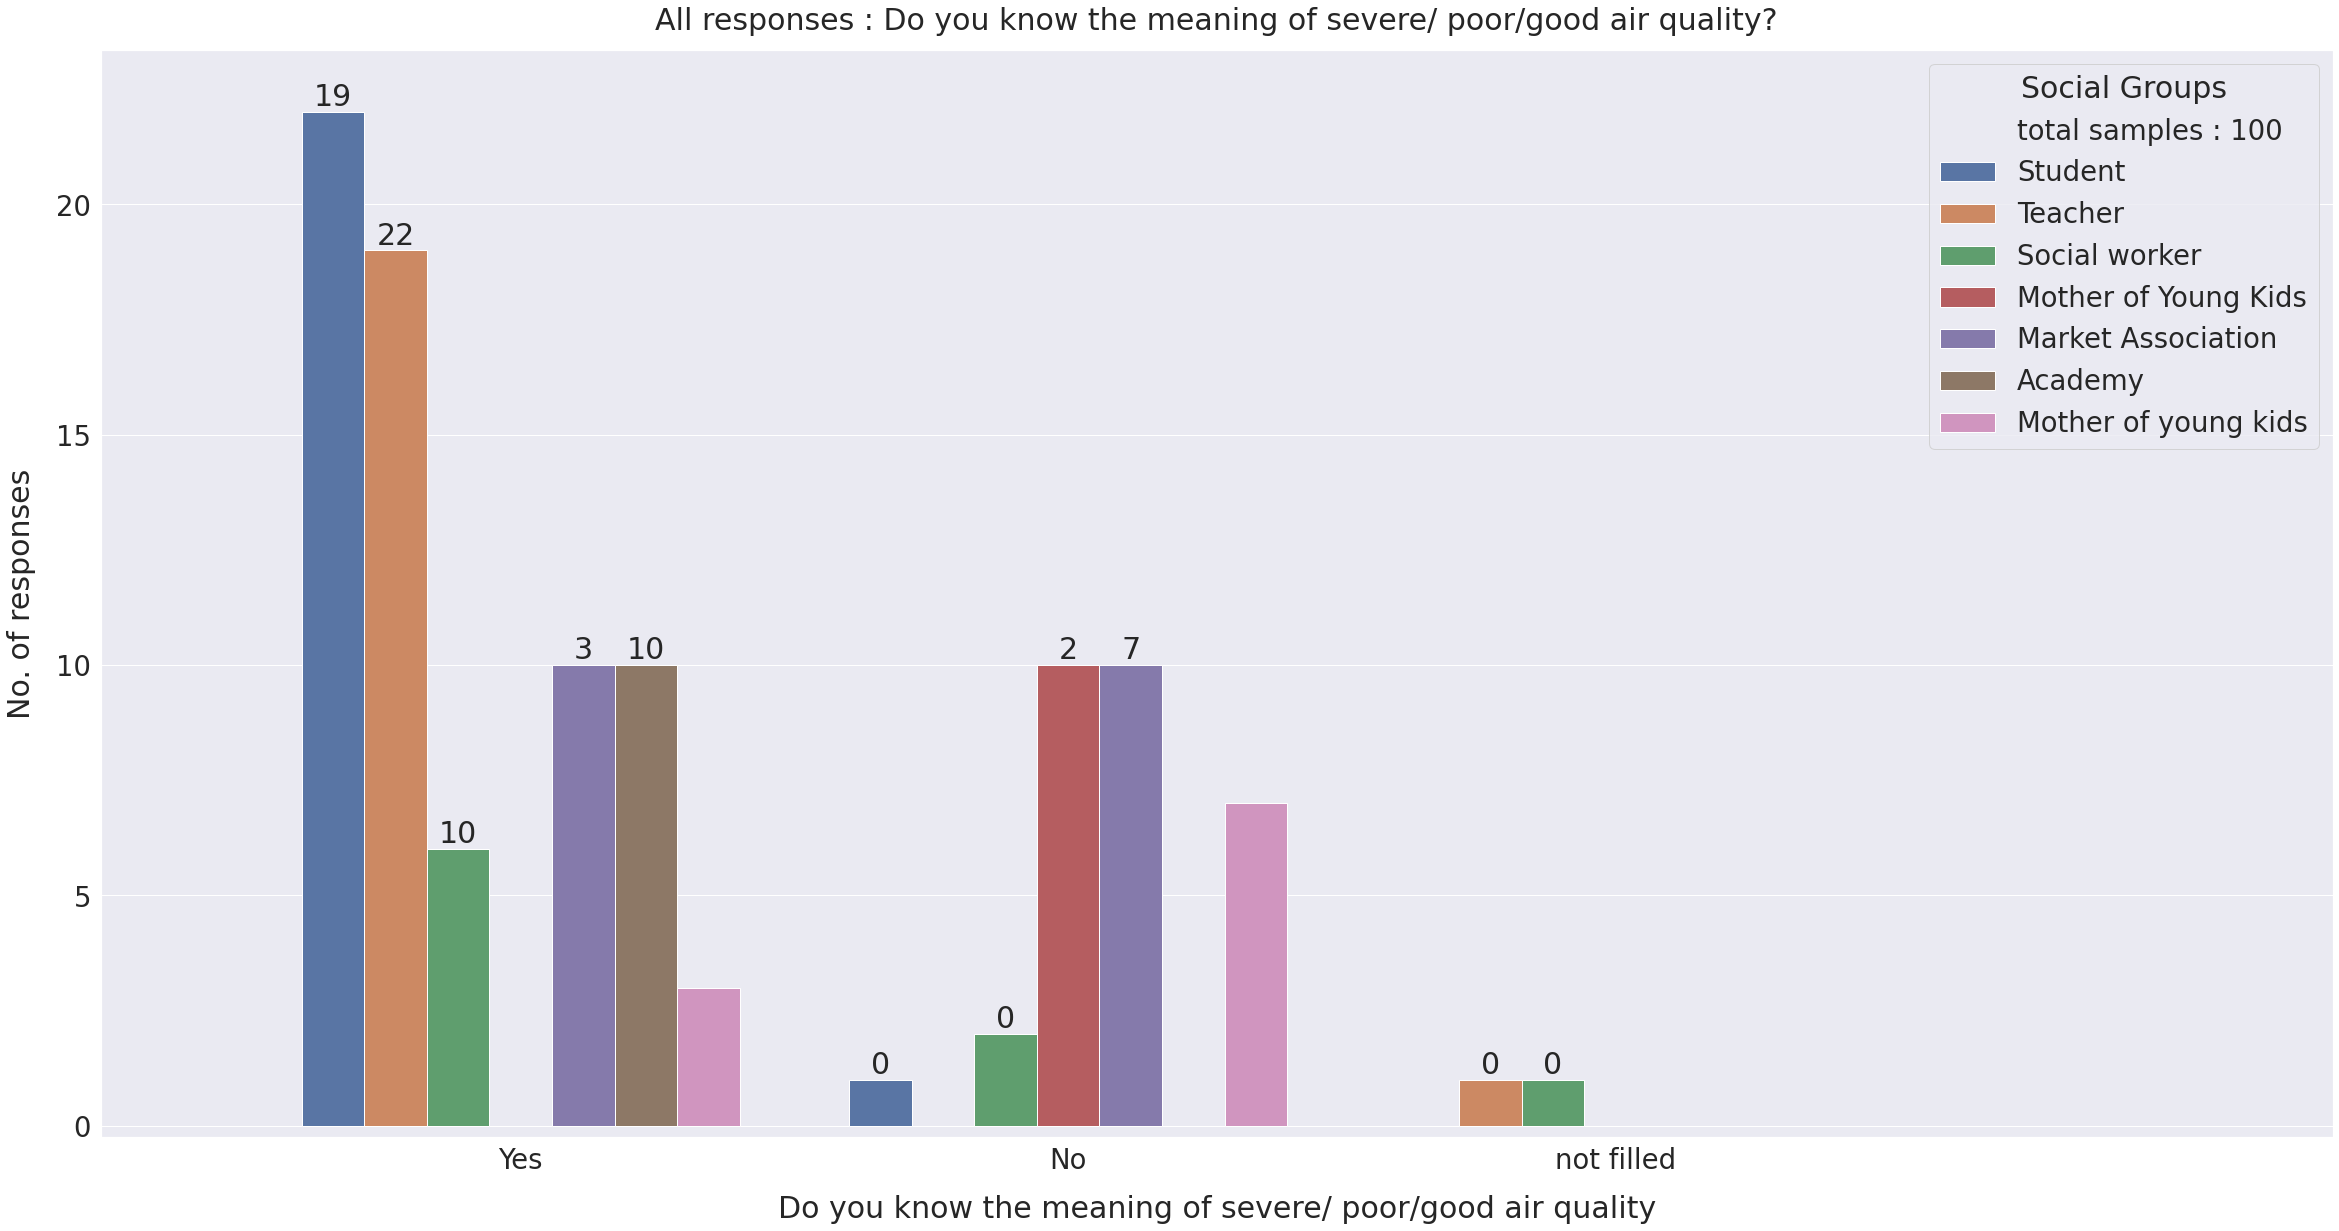

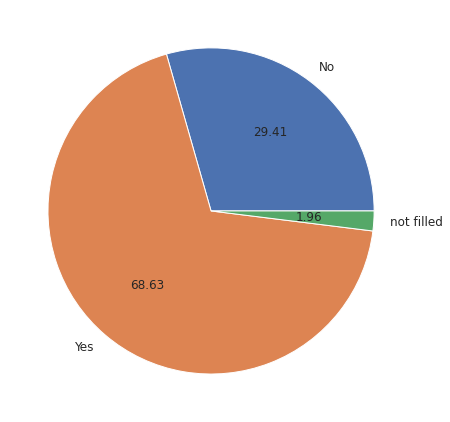

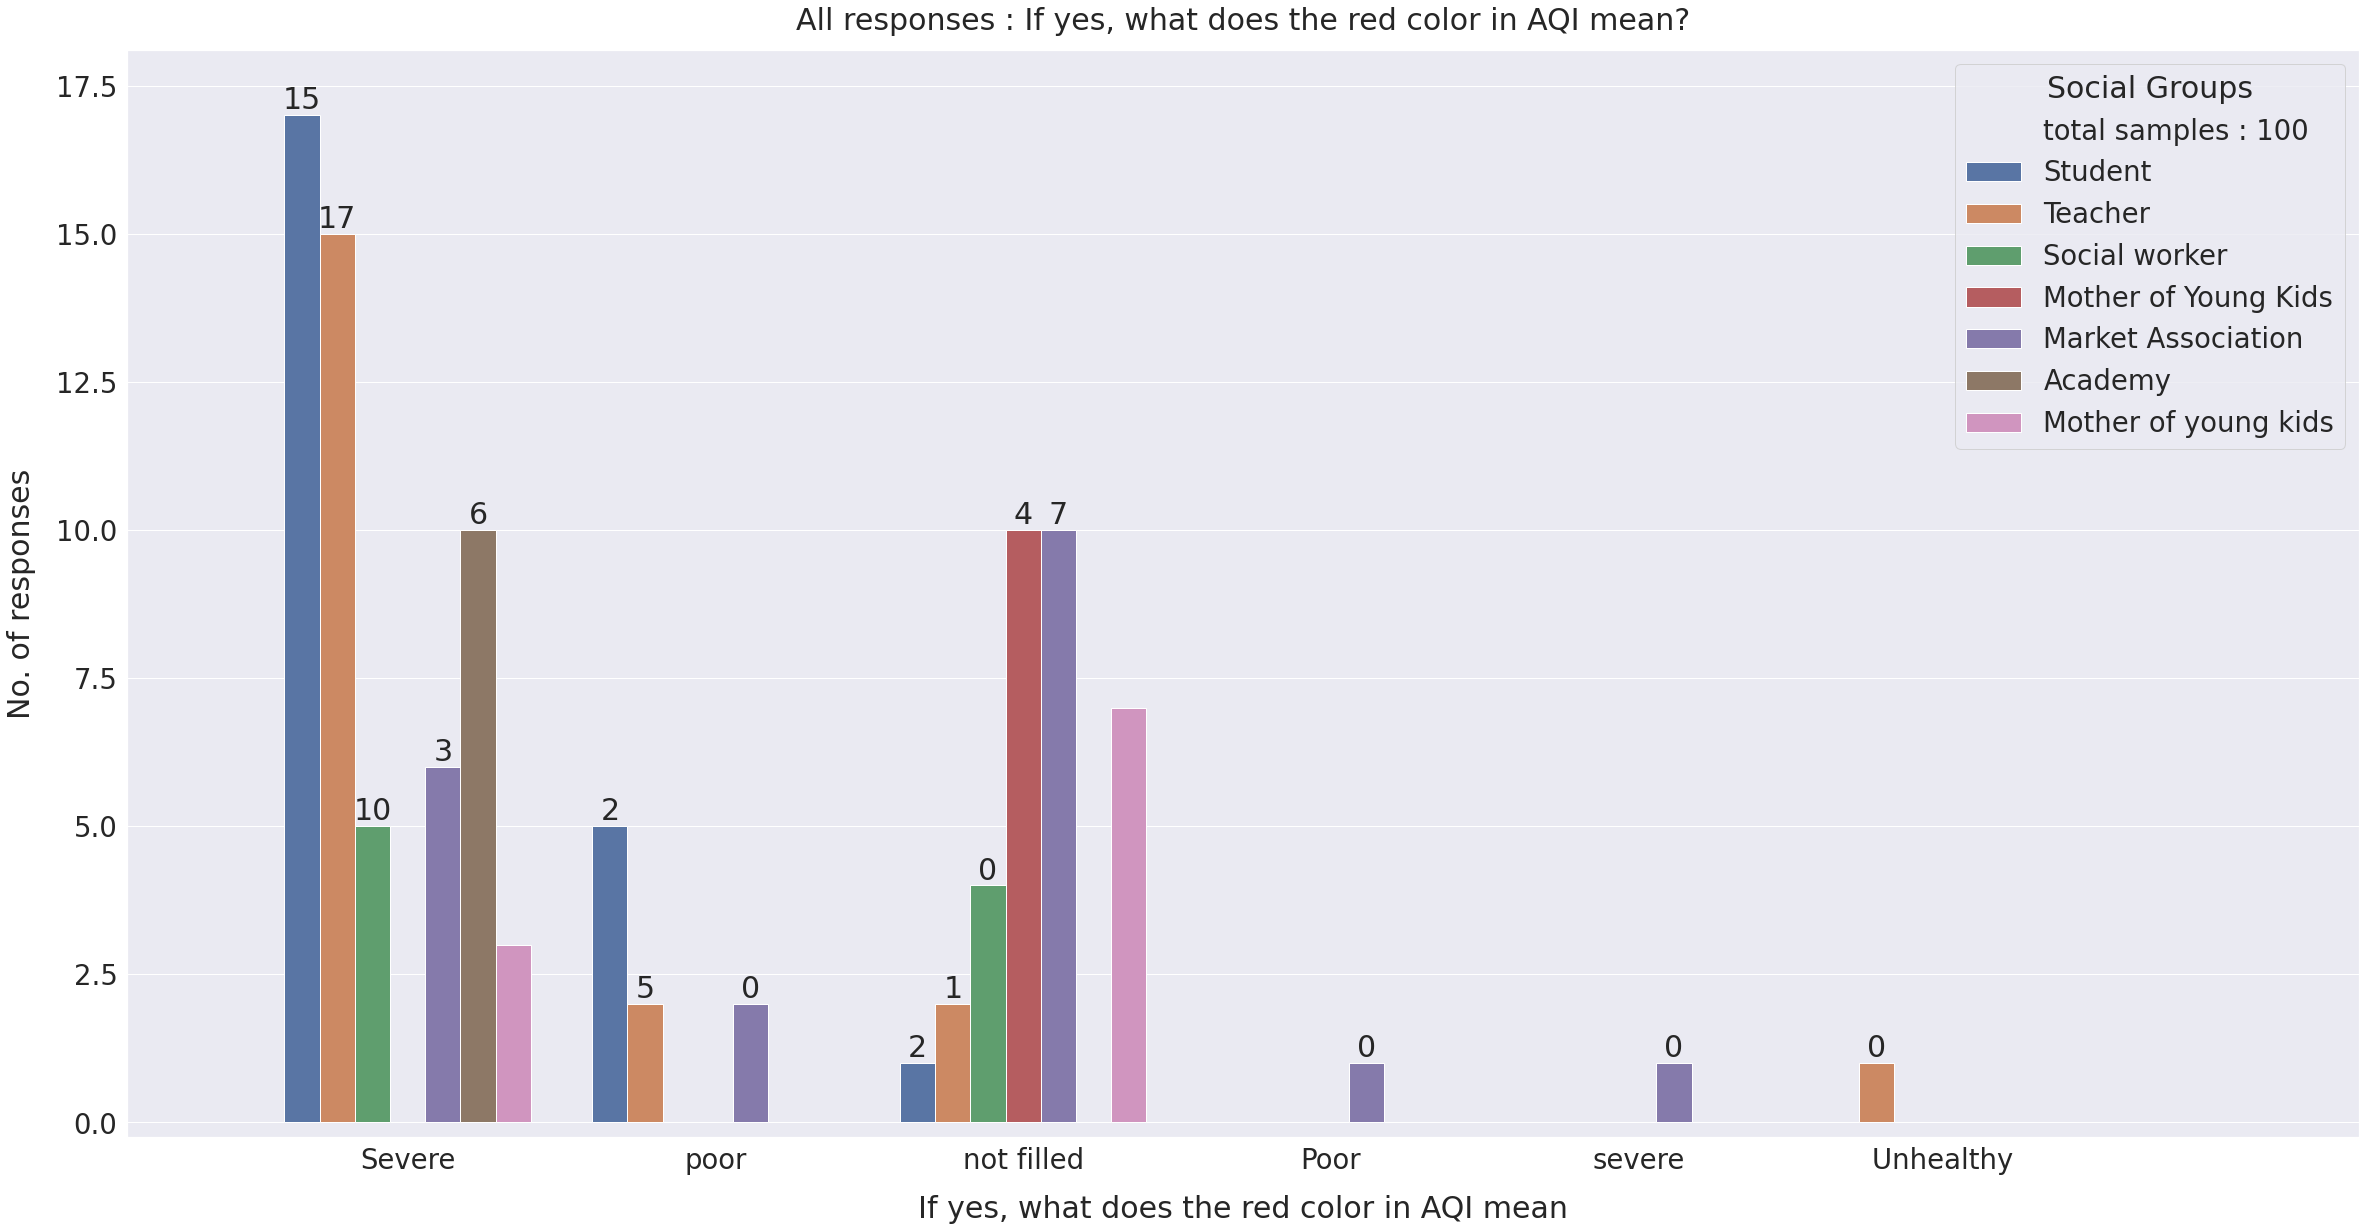

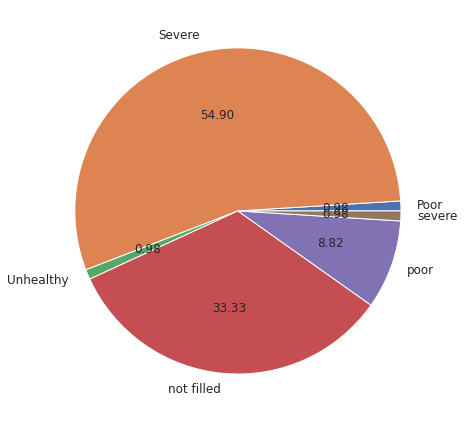

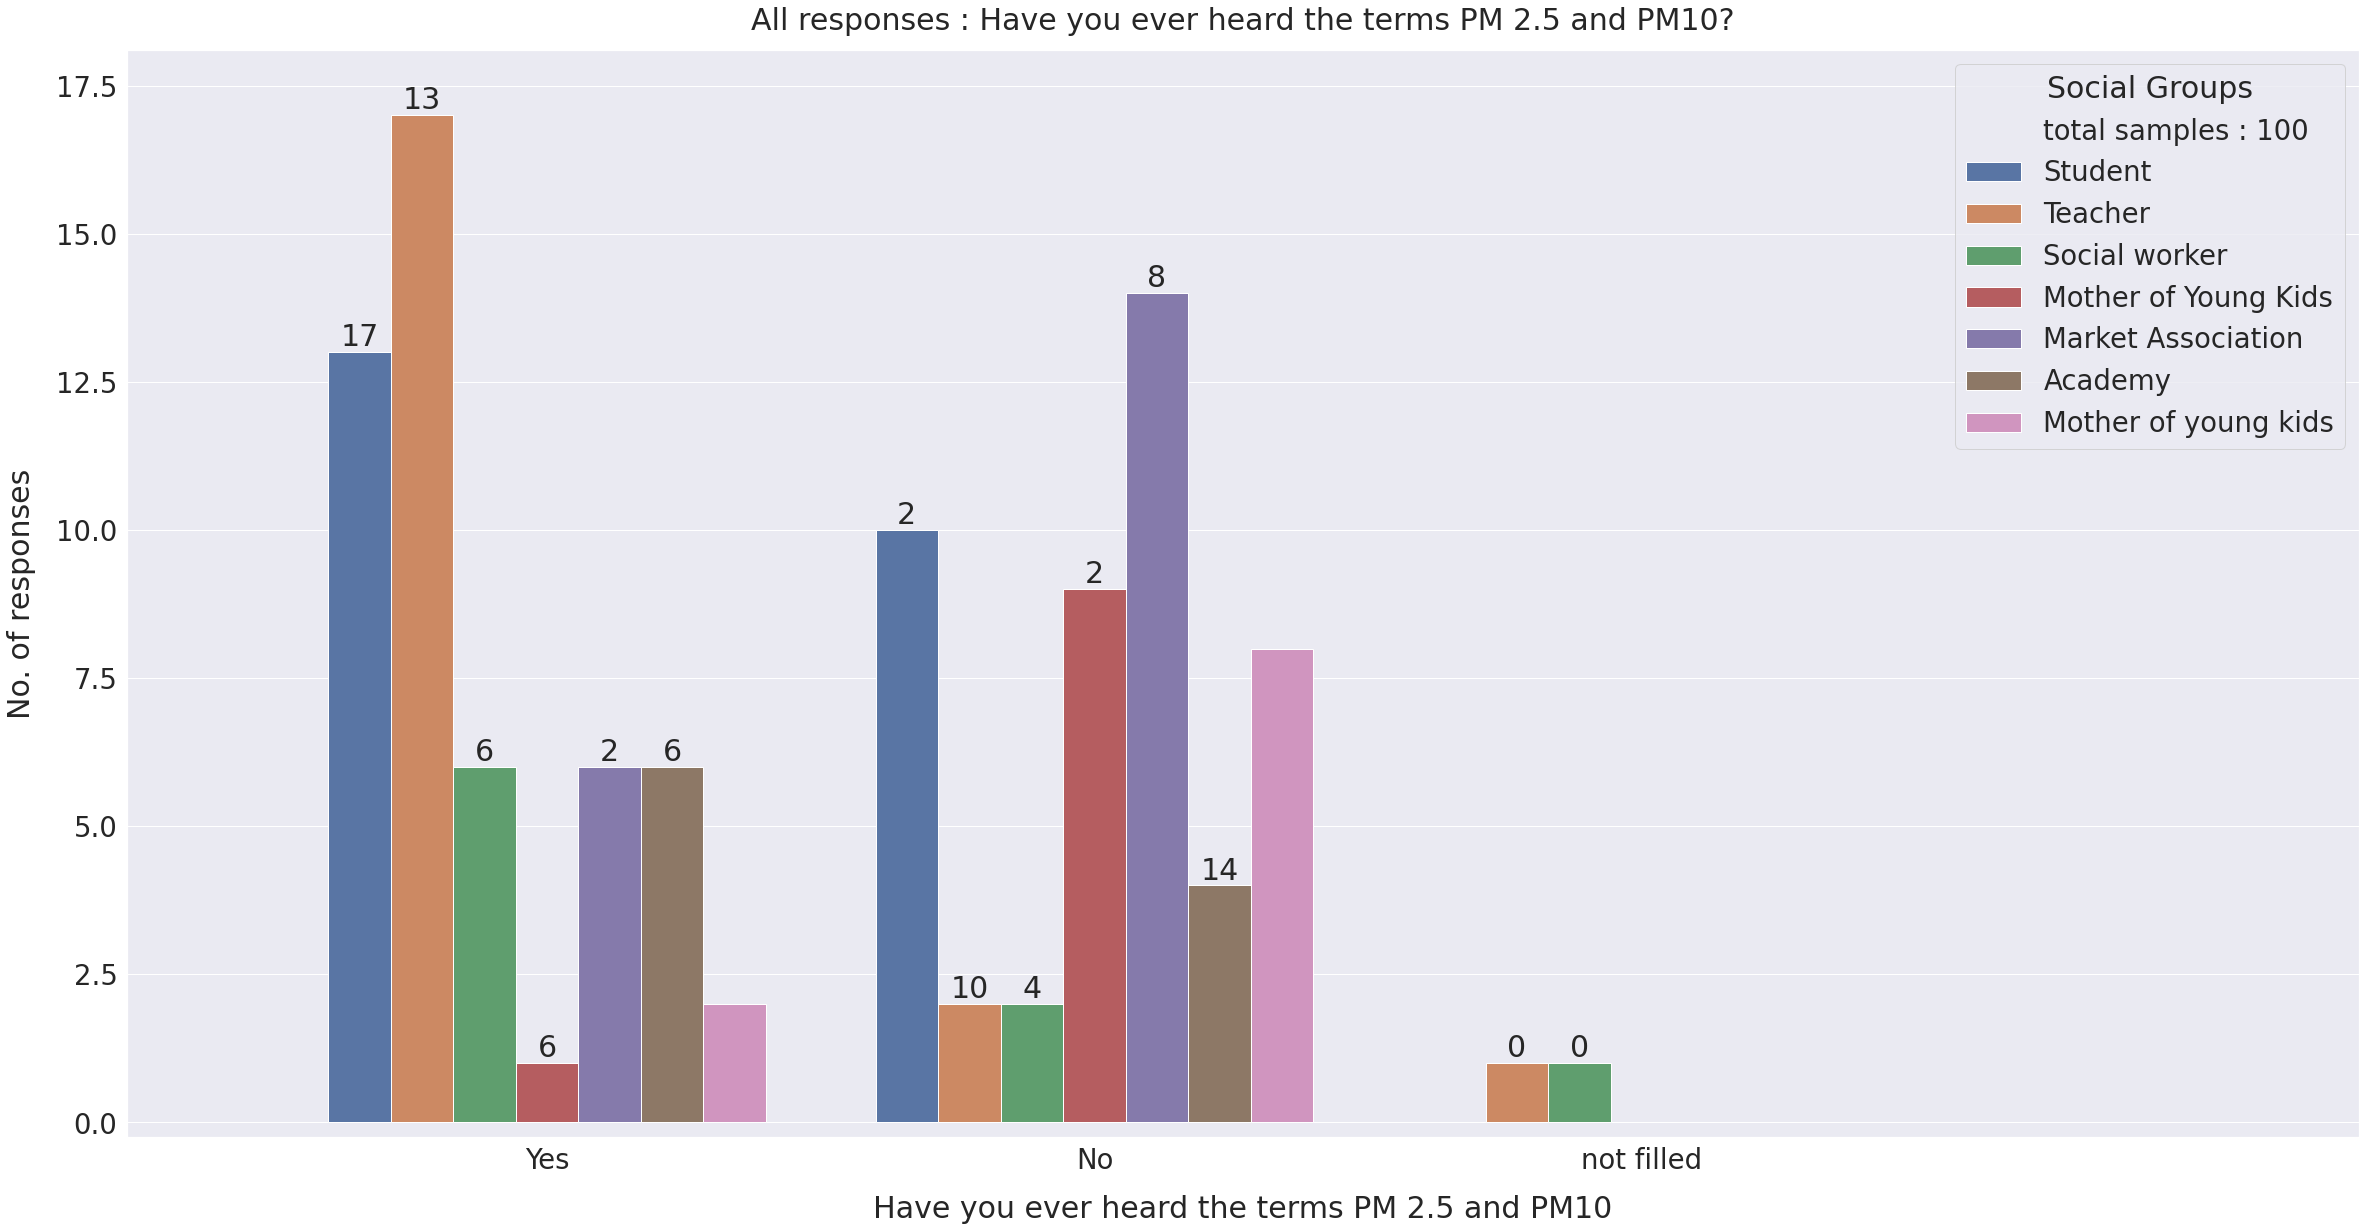

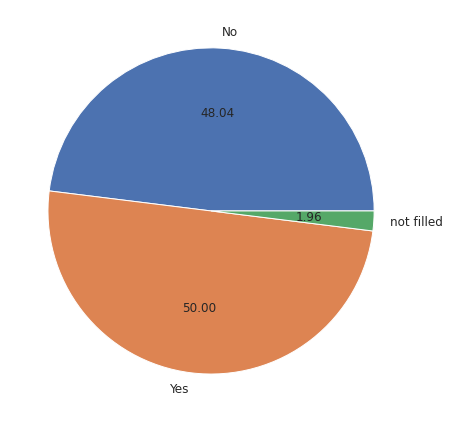

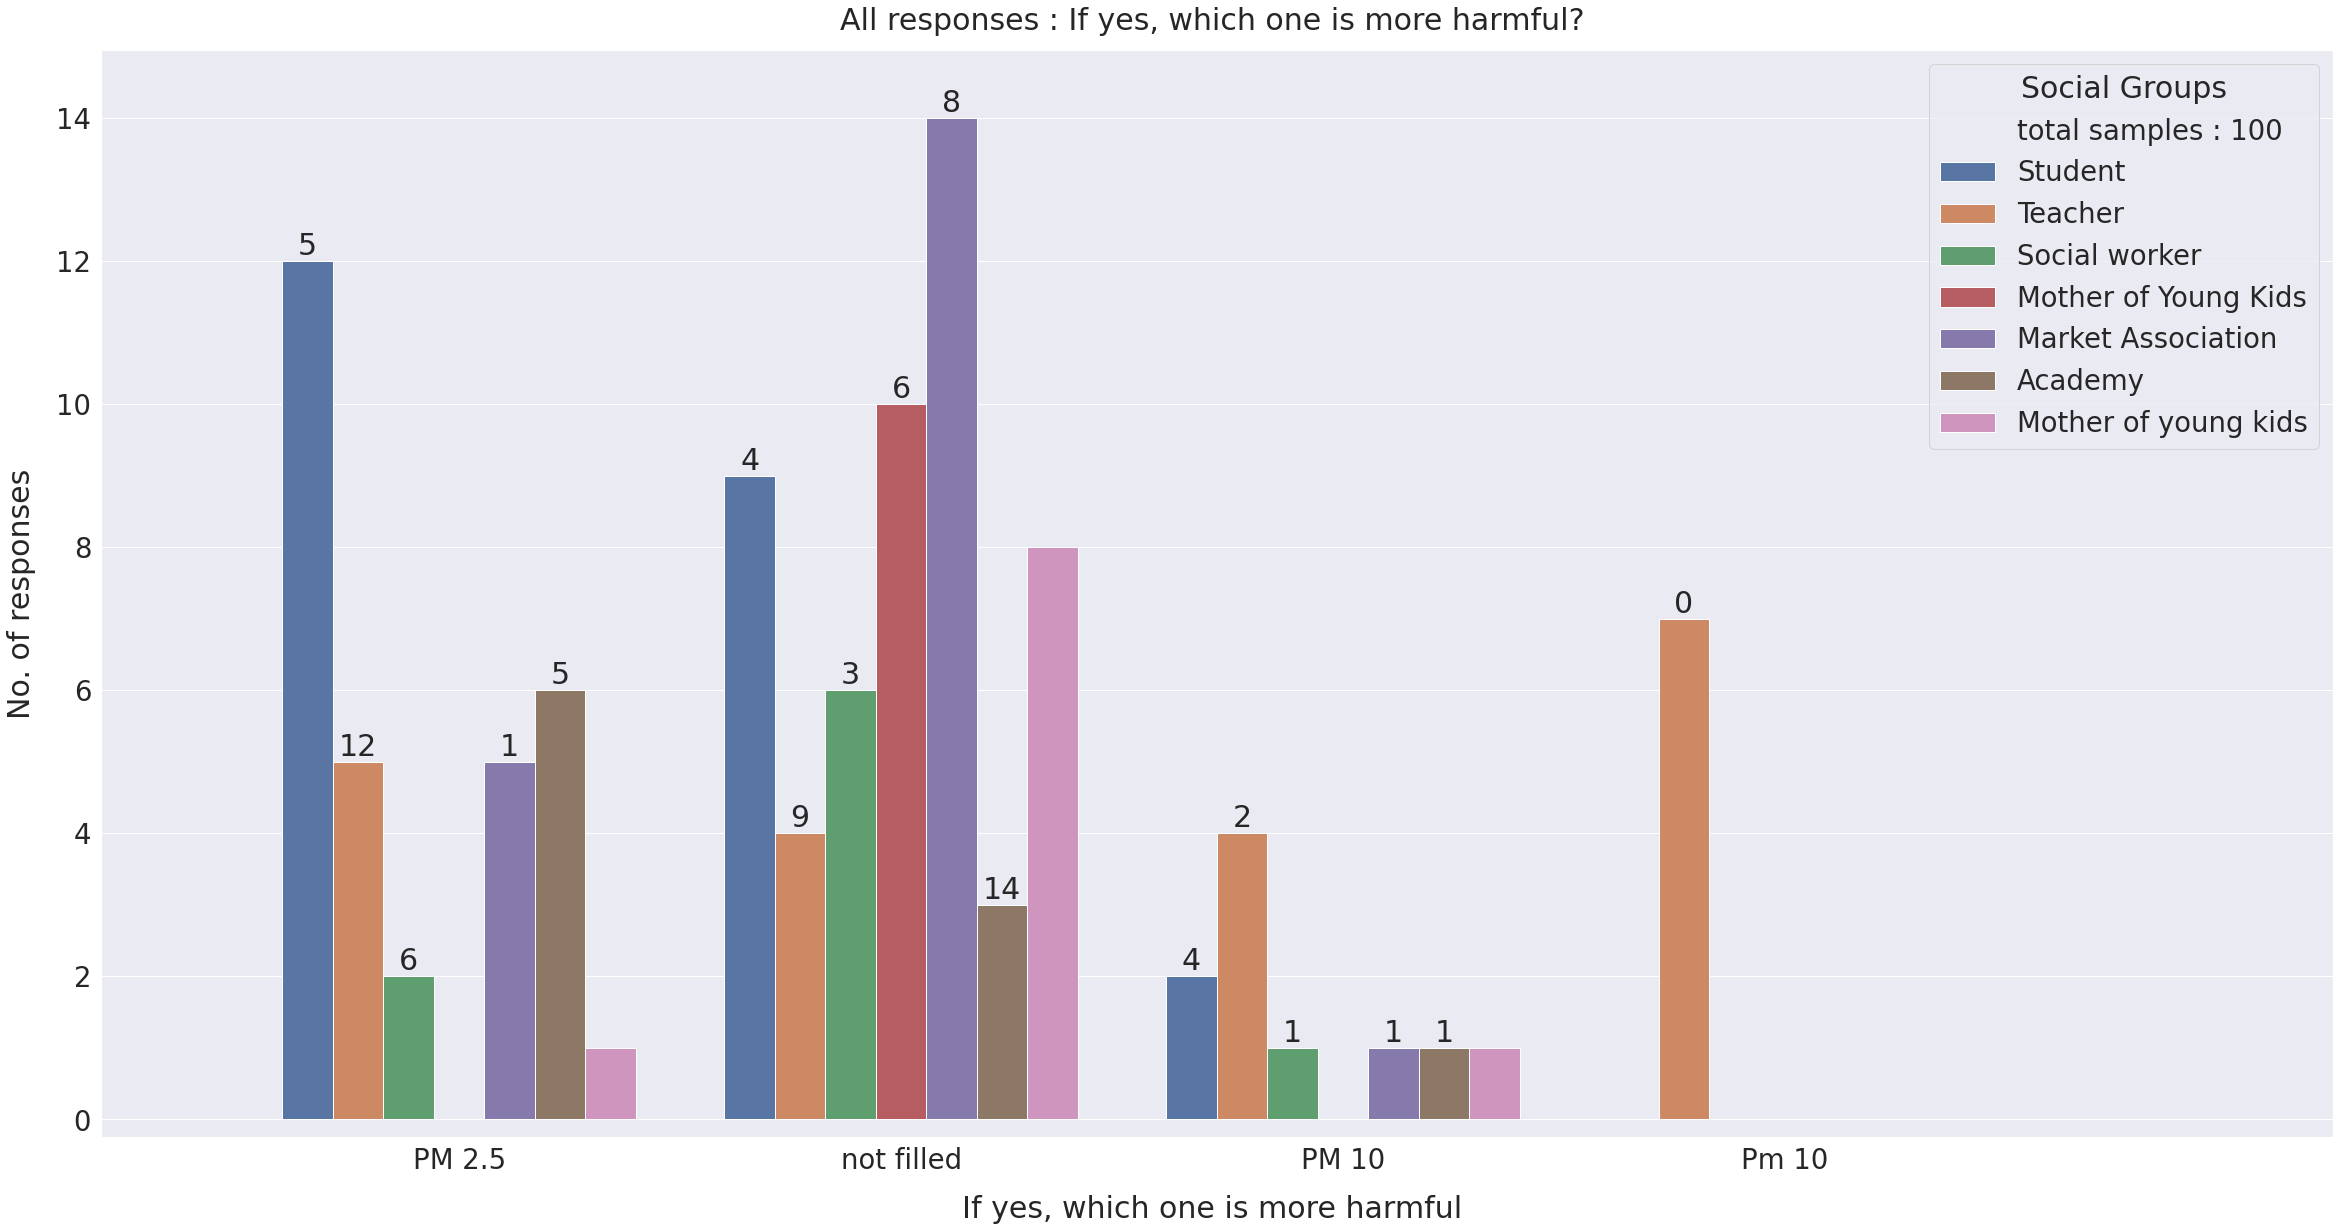

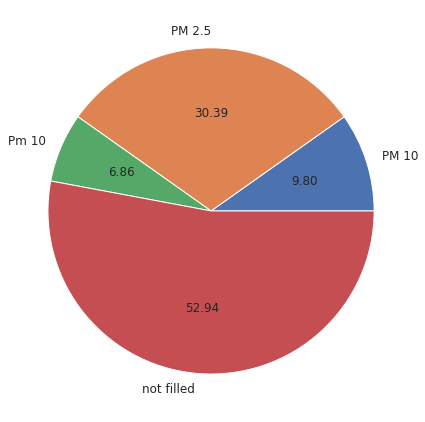

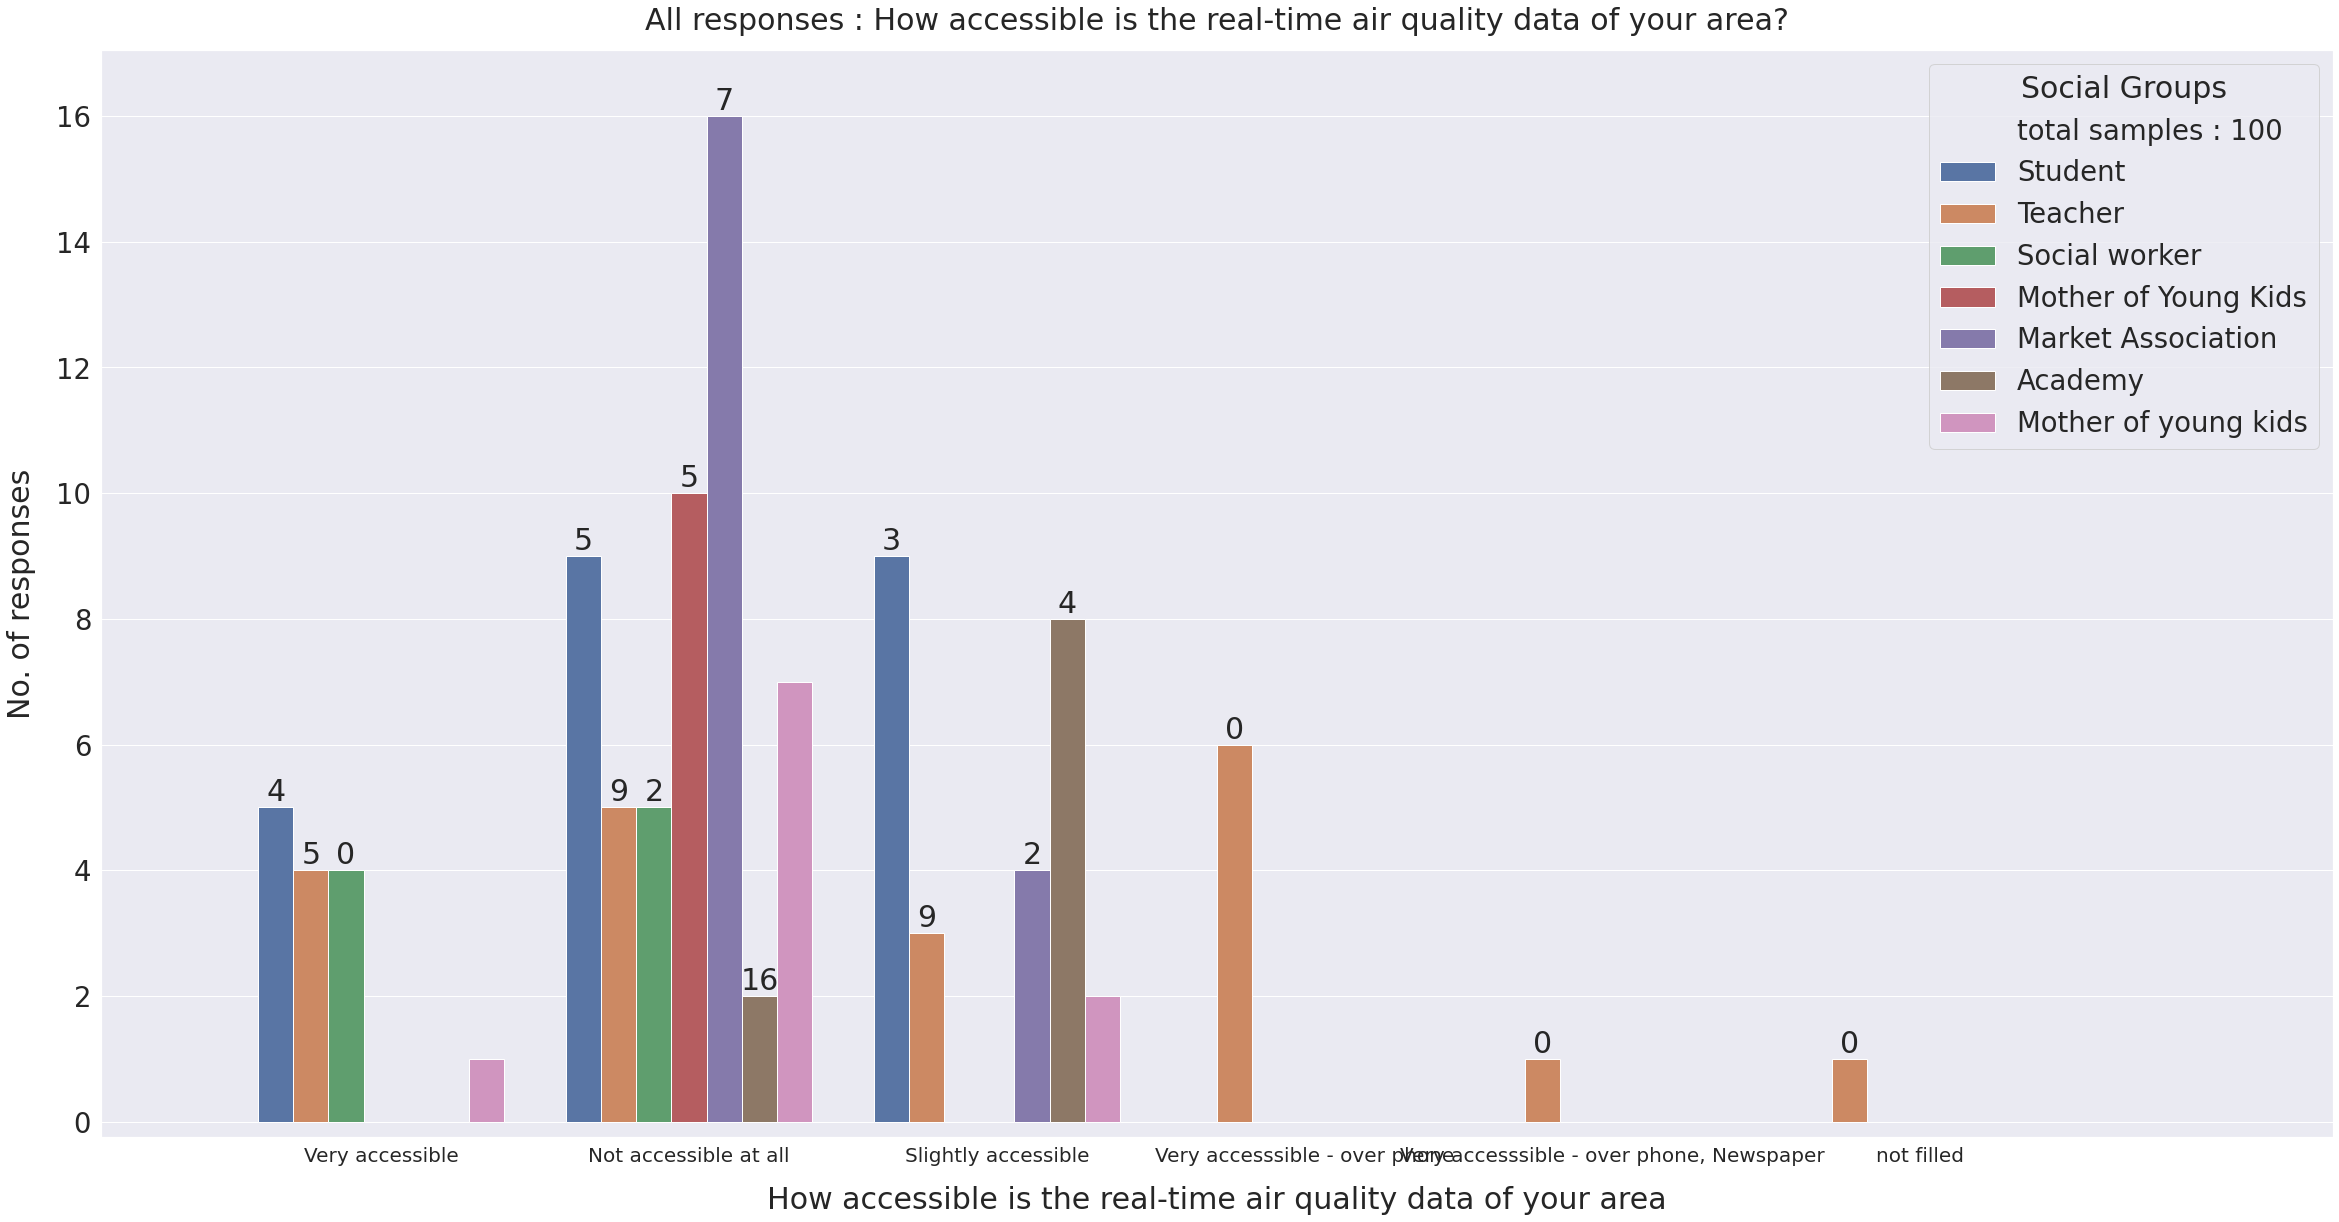

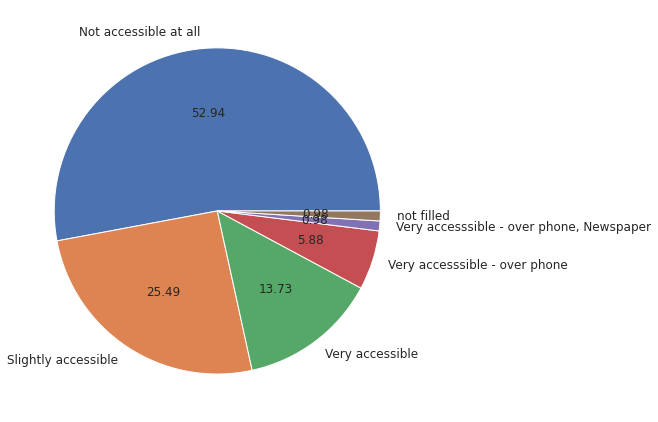

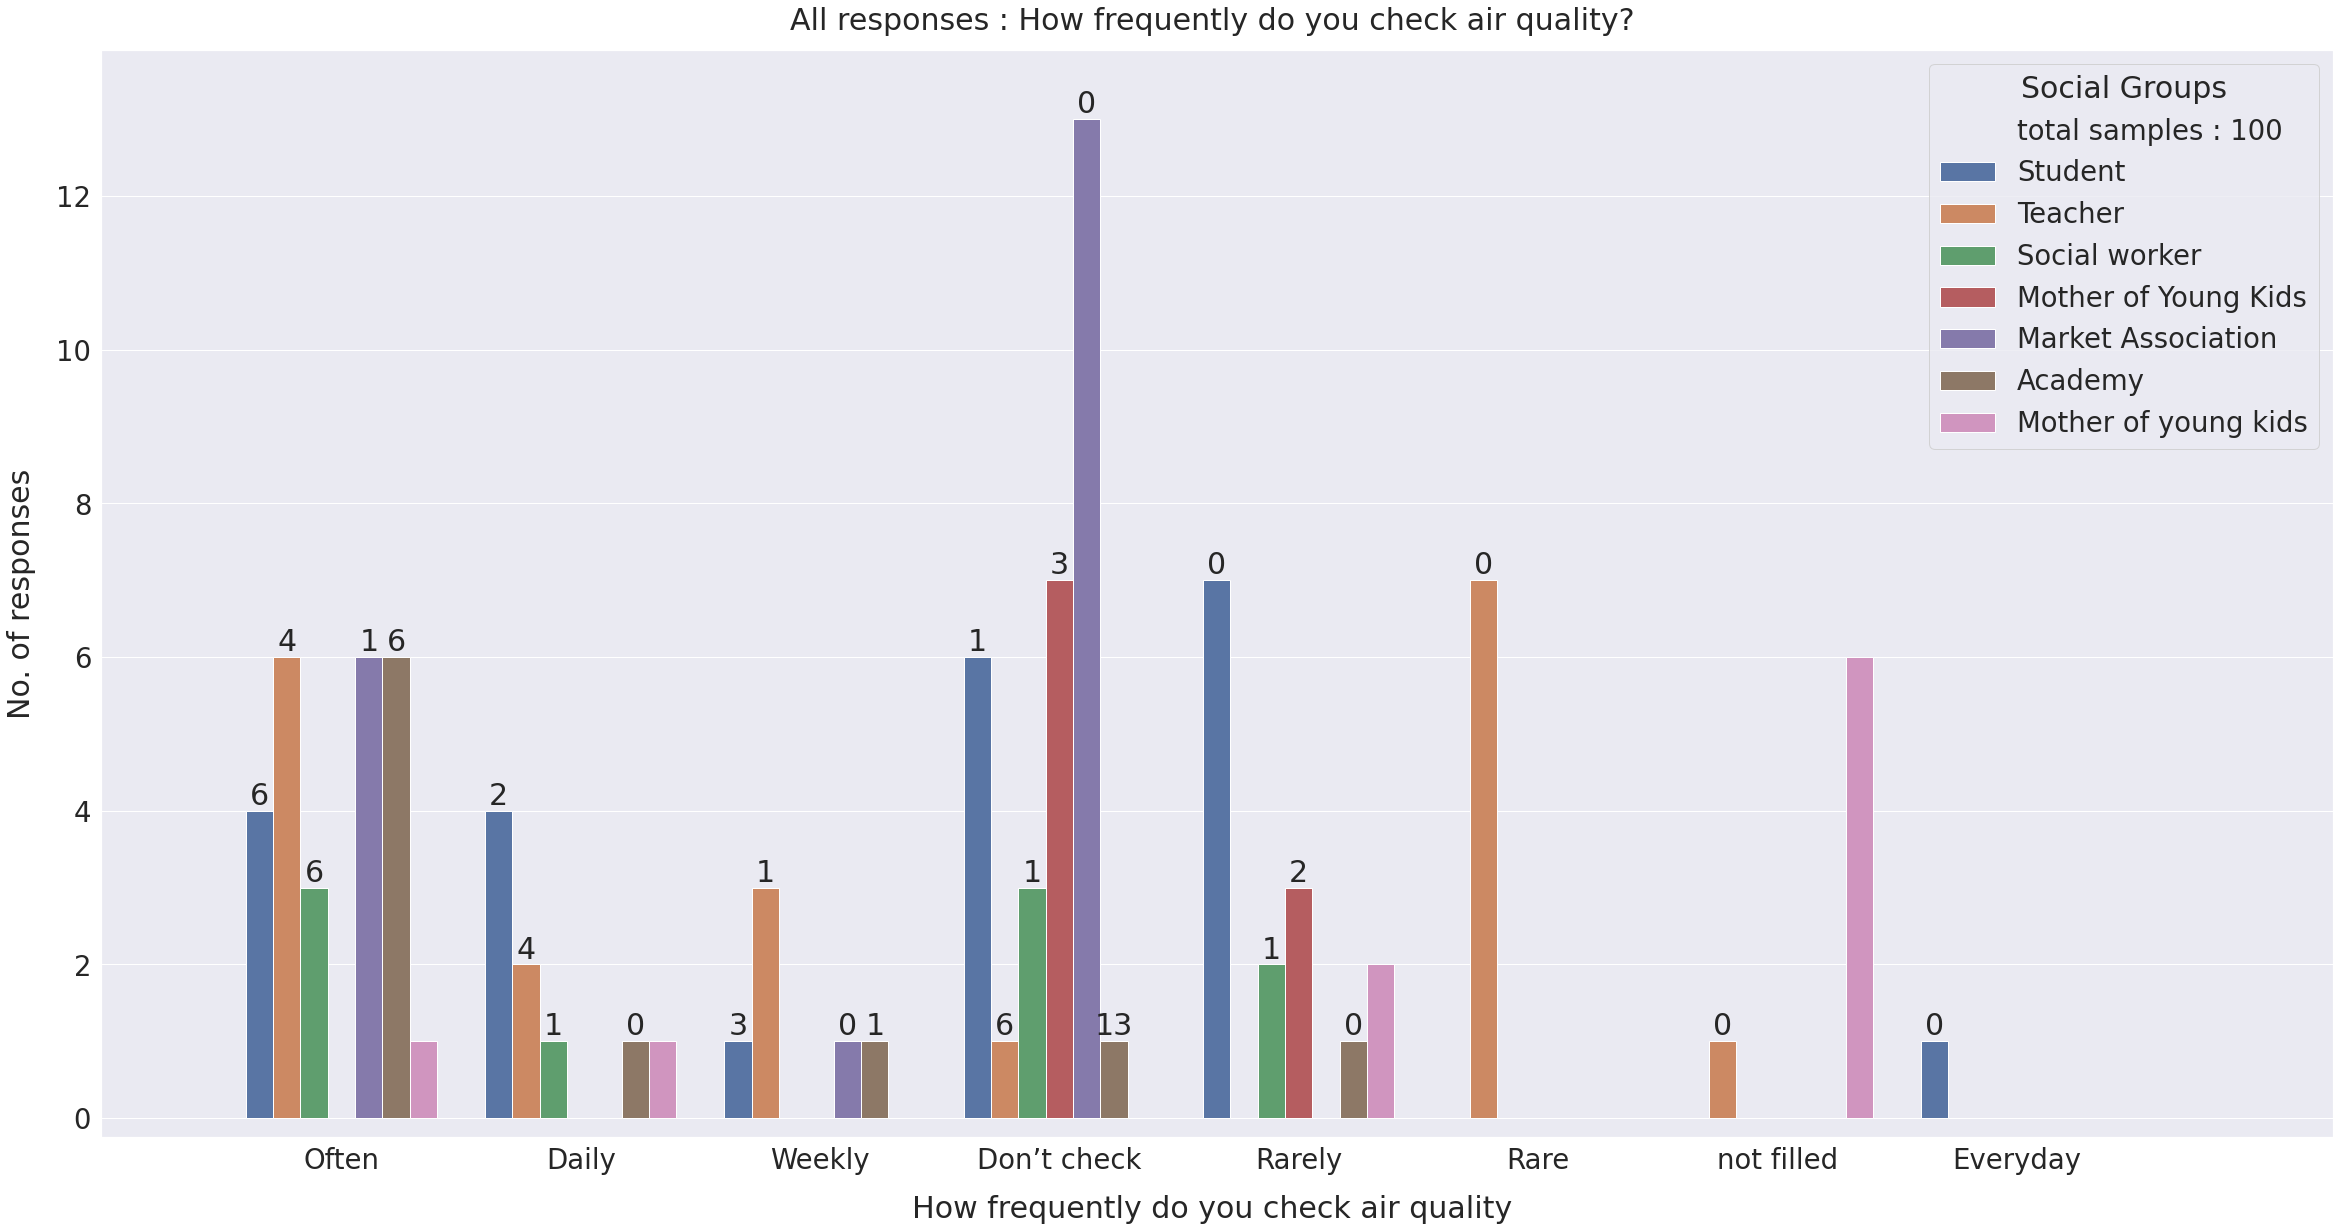

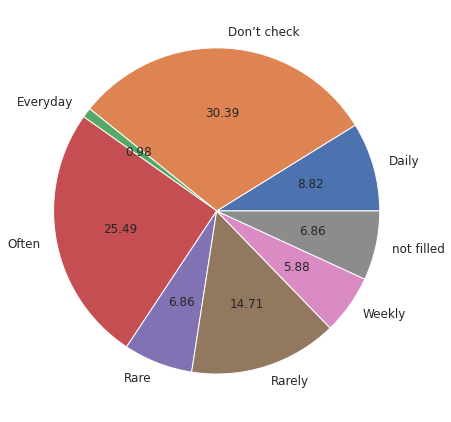

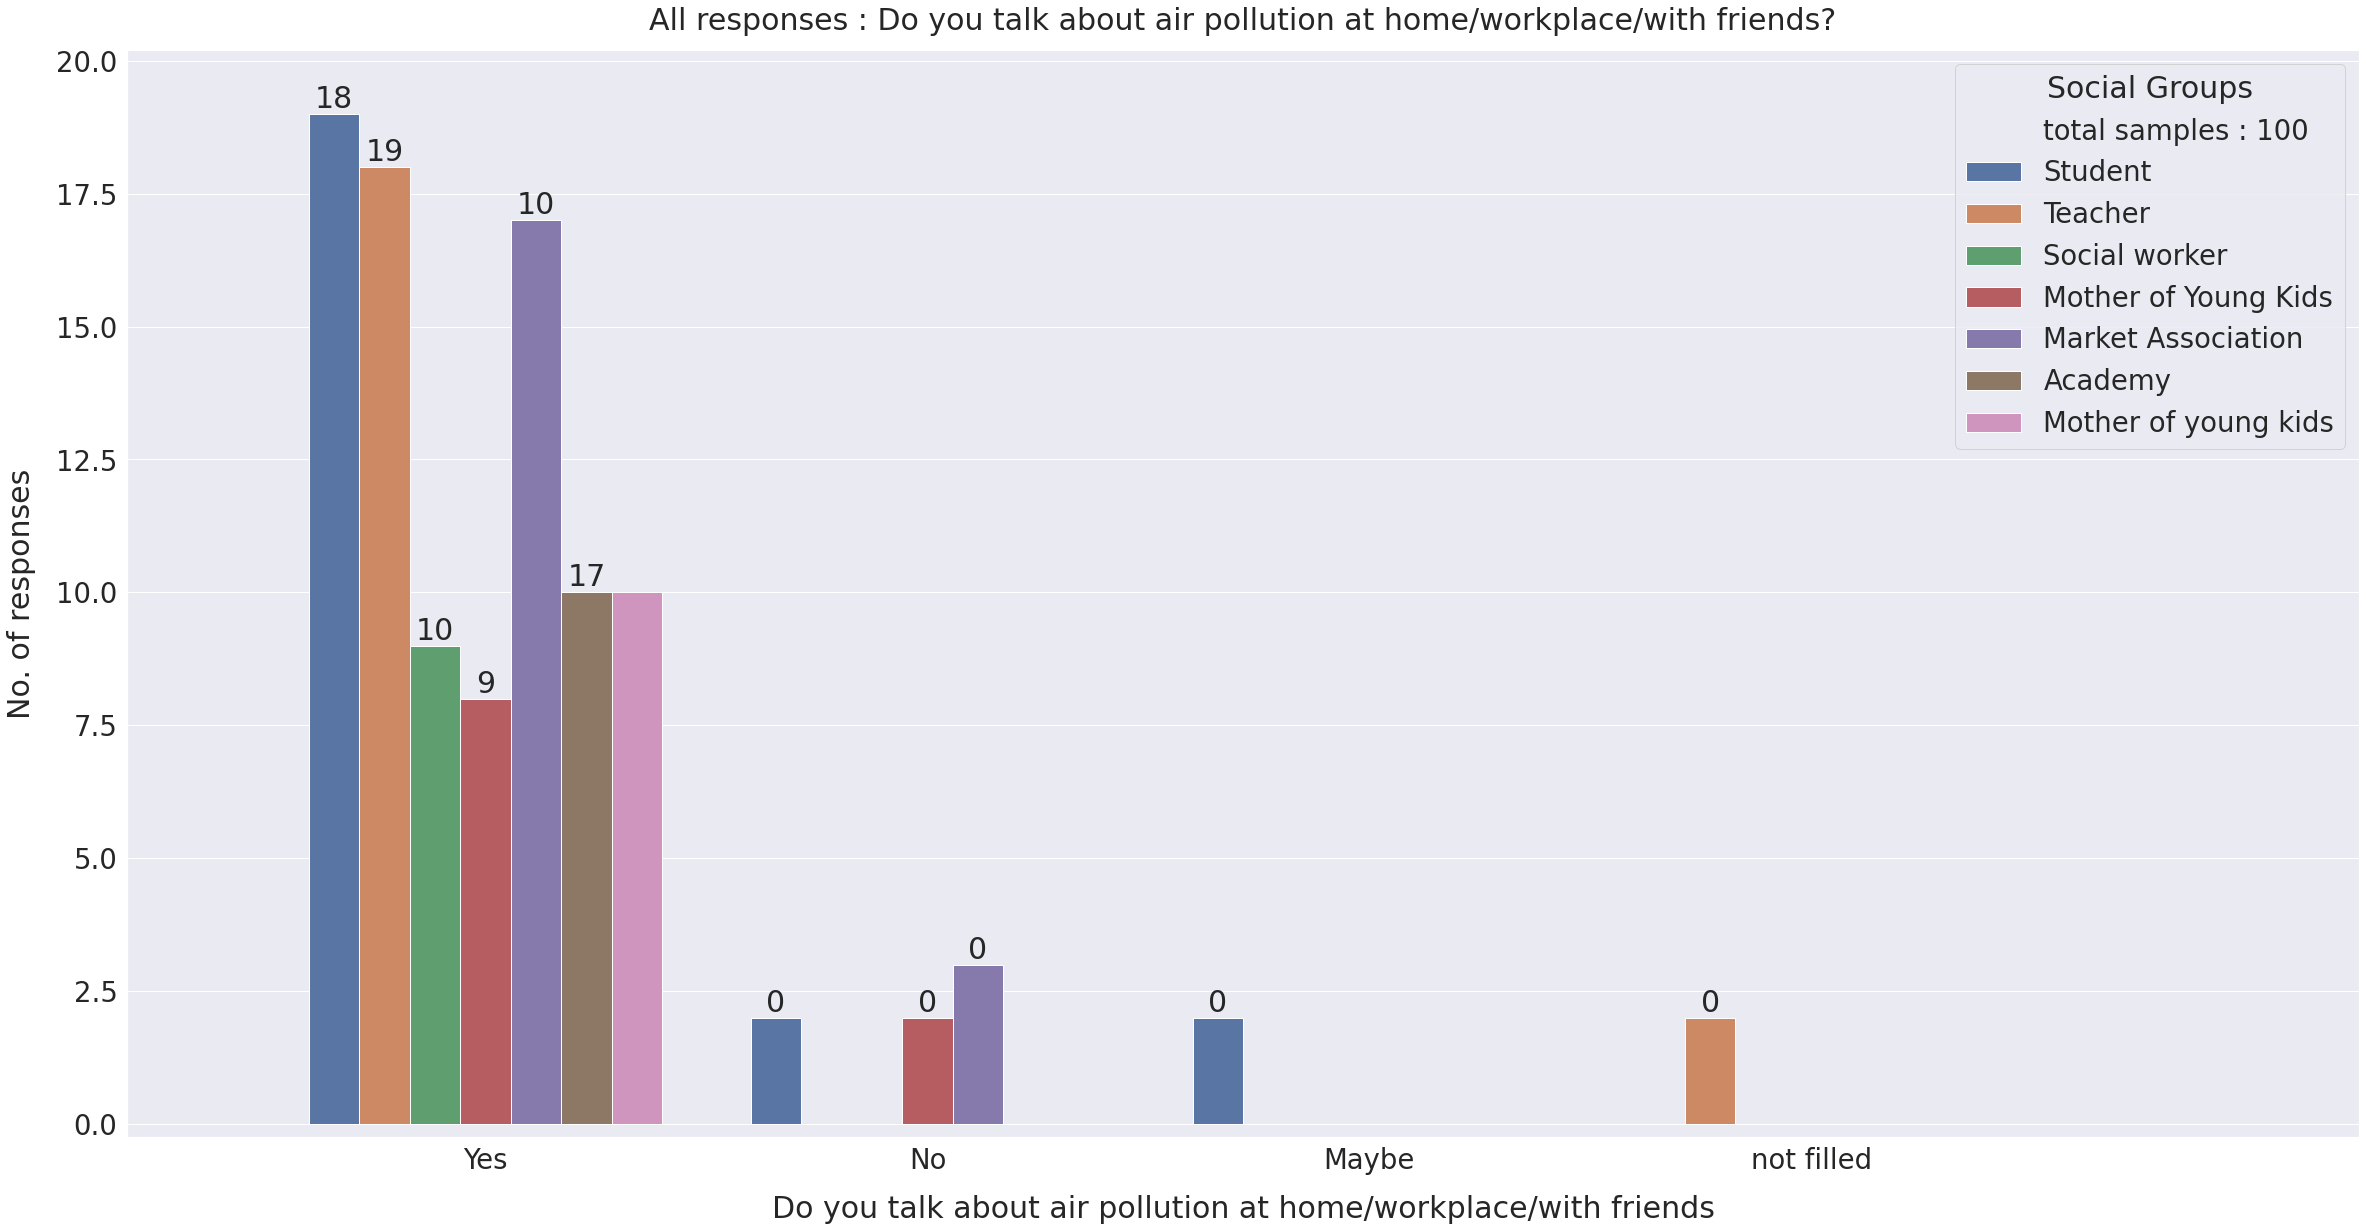

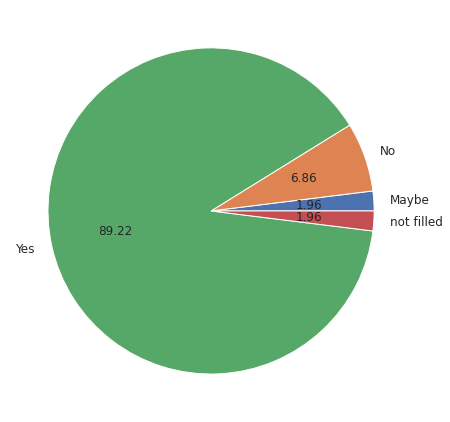

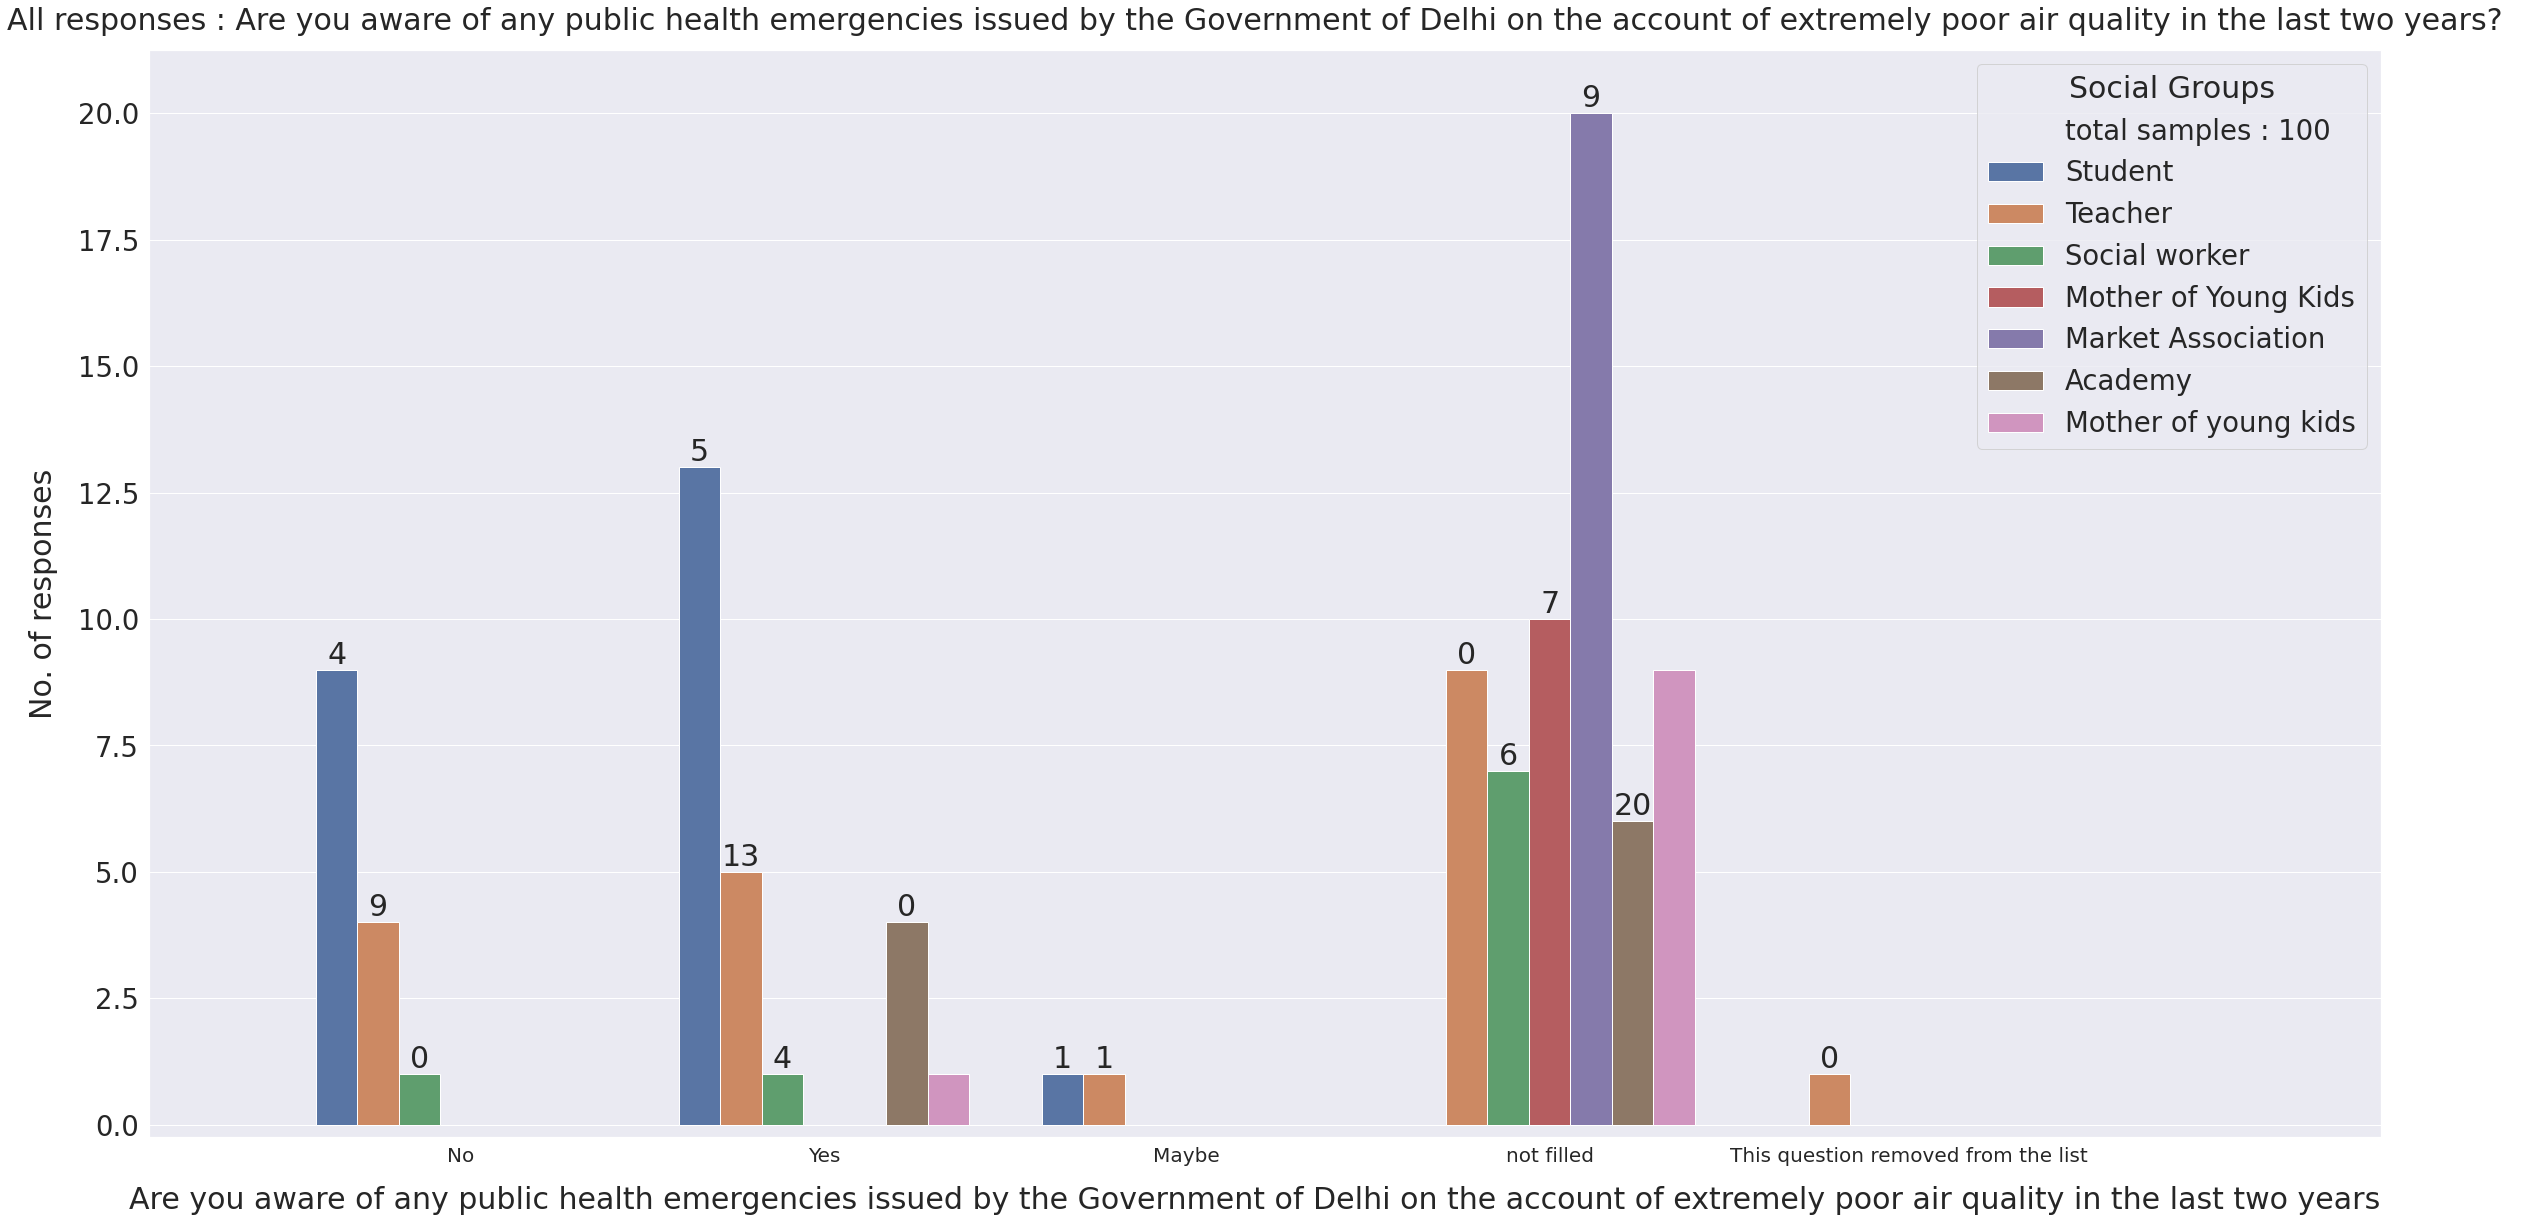

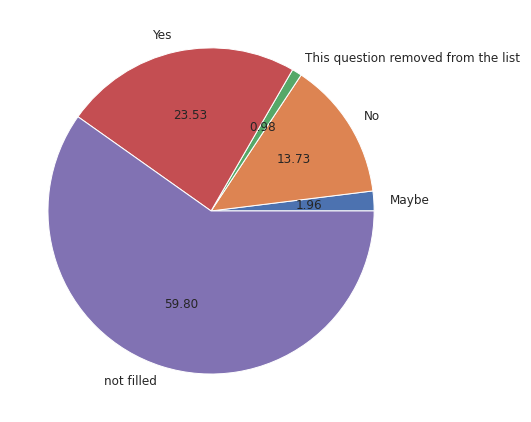

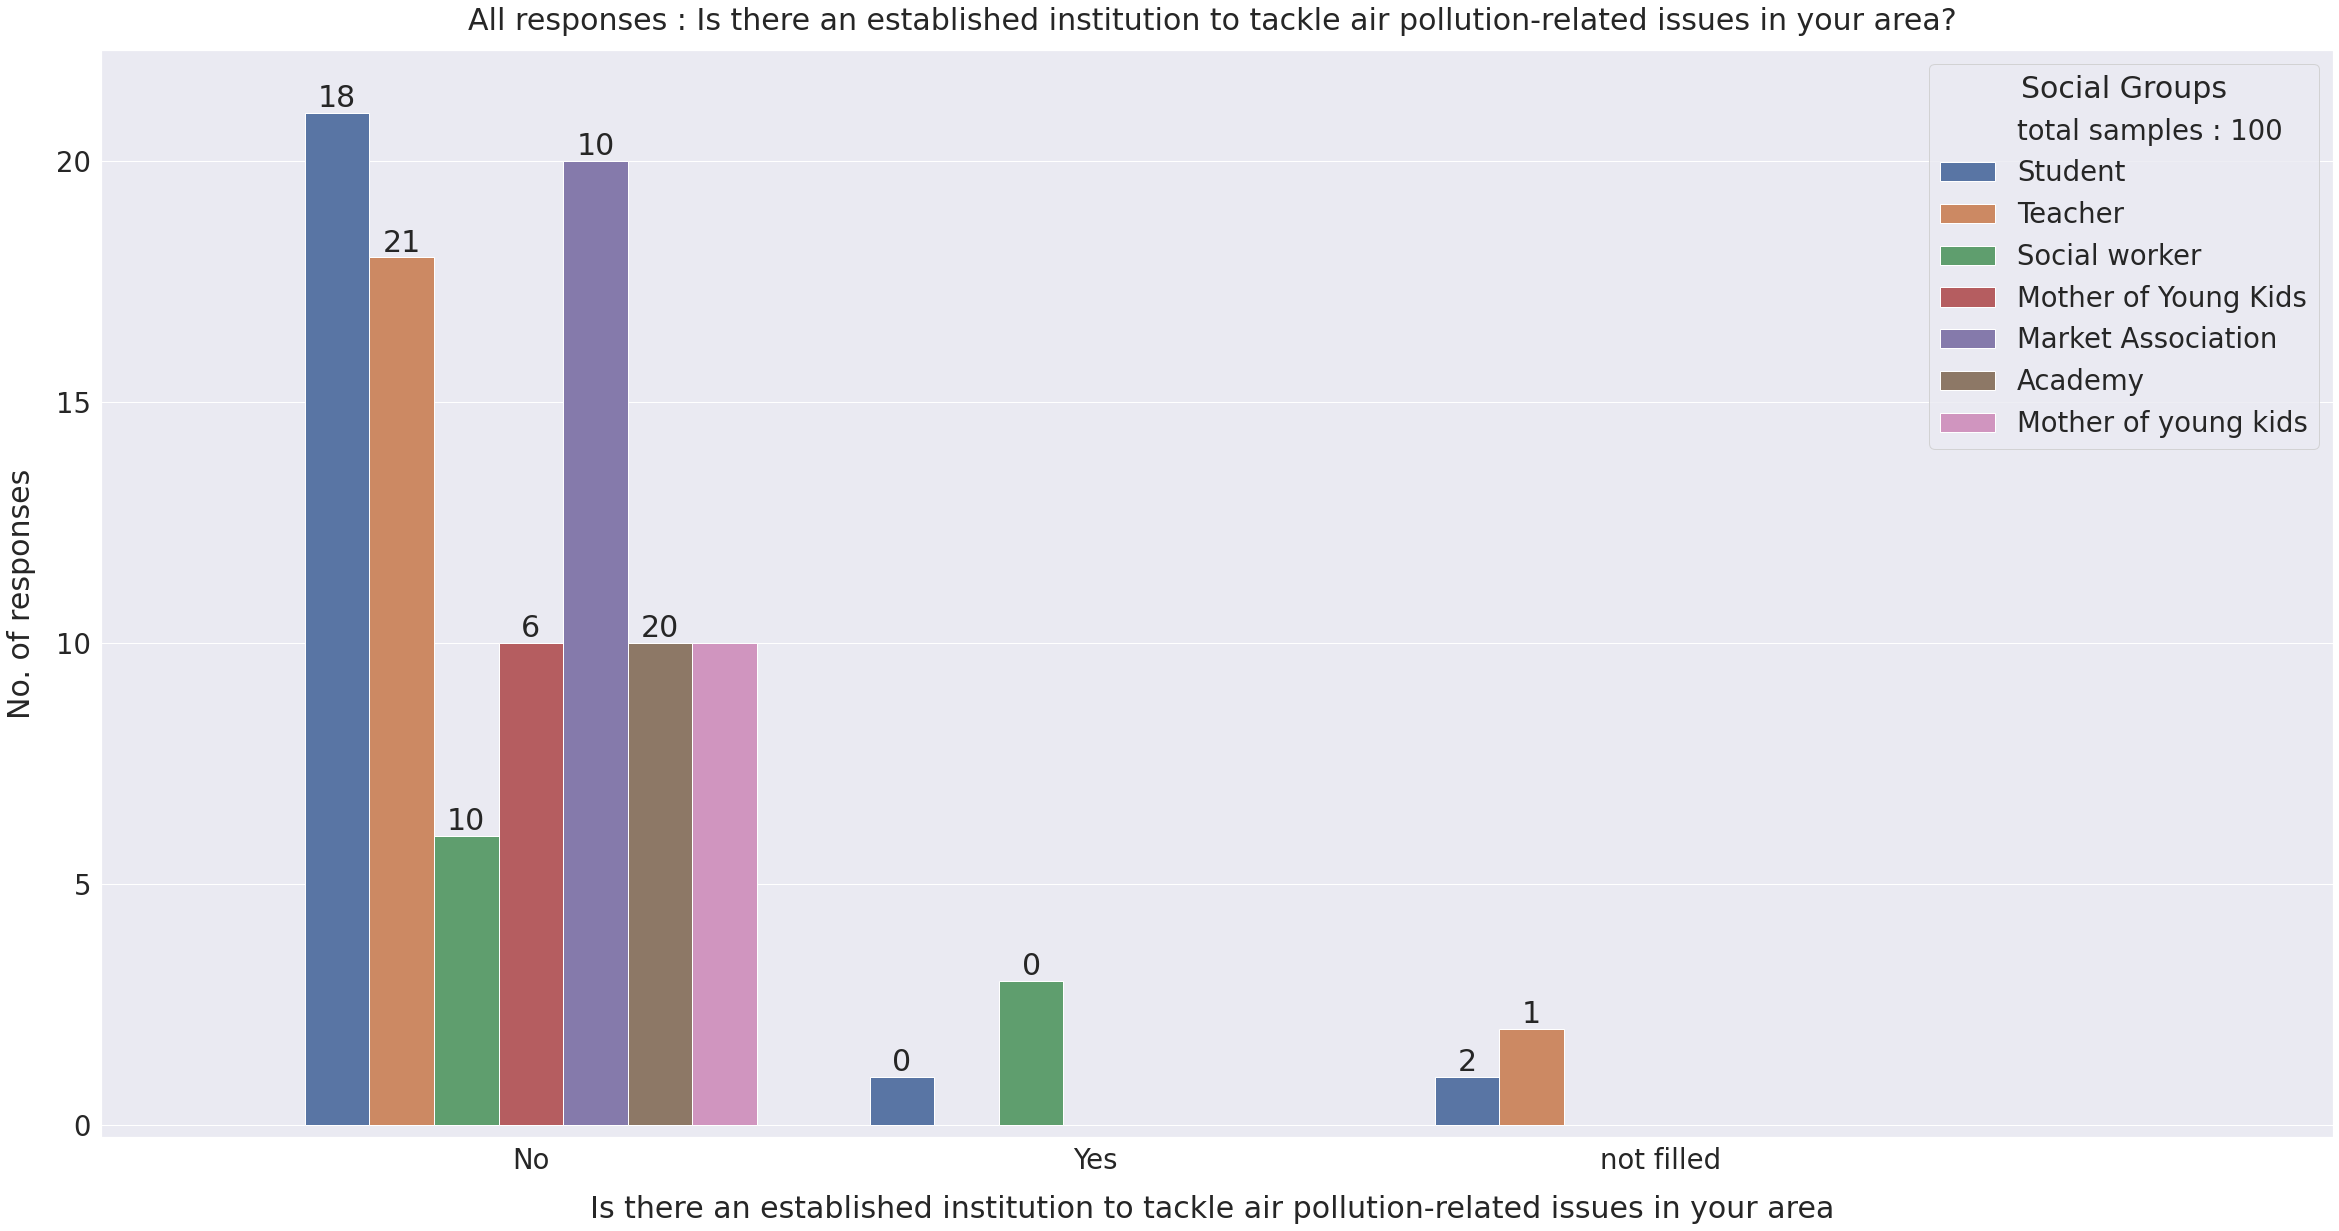

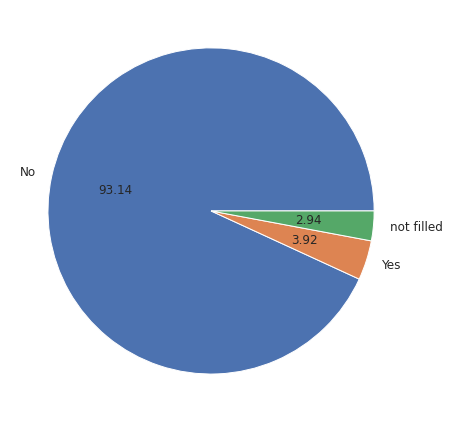

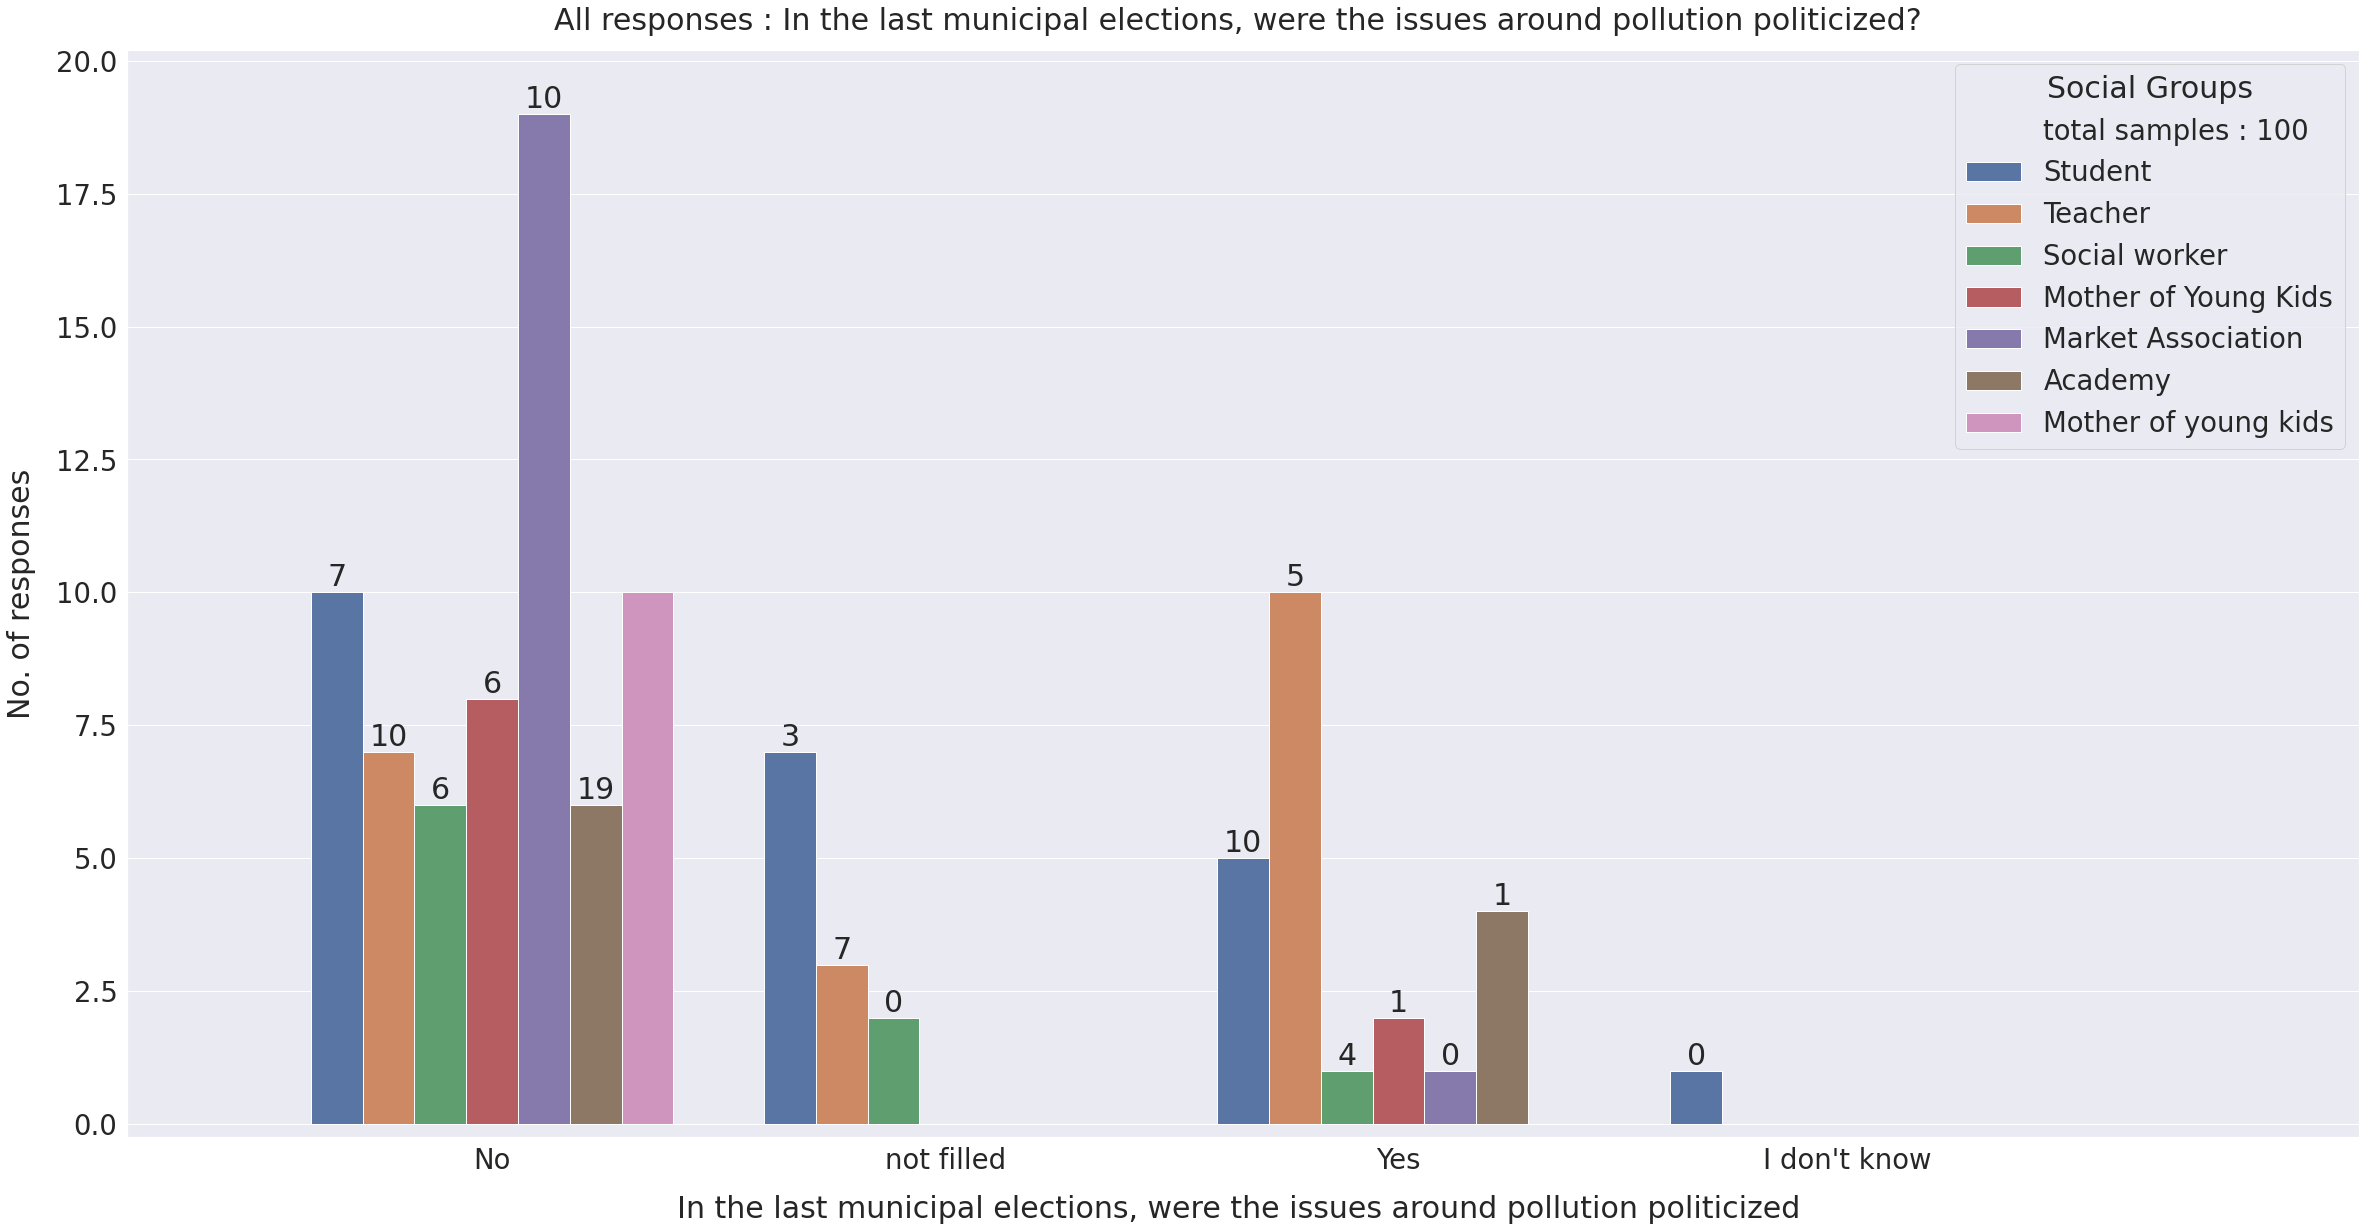

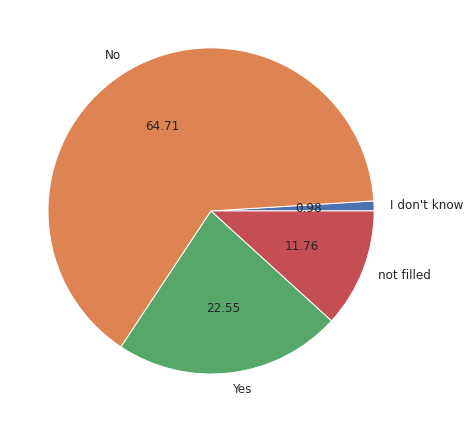

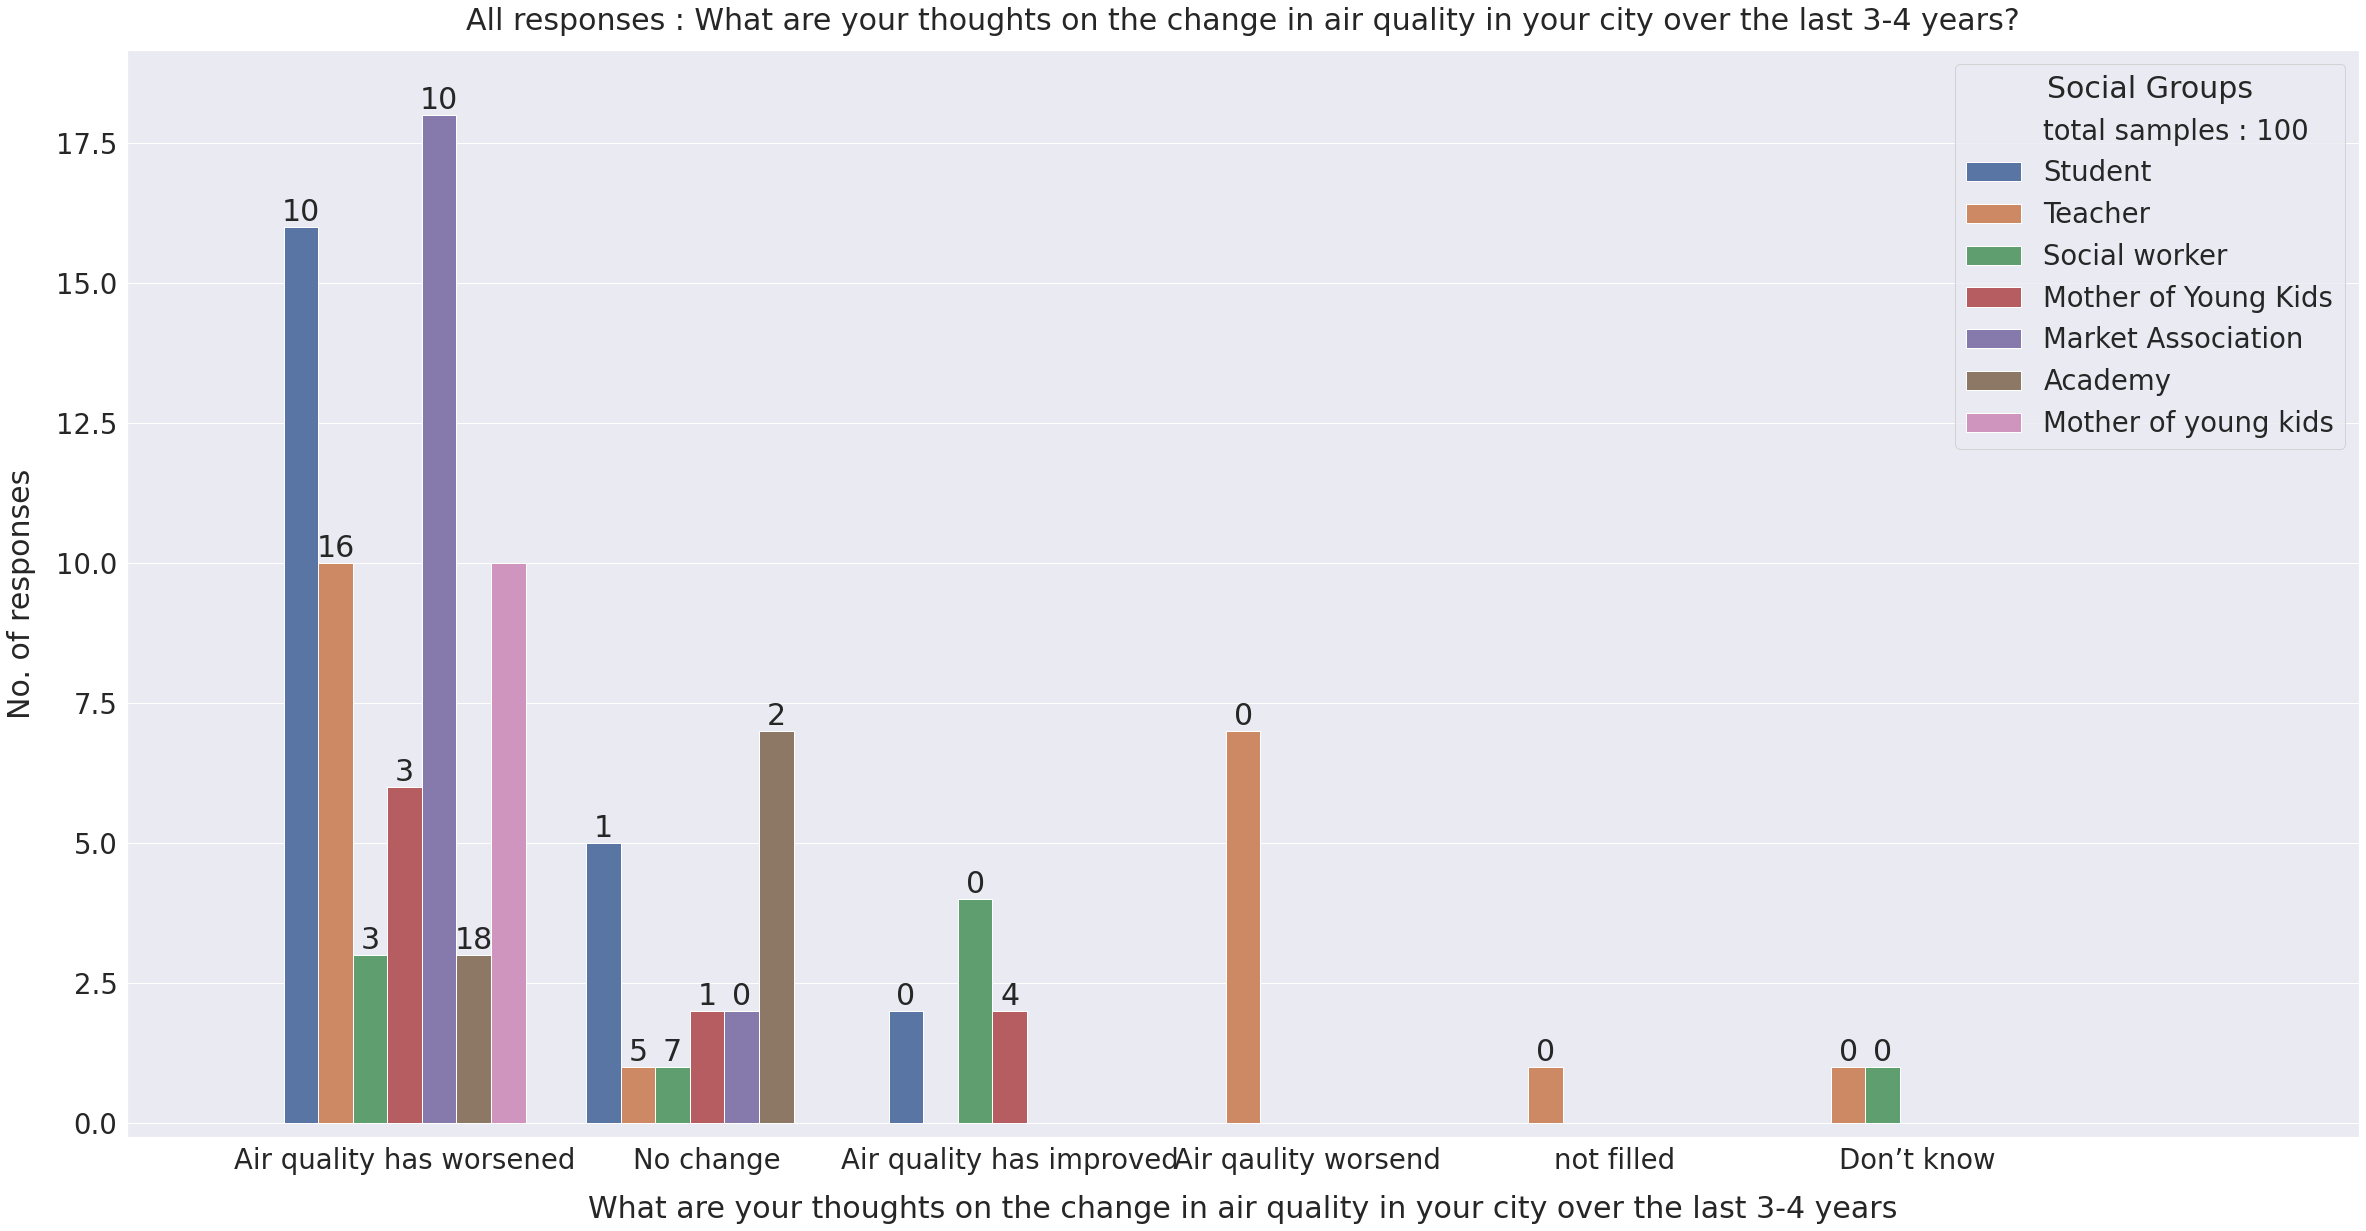

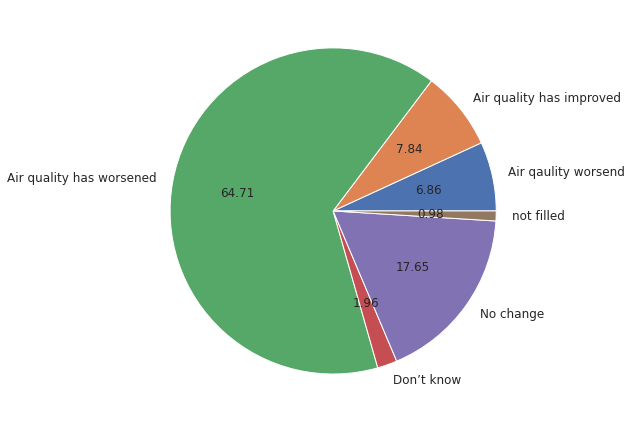

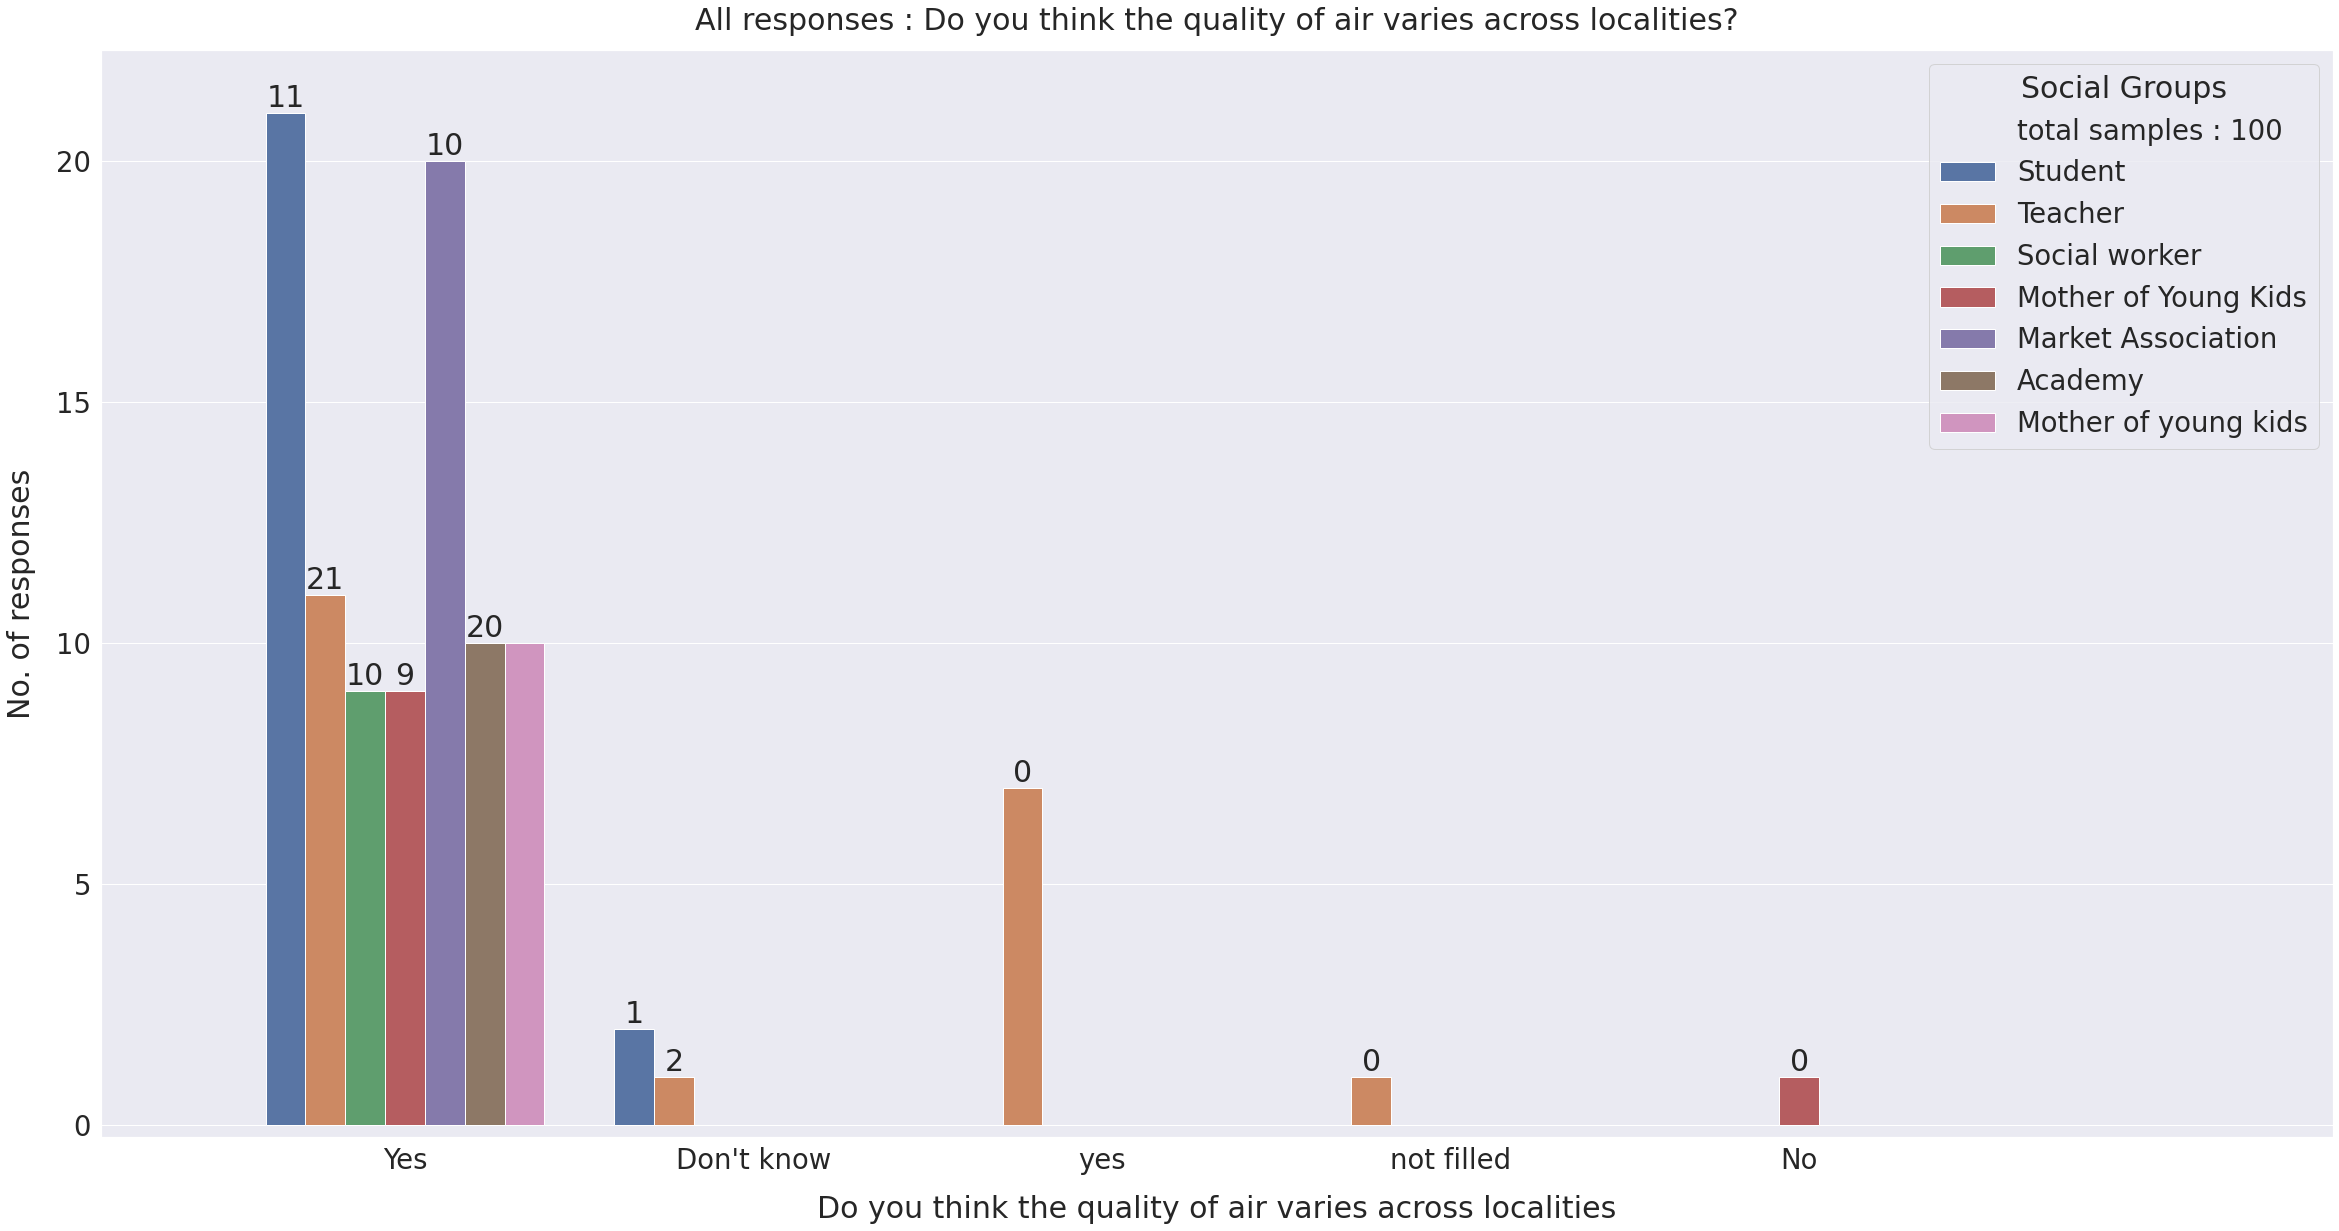

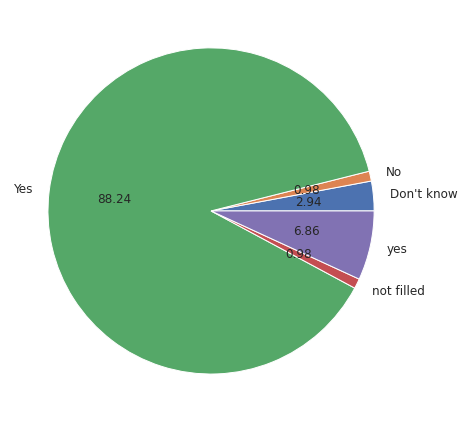

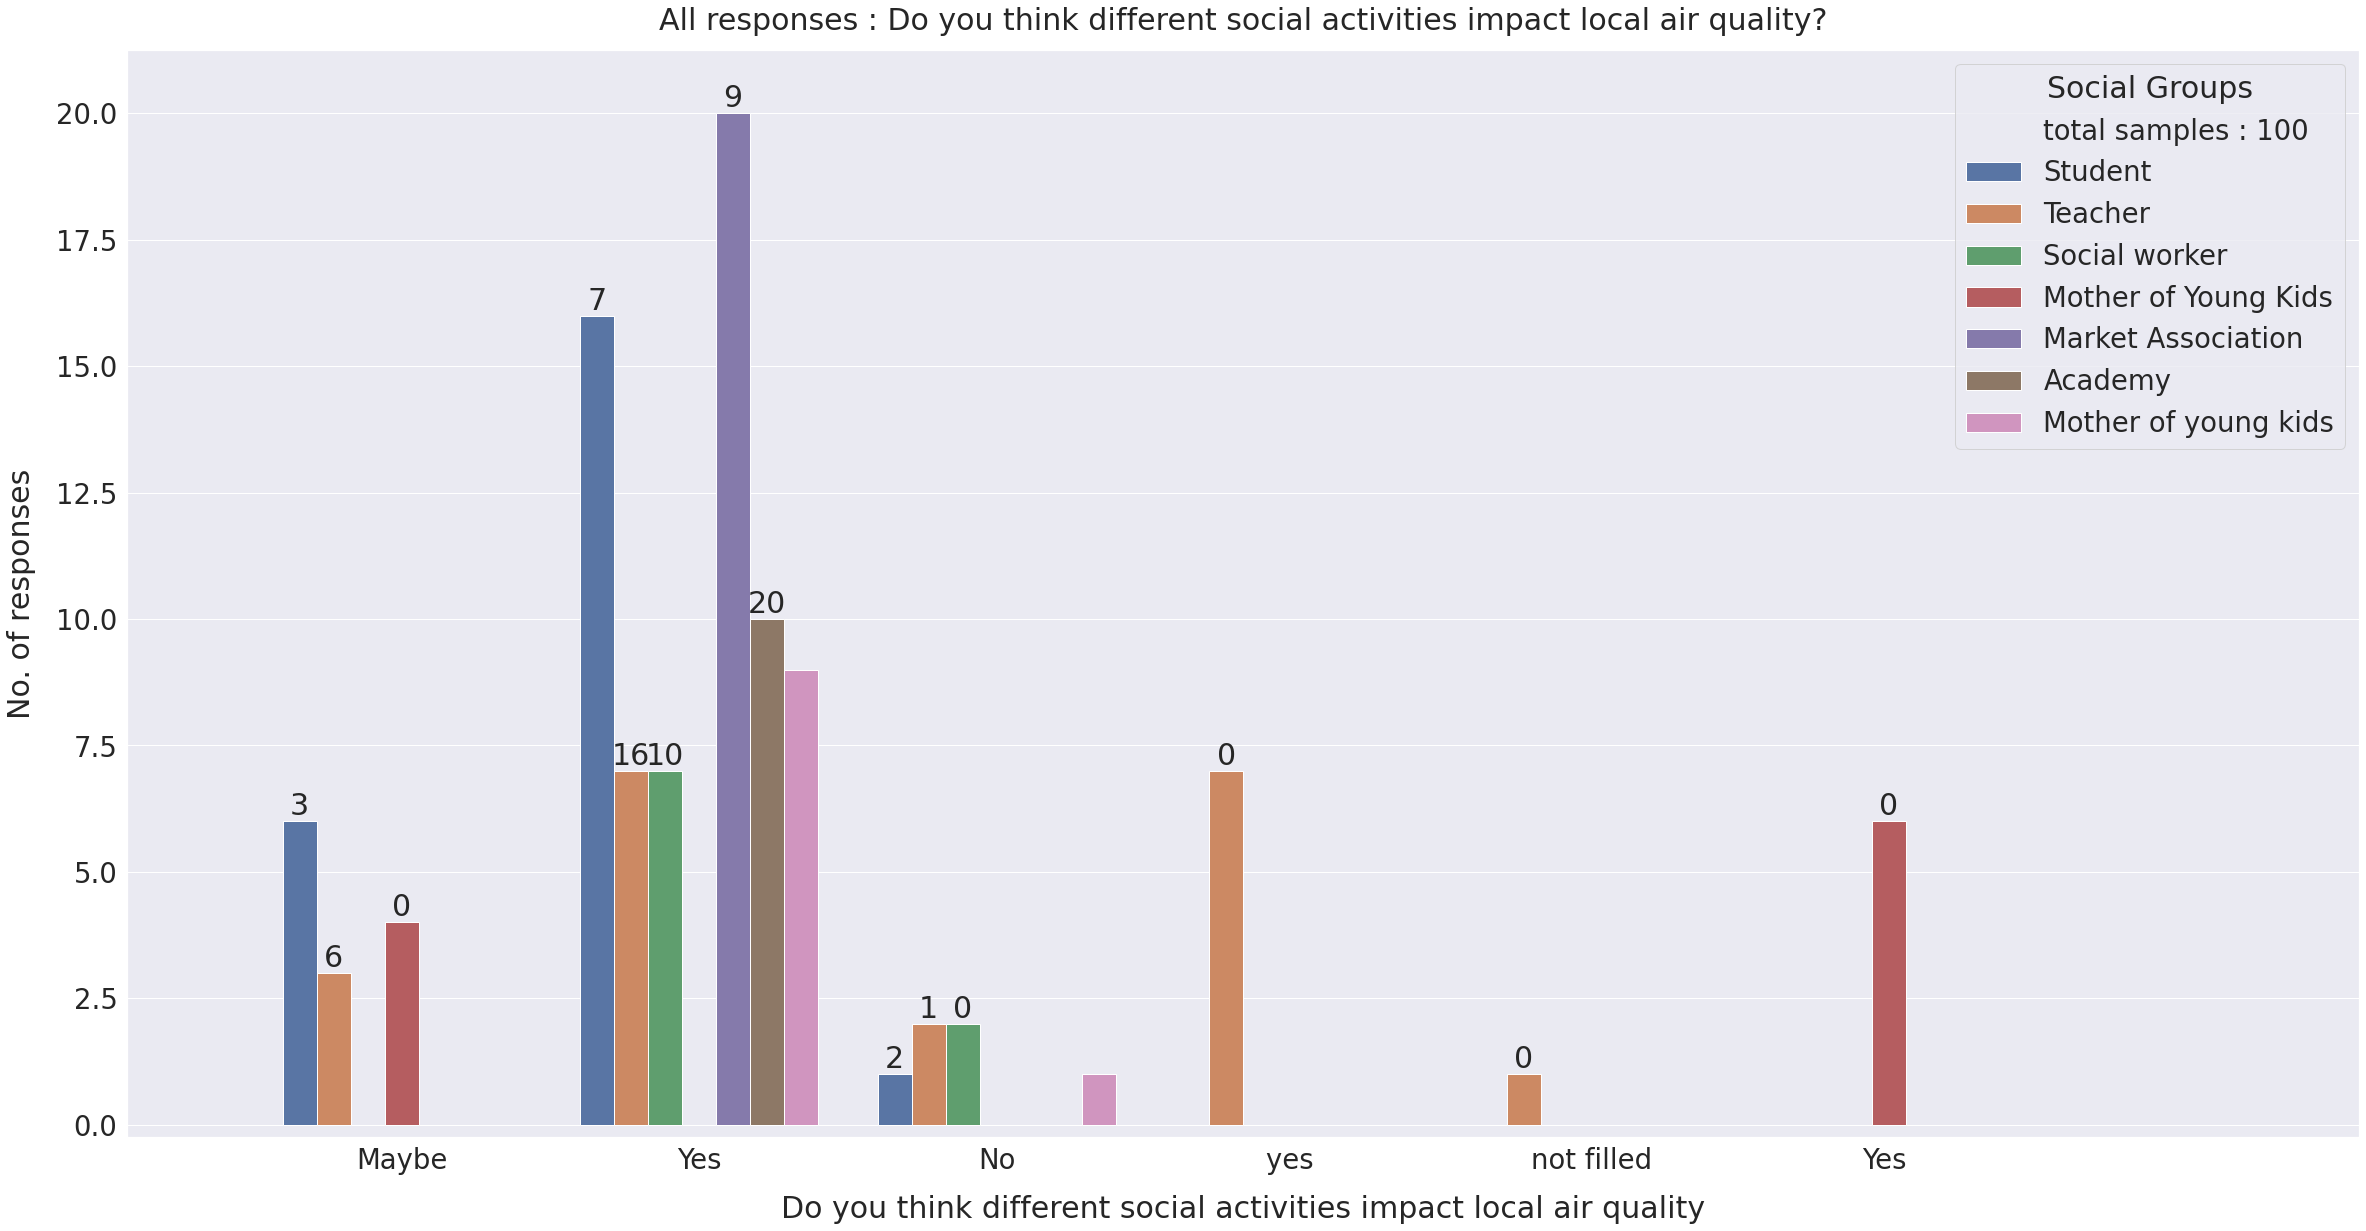

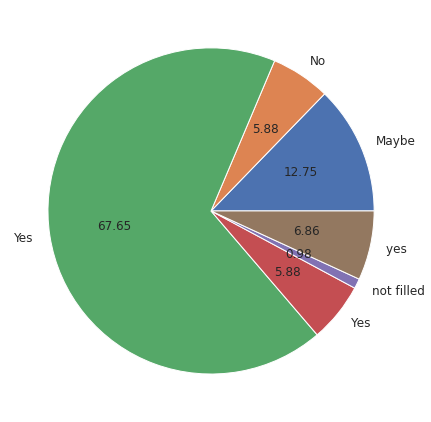

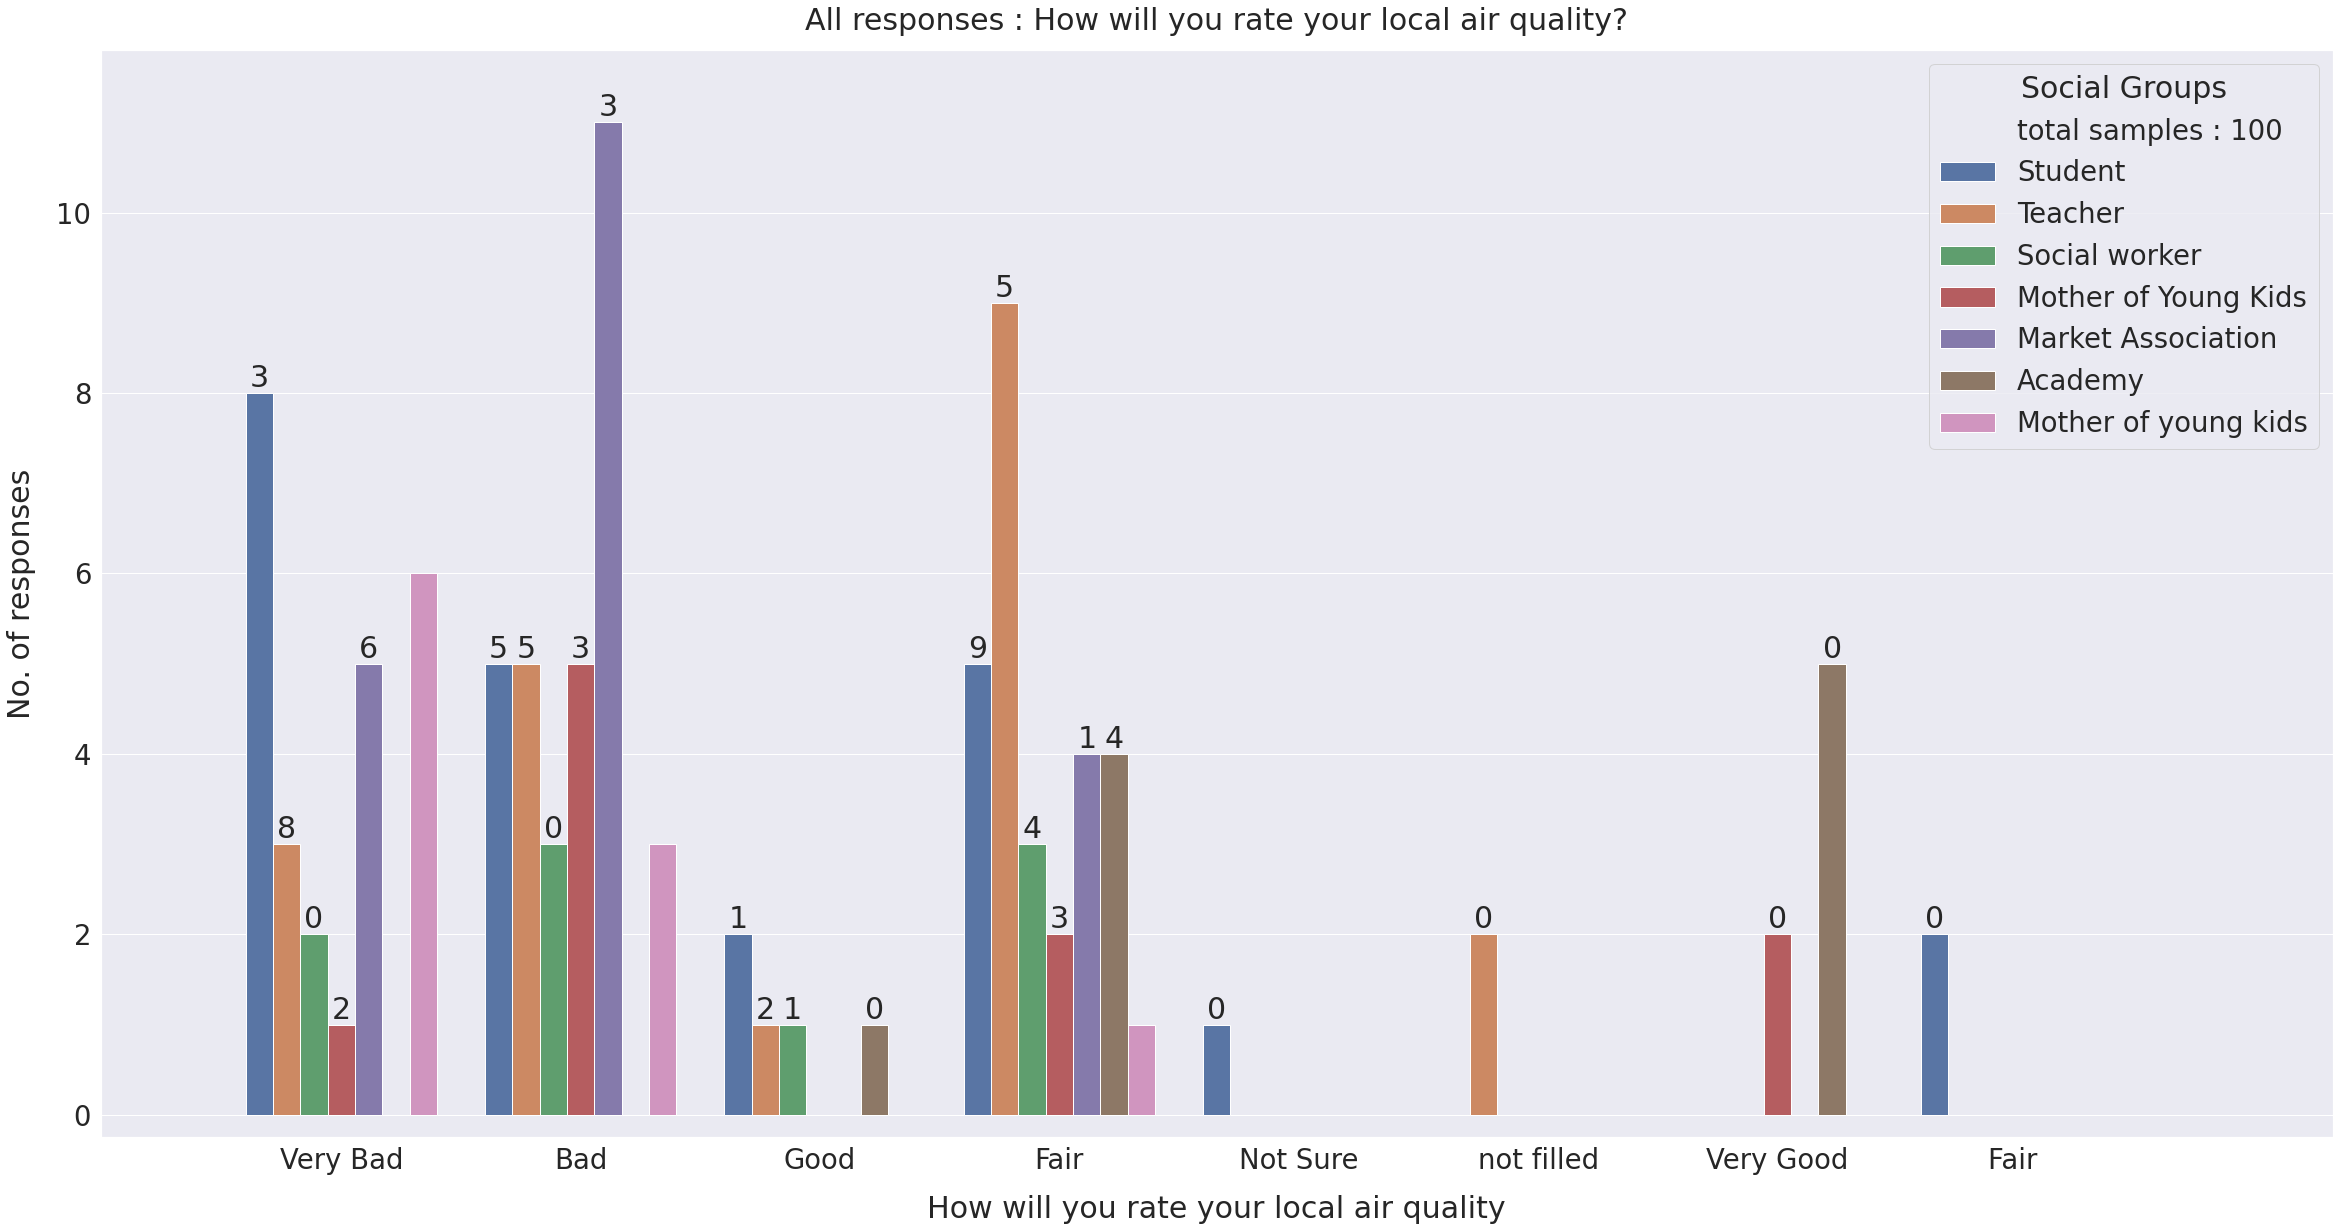

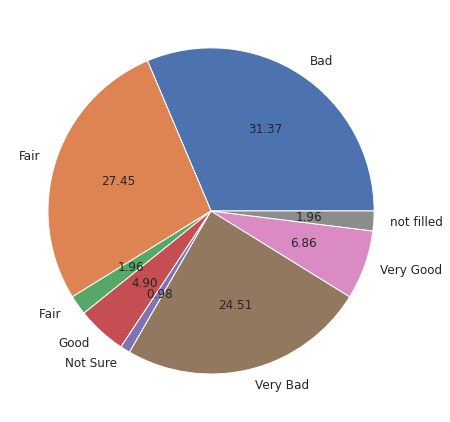

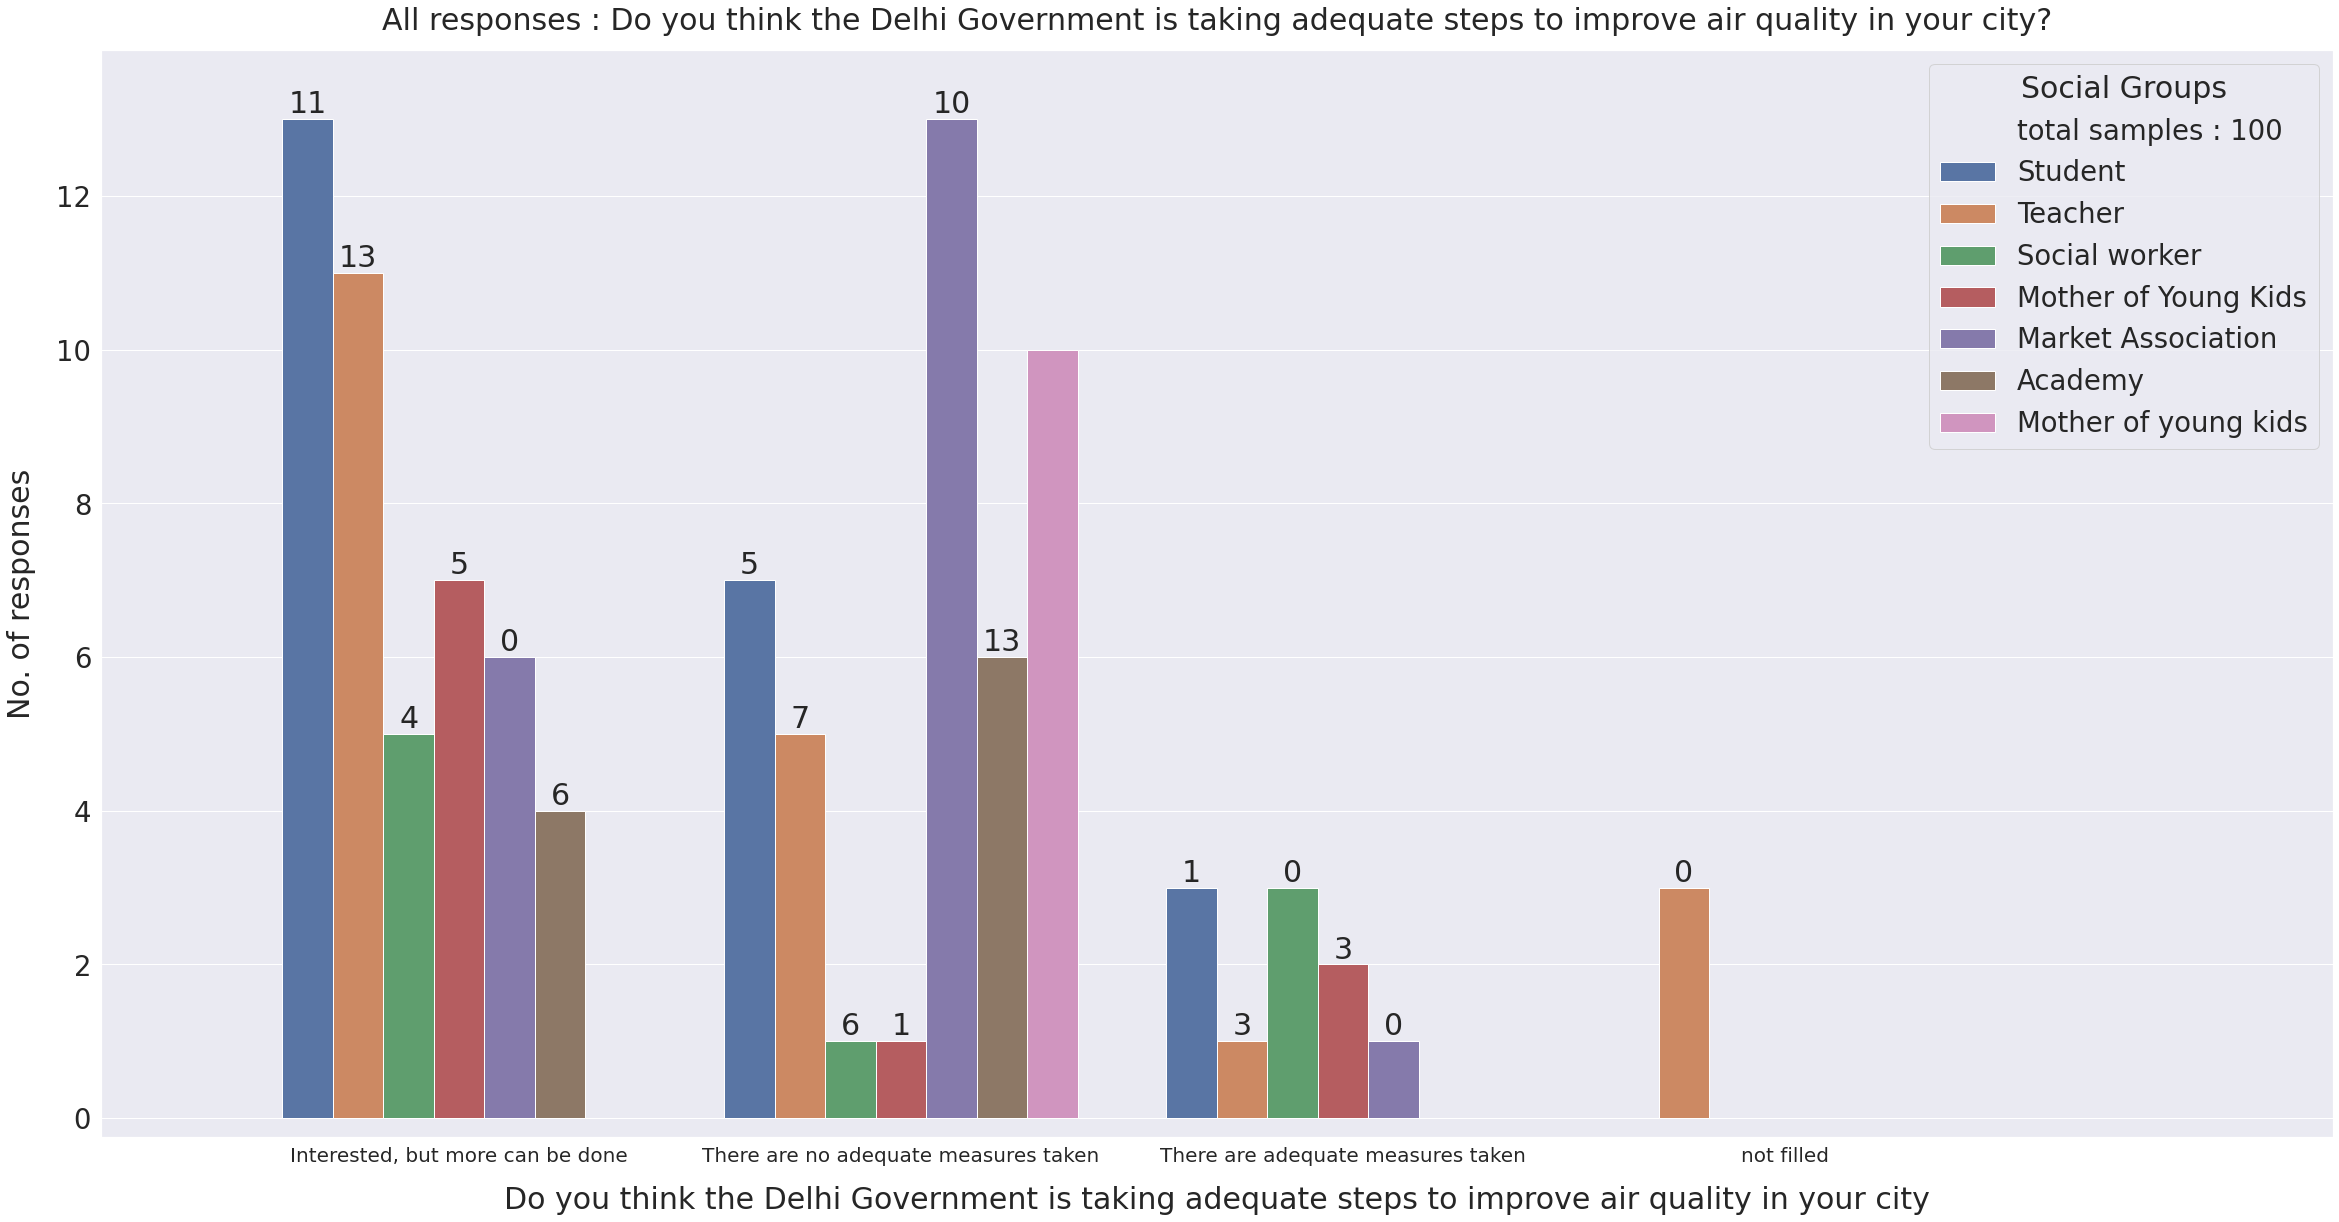

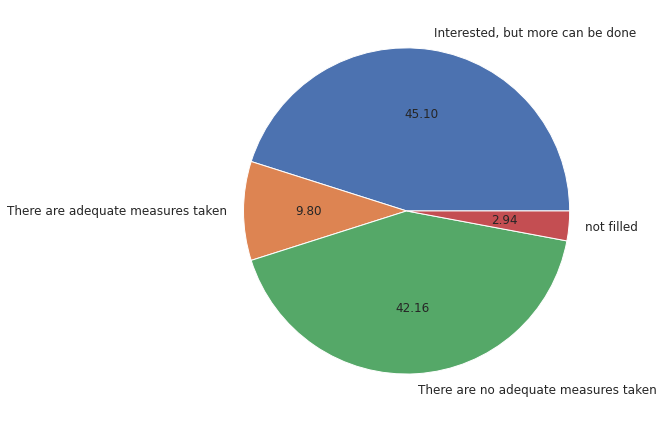

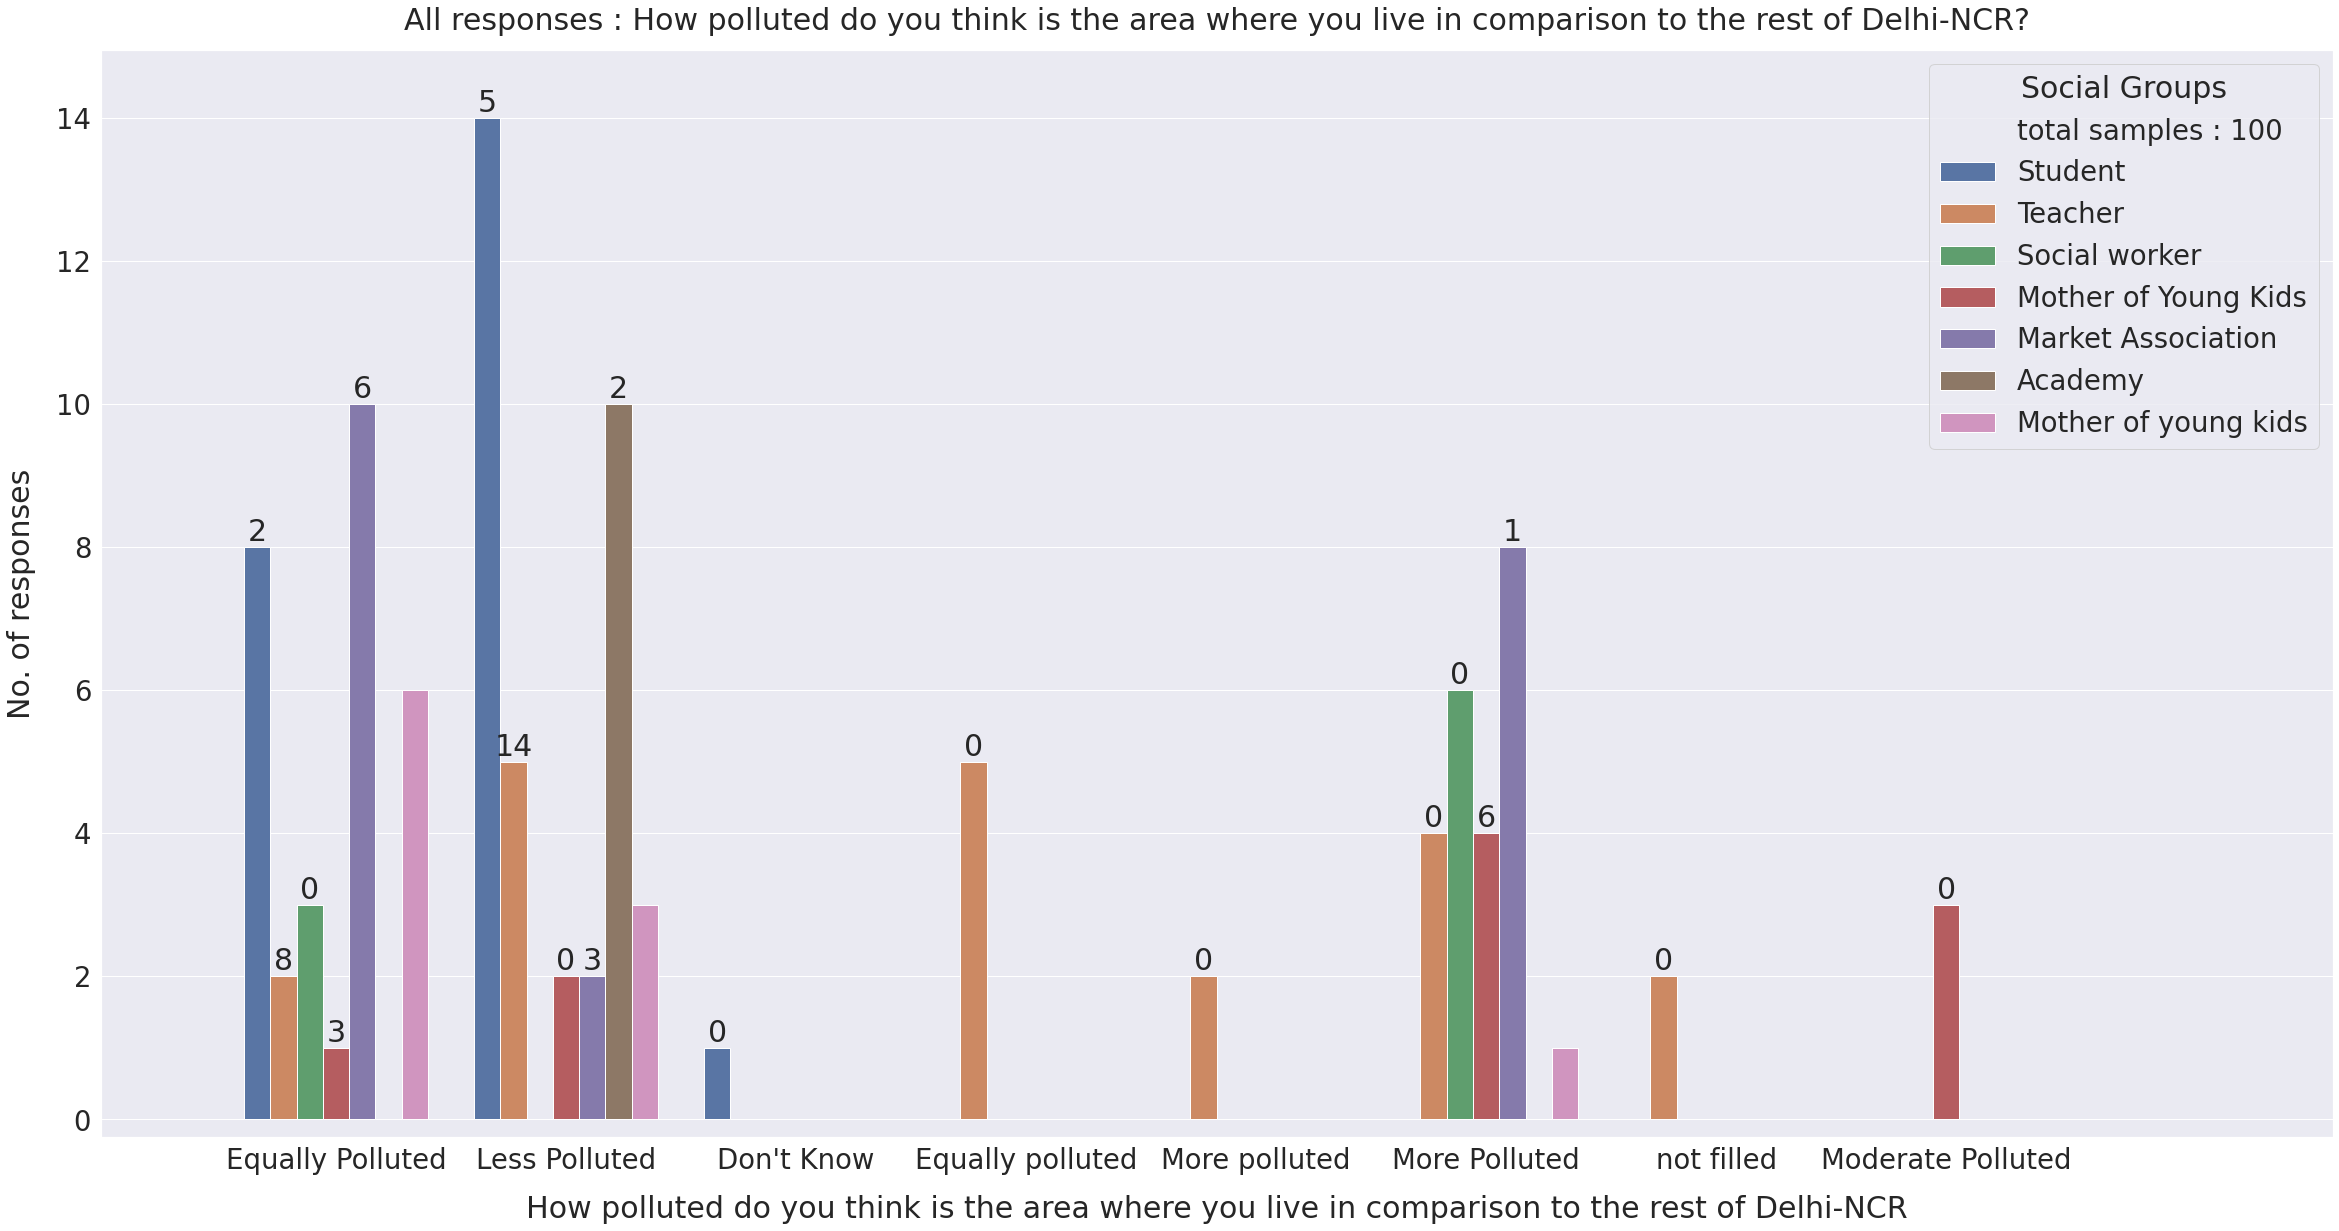

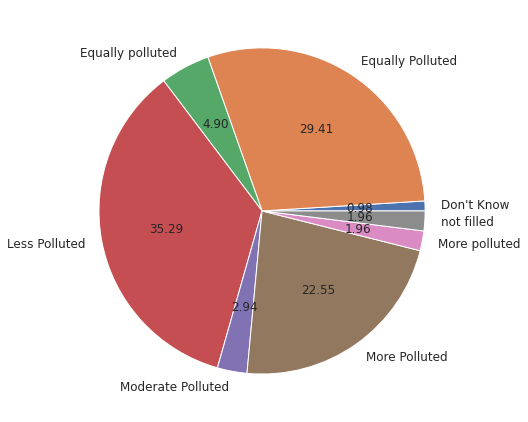

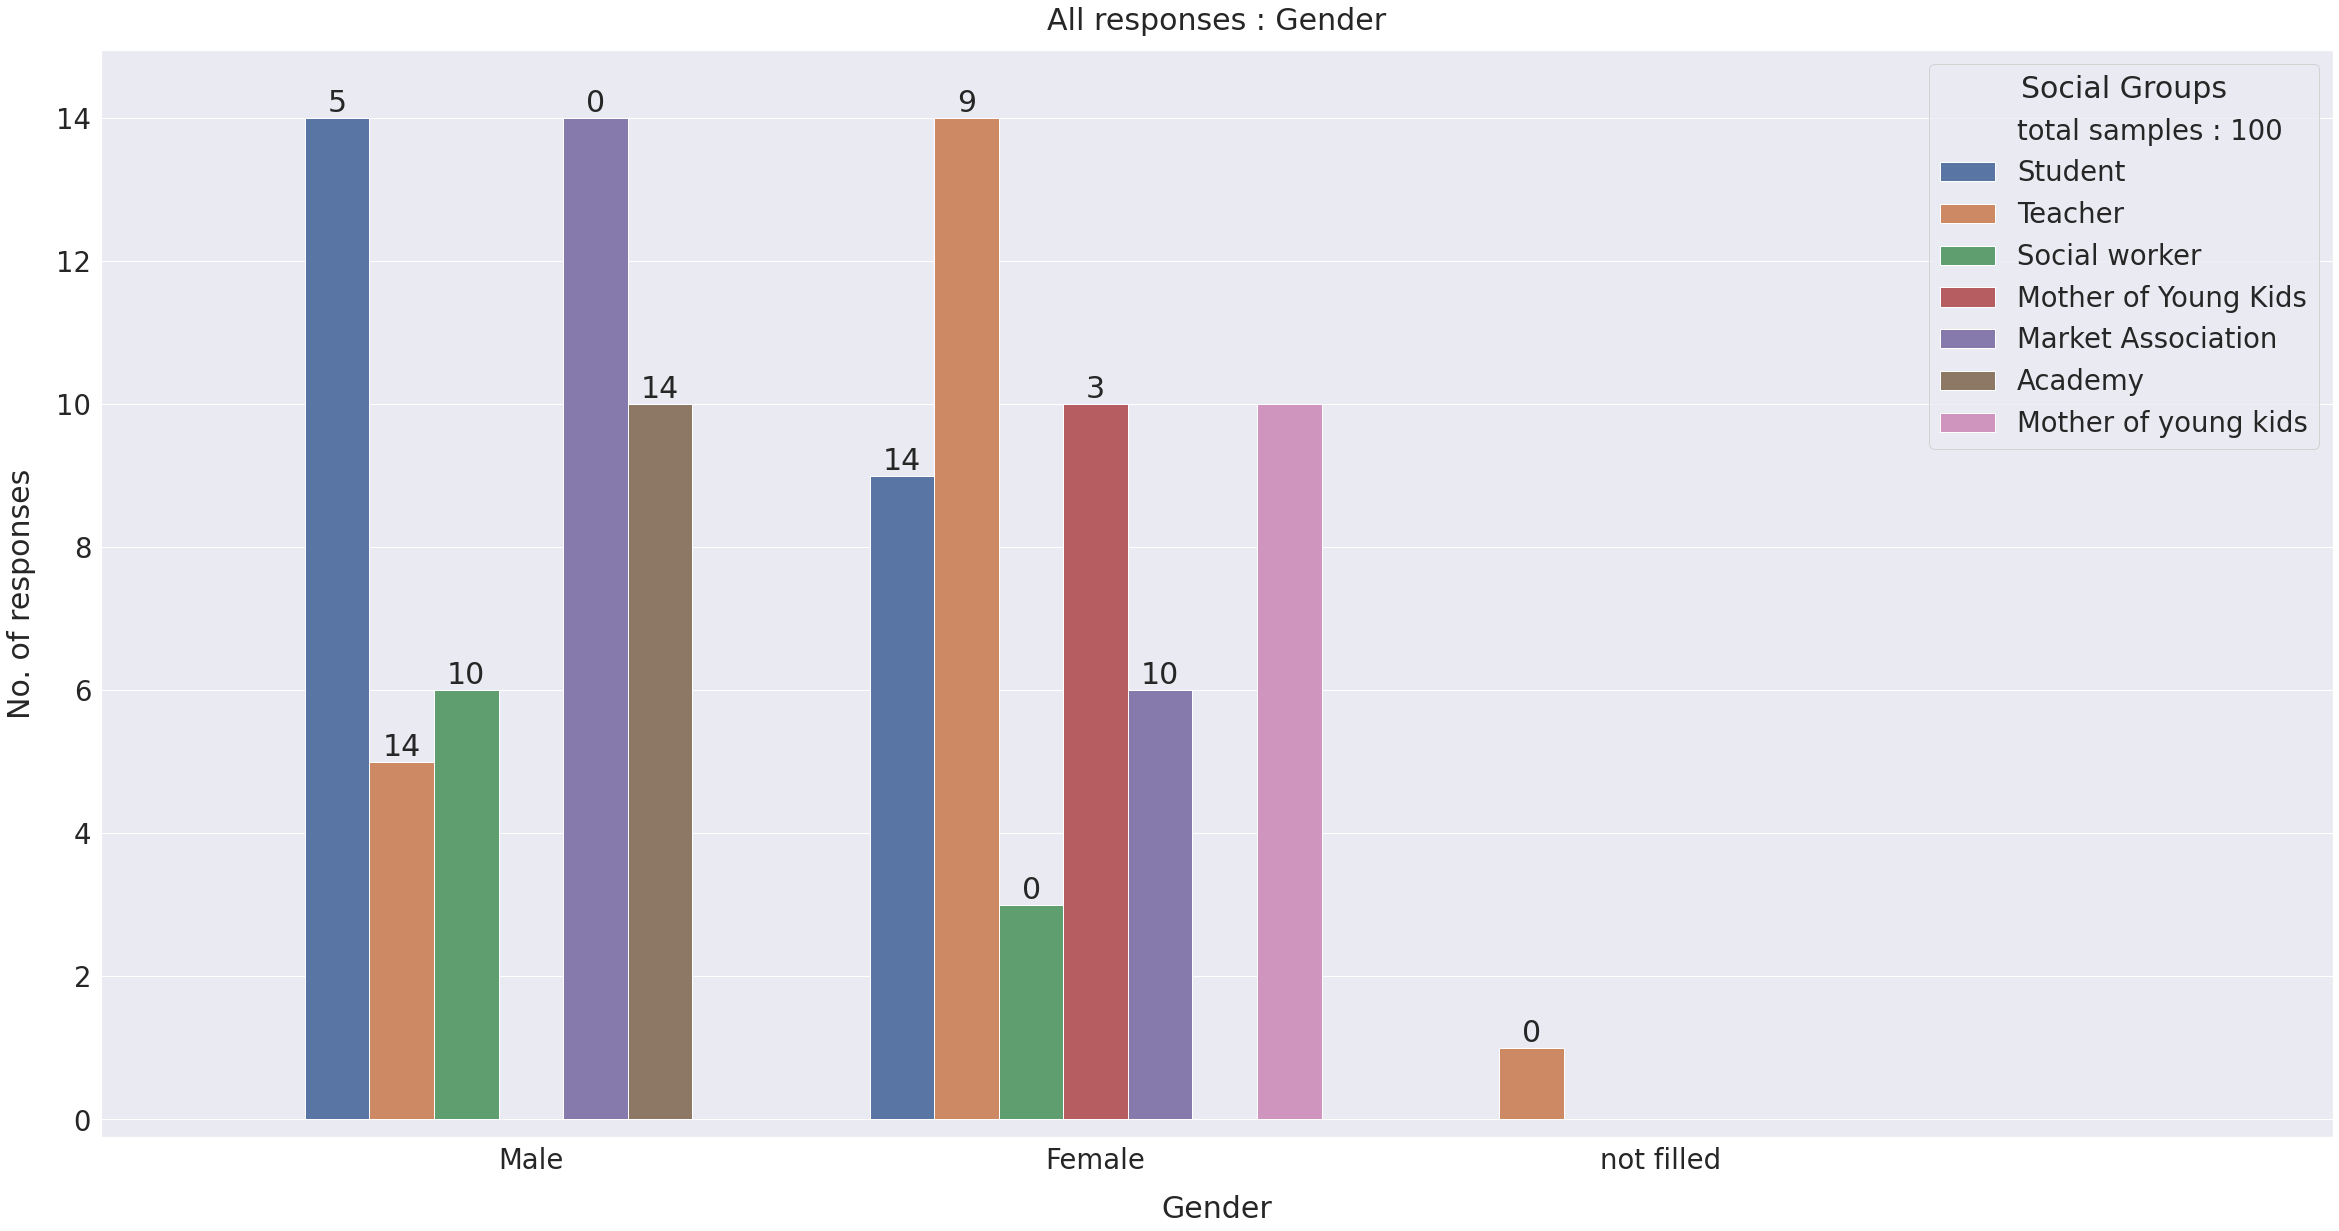

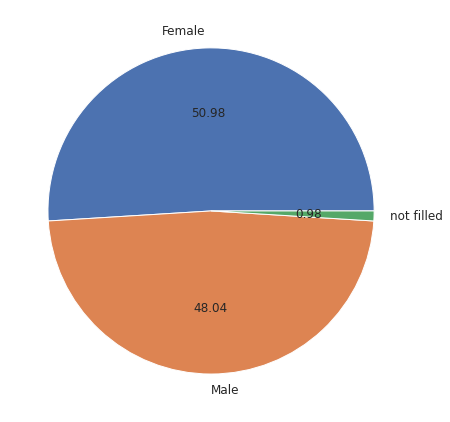

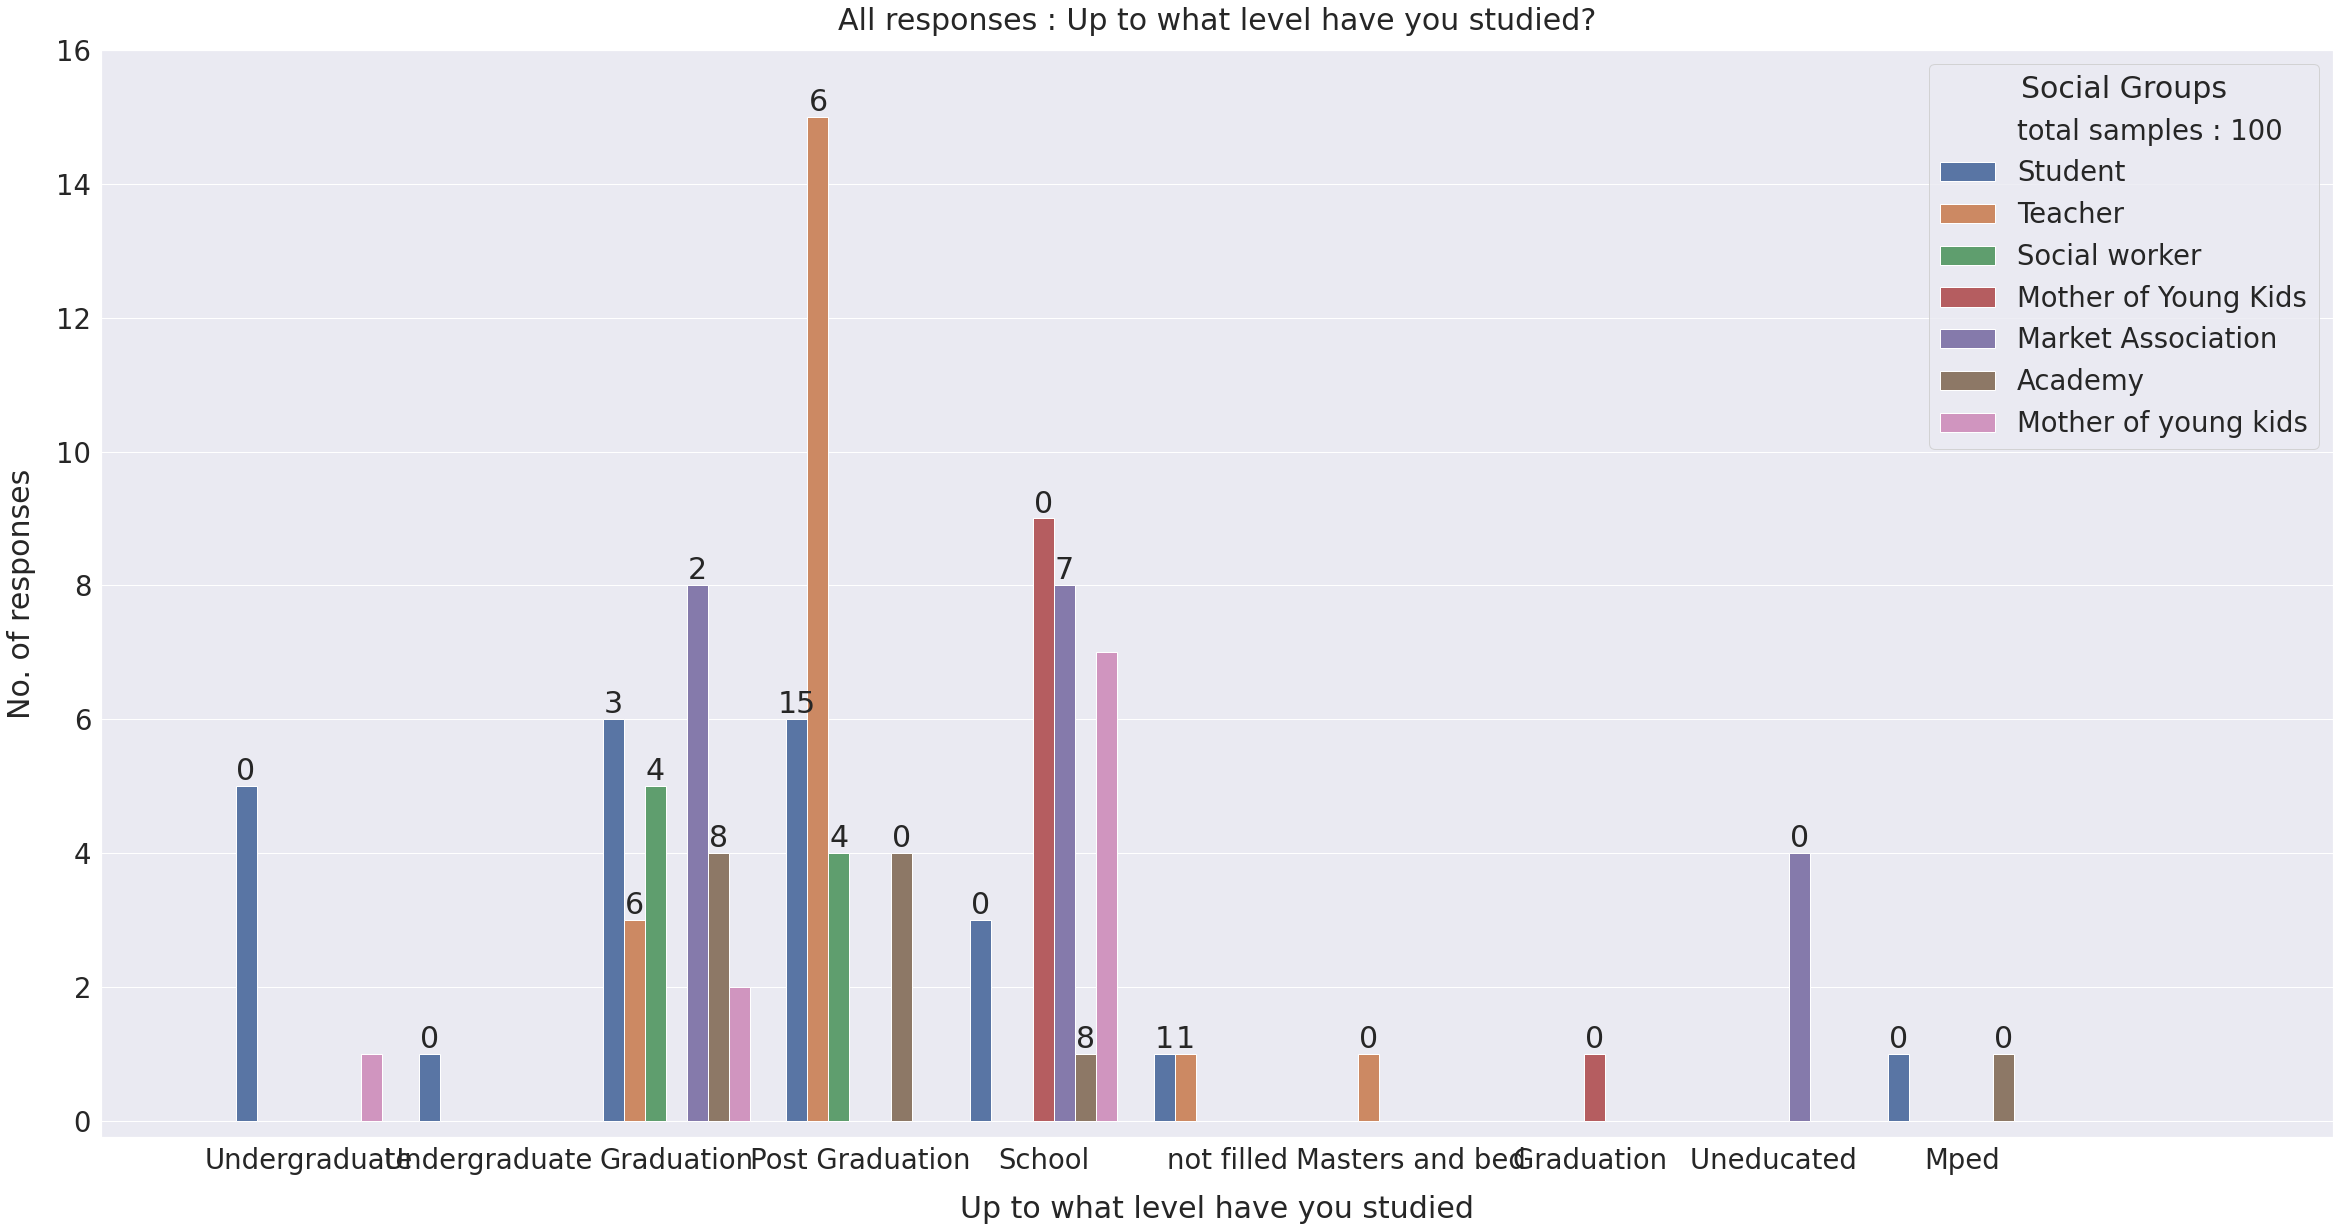

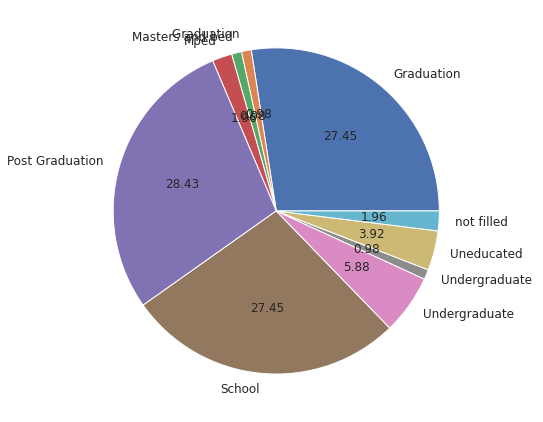

In [386]:
groups = ['Teacher', 'Student', 'Academy', 'Social worker', 'Mother of young kids','Market Association']
table_merged = pd.concat([table_okhla, table_najafgarh])
plot_selected_columns = []
plot_selected_columns += cols1
plot_selected_columns += cols2
plot_selected_columns += cols3
plot_selected_columns += cols4
for i in plot_selected_columns:
    col_name = i
    title = 'All responses : '+col_name
    xlabel = col_name.replace("?", "")
    plot_col_social_group(table_merged,col_name,
             title = title,
             xlabel = xlabel,loc='upper right',samples=100)

# Spatial variation graphs

In [ ]:
groups = ['Shaheen Bagh','Sanjay colony','Tekhand ','Najafgarh','Jharoda Kalan','Ghumanhera','not filled','Nangli']
groups = list(table_merged['Place where interview conducted'].unique())
table_merged = pd.concat([table_okhla, table_najafgarh])
plot_selected_columns = []
plot_selected_columns += cols1
plot_selected_columns += cols2
plot_selected_columns += cols3
plot_selected_columns += cols4
for i in plot_selected_columns:
    col_name = i
    title = 'All responses : '+col_name
    xlabel = col_name.replace("?", "")
    plot_col_social_group(table_merged,col_name,
             title = title,
             xlabel = xlabel,loc='upper right',samples=100,group_col='Place where interview conducted')

# Spatial comparison pie charts

In [ ]:
groups = ['Shaheen Bagh','Sanjay colony','Tekhand ','Najafgarh','Jharoda Kalan','Nangli']
groups = list(table_merged['Place where interview conducted'].unique())

def plot_col_spatial_group(table,col,perc=False,title='tile',xlabel='xlabel',loc='best',samples=50,group_col = 'Group'):
    sns.set_style("ticks")
    sns.set(font_scale = 2.5)
    copy_col = table.loc[:,col]
    copy_col[copy_col.isnull()] = 'not filled'
    table.loc[:,col] = copy_col
    
    dfs = []
    for g in groups:
        dfs.append(table[table[group_col]==g])
        
    fig, ax = plt.subplots(3,2,figsize=(40,40))
    
    fig.suptitle('All responses : '+col,fontsize=40, y=0.1)
    
    ax[0][0].set_xlabel(groups[0])
    ax[0][1].set_xlabel(groups[1])
    ax[1][0].set_xlabel(groups[2])
    ax[1][1].set_xlabel(groups[3])
    ax[2][0].set_xlabel(groups[4])
    ax[2][1].set_xlabel(groups[5])
    
    dfs[0].groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax[0][0],xlabel=groups[0],ylabel='',title='',fontsize=25)
    dfs[1].groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax[0][1],xlabel=groups[1],ylabel='',title='',fontsize=25)
    
    
    
    dfs[2].groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax[1][0],xlabel=groups[2],ylabel='',title='',fontsize=25)
    dfs[3].groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax[1][1],xlabel=groups[3],ylabel='',title='',fontsize=25)
    
    dfs[4].groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax[2][0],xlabel=groups[4],ylabel='',title='',fontsize=25)
    dfs[5].groupby(col).size().plot(kind='pie', autopct='%.2f',ax=ax[2][1],xlabel=groups[5],ylabel='',title='',fontsize=25)
    

table_merged = pd.concat([table_okhla, table_najafgarh])
plot_selected_columns = []
plot_selected_columns += cols1
plot_selected_columns += cols2
plot_selected_columns += cols3
plot_selected_columns += cols4
for i in plot_selected_columns:
    col_name = i
    title = 'All responses : '+col_name
    xlabel = col_name.replace("?", "")
    plot_col_spatial_group(table_merged,col_name,
             title = title,
             xlabel = xlabel,loc='upper right',samples=100,group_col='Place where interview conducted')